In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
cm_target[2]

'case2cm_blade1.csv'

In [11]:
str(cm_target[2])

'case2cm_blade1.csv'

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    #total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    file = cm_target
    df = pd.DataFrame()

    data = pd.read_csv(file, header=None)
    df = pd.concat([df, data], axis=0)

    time = df.iloc[:,0].values
    cm = df.iloc[:,1].values

    time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
    cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]

    # Handle the time that is duplicated because of digits
    # Also, outliers are regulated at the second conditional statement.
    time_beUsed = handler_time(time_beUsed)
    cm_beUsed = handler_cm(cm_beUsed)

    linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                       bounds_error=False,kind='quadratic',
                                       fill_value='extrapolate')
    time_interp = np.arange(10, 15, t_interval).reshape((-1,1))

    cm_interp=linear_func(time_interp).reshape((-1,1))

    cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[2], n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (5000, 2)
Dimension - x:  (5000, 1)
Dimension - y:  (5000, 1)


In [21]:
x -=10

In [22]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [24]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [25]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20221226_flap2_randomState50"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20221226unsteadyPrediction_MLP_flap2_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.2343 - rmse: 0.4839
Epoch 1: val_loss improved from inf to 0.17518, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 1s 107ms/step - loss: 0.2039 - rmse: 0.4514 - val_loss: 0.1752 - val_rmse: 0.4184 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1817 - rmse: 0.4262
Epoch 2: val_loss improved from 0.17518 to 0.13376, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.1489 - rmse: 0.3858 - val_loss: 0.1338 - val_rmse: 0.3656 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1191 - rmse: 0.3449
Epoch 3: val_loss improved from 0.

Epoch 21/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0834 - rmse: 0.2886
Epoch 21: val_loss improved from 0.09382 to 0.09272, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 39ms/step - loss: 0.0856 - rmse: 0.2923 - val_loss: 0.0927 - val_rmse: 0.3043 - lr: 1.0000e-04
Epoch 22/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0884 - rmse: 0.2971
Epoch 22: val_loss improved from 0.09272 to 0.09167, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 0.0875 - rmse: 0.2956 - val_loss: 0.0917 - val_rmse: 0.3026 - lr: 1.0000e-04
Epoch 23/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0805 - rmse: 0.2836
Epoch 23: val_loss improve

3/3 [==============================] - 0s 42ms/step - loss: 0.0728 - rmse: 0.2697 - val_loss: 0.0759 - val_rmse: 0.2754 - lr: 1.0000e-04
Epoch 40/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0681 - rmse: 0.2608
Epoch 40: val_loss improved from 0.07594 to 0.07555, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0709 - rmse: 0.2660 - val_loss: 0.0755 - val_rmse: 0.2747 - lr: 1.0000e-04
Epoch 41/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0709 - rmse: 0.2661
Epoch 41: val_loss improved from 0.07555 to 0.07516, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0700 - rmse: 0.2644 - val_loss: 0.0752 - val_rmse: 0.274

1/3 [=========>....................] - ETA: 0s - loss: 0.0733 - rmse: 0.2705
Epoch 60: val_loss improved from 0.07287 to 0.07260, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0695 - rmse: 0.2634 - val_loss: 0.0726 - val_rmse: 0.2693 - lr: 1.0000e-04
Epoch 61/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0679 - rmse: 0.2603
Epoch 61: val_loss did not improve from 0.07260
3/3 [==============================] - 0s 20ms/step - loss: 0.0684 - rmse: 0.2614 - val_loss: 0.0730 - val_rmse: 0.2701 - lr: 1.0000e-04
Epoch 62/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0722 - rmse: 0.2685
Epoch 62: val_loss improved from 0.07260 to 0.07255, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 51ms/step - loss: 0.0673 - rmse: 0.2591 - val_loss: 0.0699 - val_rmse: 0.2642 - lr: 1.0000e-04
Epoch 81/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0717 - rmse: 0.2676
Epoch 81: val_loss improved from 0.06993 to 0.06979, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0675 - rmse: 0.2597 - val_loss: 0.0698 - val_rmse: 0.2640 - lr: 1.0000e-04
Epoch 82/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0629 - rmse: 0.2506
Epoch 82: val_loss did not improve from 0.06979
3/3 [==============================] - 0s 21ms/step - loss: 0.0665 - rmse: 0.2577 - val_loss: 0.0702 - val_rmse: 0.2647 - lr: 1.0000e-04
Epoch 83/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0634 - rmse: 0.2516
Epoch 83: val_loss did not improve from 0.06979
3/3 [

Epoch 102/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0598 - rmse: 0.2444
Epoch 102: val_loss did not improve from 0.06693
3/3 [==============================] - 0s 22ms/step - loss: 0.0610 - rmse: 0.2469 - val_loss: 0.0671 - val_rmse: 0.2589 - lr: 1.0000e-04
Epoch 103/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0714 - rmse: 0.2670
Epoch 103: val_loss improved from 0.06693 to 0.06661, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0661 - rmse: 0.2569 - val_loss: 0.0666 - val_rmse: 0.2579 - lr: 1.0000e-04
Epoch 104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0659 - rmse: 0.2565
Epoch 104: val_loss improved from 0.06661 to 0.06650, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_

Epoch 122/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0646 - rmse: 0.2540
Epoch 122: val_loss improved from 0.06383 to 0.06371, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0609 - rmse: 0.2467 - val_loss: 0.0637 - val_rmse: 0.2522 - lr: 1.0000e-04
Epoch 123/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0645 - rmse: 0.2538
Epoch 123: val_loss improved from 0.06371 to 0.06356, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0635 - rmse: 0.2518 - val_loss: 0.0636 - val_rmse: 0.2519 - lr: 1.0000e-04
Epoch 124/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0613 - rmse: 0.2473
Epoch 124: val_loss i

3/3 [==============================] - 0s 43ms/step - loss: 0.0587 - rmse: 0.2421 - val_loss: 0.0611 - val_rmse: 0.2470 - lr: 1.0000e-04
Epoch 143/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0654 - rmse: 0.2555
Epoch 143: val_loss did not improve from 0.06113
3/3 [==============================] - 0s 21ms/step - loss: 0.0630 - rmse: 0.2508 - val_loss: 0.0613 - val_rmse: 0.2473 - lr: 1.0000e-04
Epoch 144/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0618 - rmse: 0.2484
Epoch 144: val_loss improved from 0.06113 to 0.06094, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0604 - rmse: 0.2455 - val_loss: 0.0609 - val_rmse: 0.2467 - lr: 1.0000e-04
Epoch 145/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0624 - rmse: 0.2496
Epoch 145: val_loss improved from 0.06094 to 0.0

Epoch 164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0559 - rmse: 0.2361
Epoch 164: val_loss improved from 0.05926 to 0.05908, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0575 - rmse: 0.2396 - val_loss: 0.0591 - val_rmse: 0.2429 - lr: 1.0000e-04
Epoch 165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0644 - rmse: 0.2536
Epoch 165: val_loss improved from 0.05908 to 0.05907, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0600 - rmse: 0.2447 - val_loss: 0.0591 - val_rmse: 0.2428 - lr: 1.0000e-04
Epoch 166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0559 - rmse: 0.2363
Epoch 166: val_loss i

3/3 [==============================] - 0s 46ms/step - loss: 0.0595 - rmse: 0.2437 - val_loss: 0.0579 - val_rmse: 0.2404 - lr: 1.0000e-04
Epoch 185/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0592 - rmse: 0.2432
Epoch 185: val_loss improved from 0.05789 to 0.05777, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0596 - rmse: 0.2440 - val_loss: 0.0578 - val_rmse: 0.2402 - lr: 1.0000e-04
Epoch 186/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2342
Epoch 186: val_loss did not improve from 0.05777
3/3 [==============================] - 0s 21ms/step - loss: 0.0562 - rmse: 0.2369 - val_loss: 0.0589 - val_rmse: 0.2424 - lr: 1.0000e-04
Epoch 187/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0627 - rmse: 0.2503
Epoch 187: val_loss did not improve from 0.05777

3/3 [==============================] - 0s 56ms/step - loss: 0.0577 - rmse: 0.2400 - val_loss: 0.0569 - val_rmse: 0.2383 - lr: 1.0000e-04
Epoch 206/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0591 - rmse: 0.2429
Epoch 206: val_loss did not improve from 0.05690
3/3 [==============================] - 0s 20ms/step - loss: 0.0594 - rmse: 0.2436 - val_loss: 0.0569 - val_rmse: 0.2384 - lr: 1.0000e-04
Epoch 207/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0587 - rmse: 0.2421
Epoch 207: val_loss did not improve from 0.05690
3/3 [==============================] - 0s 21ms/step - loss: 0.0580 - rmse: 0.2406 - val_loss: 0.0575 - val_rmse: 0.2397 - lr: 1.0000e-04
Epoch 208/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0602 - rmse: 0.2451
Epoch 208: val_loss improved from 0.05690 to 0.05685, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5

3/3 [==============================] - 0s 21ms/step - loss: 0.0597 - rmse: 0.2440 - val_loss: 0.0575 - val_rmse: 0.2397 - lr: 1.0000e-04
Epoch 229/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0618 - rmse: 0.2483
Epoch 229: val_loss did not improve from 0.05638
3/3 [==============================] - 0s 22ms/step - loss: 0.0594 - rmse: 0.2435 - val_loss: 0.0566 - val_rmse: 0.2376 - lr: 1.0000e-04
Epoch 230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0494 - rmse: 0.2221
Epoch 230: val_loss did not improve from 0.05638
3/3 [==============================] - 0s 21ms/step - loss: 0.0590 - rmse: 0.2426 - val_loss: 0.0571 - val_rmse: 0.2388 - lr: 1.0000e-04
Epoch 231/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0538 - rmse: 0.2318
Epoch 231: val_loss did not improve from 0.05638
3/3 [==============================] - 0s 21ms/step - loss: 0.0575 - rmse: 0.2395 - val_loss: 0.0578 - val_rmse: 0.2403 - lr: 1.0000e-04
Epoch 232/10000
1/3 [=====

1/3 [=========>....................] - ETA: 0s - loss: 0.0572 - rmse: 0.2389
Epoch 253: val_loss did not improve from 0.05608
3/3 [==============================] - 0s 21ms/step - loss: 0.0562 - rmse: 0.2369 - val_loss: 0.0562 - val_rmse: 0.2368 - lr: 1.0000e-04
Epoch 254/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0622 - rmse: 0.2491
Epoch 254: val_loss improved from 0.05608 to 0.05606, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0574 - rmse: 0.2394 - val_loss: 0.0561 - val_rmse: 0.2366 - lr: 1.0000e-04
Epoch 255/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0605 - rmse: 0.2458
Epoch 255: val_loss did not improve from 0.05606
3/3 [==============================] - 0s 21ms/step - loss: 0.0573 - rmse: 0.2391 - val_loss: 0.0562 - val_rmse: 0.2369 - lr: 1.0000e-04
Epoch 256/10000

1/3 [=========>....................] - ETA: 0s - loss: 0.0547 - rmse: 0.2338
Epoch 277: val_loss did not improve from 0.05593
3/3 [==============================] - 0s 21ms/step - loss: 0.0557 - rmse: 0.2359 - val_loss: 0.0560 - val_rmse: 0.2365 - lr: 1.0000e-04
Epoch 278/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0633 - rmse: 0.2515
Epoch 278: val_loss did not improve from 0.05593
3/3 [==============================] - 0s 21ms/step - loss: 0.0588 - rmse: 0.2422 - val_loss: 0.0561 - val_rmse: 0.2366 - lr: 1.0000e-04
Epoch 279/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0553 - rmse: 0.2350
Epoch 279: val_loss did not improve from 0.05593
3/3 [==============================] - 0s 21ms/step - loss: 0.0582 - rmse: 0.2410 - val_loss: 0.0562 - val_rmse: 0.2369 - lr: 1.0000e-04
Epoch 280/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0555 - rmse: 0.2354
Epoch 280: val_loss did not improve from 0.05593
3/3 [==============================] 

3/3 [==============================] - 0s 21ms/step - loss: 0.0586 - rmse: 0.2419 - val_loss: 0.0561 - val_rmse: 0.2366 - lr: 1.0000e-04
Epoch 304/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0583 - rmse: 0.2413
Epoch 304: val_loss did not improve from 0.05587
3/3 [==============================] - 0s 22ms/step - loss: 0.0553 - rmse: 0.2349 - val_loss: 0.0566 - val_rmse: 0.2378 - lr: 1.0000e-04
Epoch 305/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0527 - rmse: 0.2294
Epoch 305: val_loss improved from 0.05587 to 0.05586, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0570 - rmse: 0.2385 - val_loss: 0.0559 - val_rmse: 0.2362 - lr: 1.0000e-04
Epoch 306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0593 - rmse: 0.2434
Epoch 306: val_loss did not improve from 0.05586

Epoch 331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0540 - rmse: 0.2323
Epoch 331: val_loss did not improve from 0.05577
3/3 [==============================] - 0s 21ms/step - loss: 0.0531 - rmse: 0.2302 - val_loss: 0.0569 - val_rmse: 0.2384 - lr: 1.0000e-04
Epoch 332/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0647 - rmse: 0.2541
Epoch 332: val_loss did not improve from 0.05577
3/3 [==============================] - 0s 21ms/step - loss: 0.0598 - rmse: 0.2444 - val_loss: 0.0559 - val_rmse: 0.2362 - lr: 1.0000e-04
Epoch 333/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0581 - rmse: 0.2409
Epoch 333: val_loss improved from 0.05577 to 0.05576, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 61ms/step - loss: 0.0571 - rmse: 0.2387 - val_loss: 0.0558 - val_rmse: 0.2359 - lr: 1.0000e-04

Epoch 357/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0632 - rmse: 0.2512
Epoch 357: val_loss improved from 0.05566 to 0.05562, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0573 - rmse: 0.2392 - val_loss: 0.0556 - val_rmse: 0.2356 - lr: 1.0000e-04
Epoch 358/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0508 - rmse: 0.2253
Epoch 358: val_loss did not improve from 0.05562
3/3 [==============================] - 0s 21ms/step - loss: 0.0549 - rmse: 0.2342 - val_loss: 0.0564 - val_rmse: 0.2372 - lr: 1.0000e-04
Epoch 359/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0611 - rmse: 0.2469
Epoch 359: val_loss did not improve from 0.05562
3/3 [==============================] - 0s 20ms/step - loss: 0.0596 - rmse: 0.2440 - val_loss: 0.0565 - val_rmse: 0.2376 - lr: 1.0000e-04

Epoch 383/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0542 - rmse: 0.2325
Epoch 383: val_loss did not improve from 0.05547
3/3 [==============================] - 0s 21ms/step - loss: 0.0542 - rmse: 0.2327 - val_loss: 0.0556 - val_rmse: 0.2355 - lr: 1.0000e-04
Epoch 384/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2305
Epoch 384: val_loss did not improve from 0.05547
3/3 [==============================] - 0s 20ms/step - loss: 0.0565 - rmse: 0.2375 - val_loss: 0.0555 - val_rmse: 0.2354 - lr: 1.0000e-04
Epoch 385/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0564 - rmse: 0.2373
Epoch 385: val_loss improved from 0.05547 to 0.05545, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0571 - rmse: 0.2387 - val_loss: 0.0555 - val_rmse: 0.2353 - lr: 1.0000e-04

Epoch 408/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2346
Epoch 408: val_loss did not improve from 0.05532
3/3 [==============================] - 0s 21ms/step - loss: 0.0547 - rmse: 0.2337 - val_loss: 0.0556 - val_rmse: 0.2355 - lr: 1.0000e-04
Epoch 409/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0524 - rmse: 0.2288
Epoch 409: val_loss improved from 0.05532 to 0.05527, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0554 - rmse: 0.2351 - val_loss: 0.0553 - val_rmse: 0.2349 - lr: 1.0000e-04
Epoch 410/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0597 - rmse: 0.2441
Epoch 410: val_loss did not improve from 0.05527
3/3 [==============================] - 0s 21ms/step - loss: 0.0562 - rmse: 0.2369 - val_loss: 0.0553 - val_rmse: 0.2350 - lr: 1.0000e-04

Epoch 433/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0581 - rmse: 0.2408
Epoch 433: val_loss did not improve from 0.05511
3/3 [==============================] - 0s 20ms/step - loss: 0.0554 - rmse: 0.2352 - val_loss: 0.0551 - val_rmse: 0.2346 - lr: 1.0000e-04
Epoch 434/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0567 - rmse: 0.2378
Epoch 434: val_loss did not improve from 0.05511
3/3 [==============================] - 0s 21ms/step - loss: 0.0546 - rmse: 0.2334 - val_loss: 0.0551 - val_rmse: 0.2346 - lr: 1.0000e-04
Epoch 435/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0589 - rmse: 0.2426
Epoch 435: val_loss improved from 0.05511 to 0.05508, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0578 - rmse: 0.2402 - val_loss: 0.0551 - val_rmse: 0.2345 - lr: 1.0000e-04

3/3 [==============================] - 0s 56ms/step - loss: 0.0567 - rmse: 0.2380 - val_loss: 0.0548 - val_rmse: 0.2340 - lr: 1.0000e-04
Epoch 458/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0486 - rmse: 0.2202
Epoch 458: val_loss improved from 0.05484 to 0.05483, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0545 - rmse: 0.2332 - val_loss: 0.0548 - val_rmse: 0.2340 - lr: 1.0000e-04
Epoch 459/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0559 - rmse: 0.2362
Epoch 459: val_loss did not improve from 0.05483
3/3 [==============================] - 0s 21ms/step - loss: 0.0536 - rmse: 0.2314 - val_loss: 0.0553 - val_rmse: 0.2350 - lr: 1.0000e-04
Epoch 460/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2341
Epoch 460: val_loss did not improve from 0.05483

Epoch 482/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0472 - rmse: 0.2170
Epoch 482: val_loss did not improve from 0.05456
3/3 [==============================] - 0s 21ms/step - loss: 0.0520 - rmse: 0.2279 - val_loss: 0.0549 - val_rmse: 0.2340 - lr: 1.0000e-04
Epoch 483/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0544 - rmse: 0.2330
Epoch 483: val_loss did not improve from 0.05456
3/3 [==============================] - 0s 22ms/step - loss: 0.0550 - rmse: 0.2344 - val_loss: 0.0552 - val_rmse: 0.2348 - lr: 1.0000e-04
Epoch 484/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0570 - rmse: 0.2385
Epoch 484: val_loss did not improve from 0.05456
3/3 [==============================] - 0s 22ms/step - loss: 0.0568 - rmse: 0.2381 - val_loss: 0.0549 - val_rmse: 0.2341 - lr: 1.0000e-04
Epoch 485/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0504 - rmse: 0.2243
Epoch 485: val_loss improved from 0.05456 to 0.05452, saving model to 

Epoch 507/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0564 - rmse: 0.2373
Epoch 507: val_loss improved from 0.05419 to 0.05415, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0529 - rmse: 0.2297 - val_loss: 0.0541 - val_rmse: 0.2325 - lr: 1.0000e-04
Epoch 508/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0612 - rmse: 0.2471
Epoch 508: val_loss did not improve from 0.05415
3/3 [==============================] - 0s 22ms/step - loss: 0.0554 - rmse: 0.2352 - val_loss: 0.0544 - val_rmse: 0.2331 - lr: 1.0000e-04
Epoch 509/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0540 - rmse: 0.2323
Epoch 509: val_loss improved from 0.05415 to 0.05411, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_

1/3 [=========>....................] - ETA: 0s - loss: 0.0557 - rmse: 0.2359
Epoch 529: val_loss did not improve from 0.05387
3/3 [==============================] - 0s 21ms/step - loss: 0.0547 - rmse: 0.2336 - val_loss: 0.0539 - val_rmse: 0.2320 - lr: 1.0000e-04
Epoch 530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0536 - rmse: 0.2313
Epoch 530: val_loss improved from 0.05387 to 0.05379, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0551 - rmse: 0.2346 - val_loss: 0.0538 - val_rmse: 0.2317 - lr: 1.0000e-04
Epoch 531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0525 - rmse: 0.2290
Epoch 531: val_loss did not improve from 0.05379
3/3 [==============================] - 0s 22ms/step - loss: 0.0519 - rmse: 0.2277 - val_loss: 0.0551 - val_rmse: 0.2346 - lr: 1.0000e-04
Epoch 532/10000

3/3 [==============================] - 0s 21ms/step - loss: 0.0505 - rmse: 0.2245 - val_loss: 0.0536 - val_rmse: 0.2314 - lr: 1.0000e-04
Epoch 552/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0555 - rmse: 0.2354
Epoch 552: val_loss did not improve from 0.05332
3/3 [==============================] - 0s 21ms/step - loss: 0.0555 - rmse: 0.2355 - val_loss: 0.0535 - val_rmse: 0.2310 - lr: 1.0000e-04
Epoch 553/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0544 - rmse: 0.2330
Epoch 553: val_loss did not improve from 0.05332
3/3 [==============================] - 0s 21ms/step - loss: 0.0540 - rmse: 0.2323 - val_loss: 0.0535 - val_rmse: 0.2311 - lr: 1.0000e-04
Epoch 554/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0520 - rmse: 0.2278
Epoch 554: val_loss improved from 0.05332 to 0.05323, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5

3/3 [==============================] - 0s 50ms/step - loss: 0.0535 - rmse: 0.2312 - val_loss: 0.0528 - val_rmse: 0.2297 - lr: 1.0000e-04
Epoch 574/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0512 - rmse: 0.2262
Epoch 574: val_loss did not improve from 0.05283
3/3 [==============================] - 0s 21ms/step - loss: 0.0527 - rmse: 0.2294 - val_loss: 0.0530 - val_rmse: 0.2300 - lr: 1.0000e-04
Epoch 575/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0495 - rmse: 0.2224
Epoch 575: val_loss improved from 0.05283 to 0.05280, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 58ms/step - loss: 0.0529 - rmse: 0.2299 - val_loss: 0.0528 - val_rmse: 0.2296 - lr: 1.0000e-04
Epoch 576/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0564 - rmse: 0.2373
Epoch 576: val_loss did not improve from 0.05280

3/3 [==============================] - 0s 21ms/step - loss: 0.0511 - rmse: 0.2260 - val_loss: 0.0522 - val_rmse: 0.2282 - lr: 1.0000e-04
Epoch 597/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0577 - rmse: 0.2400
Epoch 597: val_loss improved from 0.05215 to 0.05202, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0525 - rmse: 0.2289 - val_loss: 0.0520 - val_rmse: 0.2279 - lr: 1.0000e-04
Epoch 598/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0510 - rmse: 0.2256
Epoch 598: val_loss did not improve from 0.05202
3/3 [==============================] - 0s 21ms/step - loss: 0.0520 - rmse: 0.2278 - val_loss: 0.0521 - val_rmse: 0.2281 - lr: 1.0000e-04
Epoch 599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0524 - rmse: 0.2287
Epoch 599: val_loss improved from 0.05202 to 0.0

3/3 [==============================] - 0s 46ms/step - loss: 0.0496 - rmse: 0.2224 - val_loss: 0.0513 - val_rmse: 0.2262 - lr: 1.0000e-04
Epoch 619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0543 - rmse: 0.2328
Epoch 619: val_loss improved from 0.05127 to 0.05119, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0505 - rmse: 0.2246 - val_loss: 0.0512 - val_rmse: 0.2261 - lr: 1.0000e-04
Epoch 620/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0561 - rmse: 0.2366
Epoch 620: val_loss did not improve from 0.05119
3/3 [==============================] - 0s 21ms/step - loss: 0.0530 - rmse: 0.2301 - val_loss: 0.0512 - val_rmse: 0.2261 - lr: 1.0000e-04
Epoch 621/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0491 - rmse: 0.2213
Epoch 621: val_loss improved from 0.05119 to 0.0

1/3 [=========>....................] - ETA: 0s - loss: 0.0478 - rmse: 0.2184
Epoch 639: val_loss did not improve from 0.05041
3/3 [==============================] - 0s 20ms/step - loss: 0.0501 - rmse: 0.2236 - val_loss: 0.0507 - val_rmse: 0.2250 - lr: 1.0000e-04
Epoch 640/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0474 - rmse: 0.2176
Epoch 640: val_loss did not improve from 0.05041
3/3 [==============================] - 0s 20ms/step - loss: 0.0506 - rmse: 0.2247 - val_loss: 0.0507 - val_rmse: 0.2250 - lr: 1.0000e-04
Epoch 641/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0490 - rmse: 0.2212
Epoch 641: val_loss did not improve from 0.05041
3/3 [==============================] - 0s 21ms/step - loss: 0.0503 - rmse: 0.2240 - val_loss: 0.0504 - val_rmse: 0.2244 - lr: 1.0000e-04
Epoch 642/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0496 - rmse: 0.2225
Epoch 642: val_loss did not improve from 0.05041
3/3 [==============================] 

Epoch 664/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0517 - rmse: 0.2273
Epoch 664: val_loss did not improve from 0.04965
3/3 [==============================] - 0s 21ms/step - loss: 0.0484 - rmse: 0.2199 - val_loss: 0.0502 - val_rmse: 0.2240 - lr: 1.0000e-04
Epoch 665/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0440 - rmse: 0.2095
Epoch 665: val_loss improved from 0.04965 to 0.04964, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0489 - rmse: 0.2210 - val_loss: 0.0496 - val_rmse: 0.2226 - lr: 1.0000e-04
Epoch 666/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0513 - rmse: 0.2263
Epoch 666: val_loss did not improve from 0.04964
3/3 [==============================] - 0s 21ms/step - loss: 0.0486 - rmse: 0.2202 - val_loss: 0.0498 - val_rmse: 0.2229 - lr: 1.0000e-04

Epoch 687/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0458 - rmse: 0.2138
Epoch 687: val_loss did not improve from 0.04850
3/3 [==============================] - 0s 21ms/step - loss: 0.0467 - rmse: 0.2160 - val_loss: 0.0486 - val_rmse: 0.2202 - lr: 1.0000e-04
Epoch 688/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0455 - rmse: 0.2131
Epoch 688: val_loss did not improve from 0.04850
3/3 [==============================] - 0s 21ms/step - loss: 0.0480 - rmse: 0.2189 - val_loss: 0.0486 - val_rmse: 0.2204 - lr: 1.0000e-04
Epoch 689/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0492 - rmse: 0.2215
Epoch 689: val_loss did not improve from 0.04850
3/3 [==============================] - 0s 21ms/step - loss: 0.0476 - rmse: 0.2180 - val_loss: 0.0487 - val_rmse: 0.2204 - lr: 1.0000e-04
Epoch 690/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0488 - rmse: 0.2207
Epoch 690: val_loss did not improve from 0.04850
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0475 - rmse: 0.2178
Epoch 711: val_loss improved from 0.04765 to 0.04748, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 61ms/step - loss: 0.0455 - rmse: 0.2131 - val_loss: 0.0475 - val_rmse: 0.2177 - lr: 1.0000e-04
Epoch 712/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0470 - rmse: 0.2165
Epoch 712: val_loss improved from 0.04748 to 0.04741, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0474 - rmse: 0.2175 - val_loss: 0.0474 - val_rmse: 0.2176 - lr: 1.0000e-04
Epoch 713/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0473 - rmse: 0.2173
Epoch 713: val_loss did not improve f

3/3 [==============================] - 0s 48ms/step - loss: 0.0467 - rmse: 0.2159 - val_loss: 0.0466 - val_rmse: 0.2157 - lr: 1.0000e-04
Epoch 734/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0388 - rmse: 0.1967
Epoch 734: val_loss did not improve from 0.04660
3/3 [==============================] - 0s 22ms/step - loss: 0.0442 - rmse: 0.2101 - val_loss: 0.0467 - val_rmse: 0.2160 - lr: 1.0000e-04
Epoch 735/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0468 - rmse: 0.2161
Epoch 735: val_loss did not improve from 0.04660
3/3 [==============================] - 0s 21ms/step - loss: 0.0455 - rmse: 0.2132 - val_loss: 0.0470 - val_rmse: 0.2165 - lr: 1.0000e-04
Epoch 736/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0458 - rmse: 0.2139
Epoch 736: val_loss improved from 0.04660 to 0.04653, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5

Epoch 759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0450 - rmse: 0.2120
Epoch 759: val_loss did not improve from 0.04587
3/3 [==============================] - 0s 21ms/step - loss: 0.0460 - rmse: 0.2142 - val_loss: 0.0462 - val_rmse: 0.2148 - lr: 1.0000e-04
Epoch 760/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0466 - rmse: 0.2156
Epoch 760: val_loss improved from 0.04587 to 0.04576, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 71ms/step - loss: 0.0442 - rmse: 0.2100 - val_loss: 0.0458 - val_rmse: 0.2137 - lr: 1.0000e-04
Epoch 761/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0480 - rmse: 0.2188
Epoch 761: val_loss improved from 0.04576 to 0.04563, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_

1/3 [=========>....................] - ETA: 0s - loss: 0.0427 - rmse: 0.2065
Epoch 784: val_loss improved from 0.04510 to 0.04504, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0434 - rmse: 0.2081 - val_loss: 0.0450 - val_rmse: 0.2120 - lr: 1.0000e-04
Epoch 785/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0398 - rmse: 0.1994
Epoch 785: val_loss improved from 0.04504 to 0.04503, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0425 - rmse: 0.2060 - val_loss: 0.0450 - val_rmse: 0.2120 - lr: 1.0000e-04
Epoch 786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0484 - rmse: 0.2198
Epoch 786: val_loss improved from 0.0

1/3 [=========>....................] - ETA: 0s - loss: 0.0426 - rmse: 0.2061
Epoch 808: val_loss did not improve from 0.04463
3/3 [==============================] - 0s 22ms/step - loss: 0.0425 - rmse: 0.2059 - val_loss: 0.0448 - val_rmse: 0.2114 - lr: 1.0000e-04
Epoch 809/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0420 - rmse: 0.2047
Epoch 809: val_loss improved from 0.04463 to 0.04446, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0424 - rmse: 0.2057 - val_loss: 0.0445 - val_rmse: 0.2107 - lr: 1.0000e-04
Epoch 810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0462 - rmse: 0.2147
Epoch 810: val_loss improved from 0.04446 to 0.04444, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_ch

Epoch 833/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0445 - rmse: 0.2107
Epoch 833: val_loss did not improve from 0.04420
3/3 [==============================] - 0s 21ms/step - loss: 0.0437 - rmse: 0.2087 - val_loss: 0.0448 - val_rmse: 0.2114 - lr: 1.0000e-04
Epoch 834/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0383 - rmse: 0.1956
Epoch 834: val_loss did not improve from 0.04420
3/3 [==============================] - 0s 20ms/step - loss: 0.0419 - rmse: 0.2046 - val_loss: 0.0446 - val_rmse: 0.2111 - lr: 1.0000e-04
Epoch 835/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0438 - rmse: 0.2090
Epoch 835: val_loss improved from 0.04420 to 0.04405, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0431 - rmse: 0.2075 - val_loss: 0.0441 - val_rmse: 0.2097 - lr: 1.0000e-04

Epoch 859/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0395 - rmse: 0.1985
Epoch 859: val_loss did not improve from 0.04376
3/3 [==============================] - 0s 21ms/step - loss: 0.0398 - rmse: 0.1993 - val_loss: 0.0438 - val_rmse: 0.2091 - lr: 1.0000e-04
Epoch 860/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0432 - rmse: 0.2076
Epoch 860: val_loss did not improve from 0.04376
3/3 [==============================] - 0s 20ms/step - loss: 0.0434 - rmse: 0.2082 - val_loss: 0.0438 - val_rmse: 0.2091 - lr: 1.0000e-04
Epoch 861/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0445 - rmse: 0.2108
Epoch 861: val_loss did not improve from 0.04376
3/3 [==============================] - 0s 21ms/step - loss: 0.0426 - rmse: 0.2063 - val_loss: 0.0442 - val_rmse: 0.2100 - lr: 1.0000e-04
Epoch 862/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0395 - rmse: 0.1986
Epoch 862: val_loss did not improve from 0.04376
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0391 - rmse: 0.1974
Epoch 887: val_loss did not improve from 0.04350
3/3 [==============================] - 0s 21ms/step - loss: 0.0404 - rmse: 0.2009 - val_loss: 0.0445 - val_rmse: 0.2107 - lr: 1.0000e-04
Epoch 888/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0491 - rmse: 0.2213
Epoch 888: val_loss did not improve from 0.04350
3/3 [==============================] - 0s 21ms/step - loss: 0.0437 - rmse: 0.2090 - val_loss: 0.0450 - val_rmse: 0.2119 - lr: 1.0000e-04
Epoch 889/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0468 - rmse: 0.2161
Epoch 889: val_loss did not improve from 0.04350
3/3 [==============================] - 0s 21ms/step - loss: 0.0433 - rmse: 0.2079 - val_loss: 0.0438 - val_rmse: 0.2092 - lr: 1.0000e-04
Epoch 890/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0370 - rmse: 0.1920
Epoch 890: val_loss did not improve from 0.04350
3/3 [==============================] 

3/3 [==============================] - 0s 54ms/step - loss: 0.0413 - rmse: 0.2031 - val_loss: 0.0432 - val_rmse: 0.2077 - lr: 1.0000e-04
Epoch 914/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0384 - rmse: 0.1957
Epoch 914: val_loss improved from 0.04321 to 0.04317, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0420 - rmse: 0.2048 - val_loss: 0.0432 - val_rmse: 0.2076 - lr: 1.0000e-04
Epoch 915/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0375 - rmse: 0.1934
Epoch 915: val_loss did not improve from 0.04317
3/3 [==============================] - 0s 20ms/step - loss: 0.0386 - rmse: 0.1963 - val_loss: 0.0432 - val_rmse: 0.2077 - lr: 1.0000e-04
Epoch 916/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0395 - rmse: 0.1987
Epoch 916: val_loss improved from 0.04317 to 0.0

1/3 [=========>....................] - ETA: 0s - loss: 0.0373 - rmse: 0.1929
Epoch 941: val_loss did not improve from 0.04312
3/3 [==============================] - 0s 20ms/step - loss: 0.0396 - rmse: 0.1988 - val_loss: 0.0432 - val_rmse: 0.2076 - lr: 1.0000e-04
Epoch 942/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0475 - rmse: 0.2177
Epoch 942: val_loss did not improve from 0.04312
3/3 [==============================] - 0s 21ms/step - loss: 0.0443 - rmse: 0.2102 - val_loss: 0.0432 - val_rmse: 0.2077 - lr: 1.0000e-04
Epoch 943/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1896
Epoch 943: val_loss did not improve from 0.04312
3/3 [==============================] - 0s 21ms/step - loss: 0.0397 - rmse: 0.1991 - val_loss: 0.0435 - val_rmse: 0.2084 - lr: 1.0000e-04
Epoch 944/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0395 - rmse: 0.1987
Epoch 944: val_loss did not improve from 0.04312
3/3 [==============================] 

Epoch 969/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0437 - rmse: 0.2088
Epoch 969: val_loss did not improve from 0.04284
3/3 [==============================] - 0s 21ms/step - loss: 0.0414 - rmse: 0.2034 - val_loss: 0.0454 - val_rmse: 0.2129 - lr: 1.0000e-04
Epoch 970/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0448 - rmse: 0.2114
Epoch 970: val_loss did not improve from 0.04284
3/3 [==============================] - 0s 21ms/step - loss: 0.0428 - rmse: 0.2067 - val_loss: 0.0446 - val_rmse: 0.2110 - lr: 1.0000e-04
Epoch 971/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0425 - rmse: 0.2060
Epoch 971: val_loss did not improve from 0.04284
3/3 [==============================] - 0s 20ms/step - loss: 0.0408 - rmse: 0.2018 - val_loss: 0.0435 - val_rmse: 0.2084 - lr: 1.0000e-04
Epoch 972/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0411 - rmse: 0.2026
Epoch 972: val_loss did not improve from 0.04284
3/3 [================

Epoch 995/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0341 - rmse: 0.1844
Epoch 995: val_loss improved from 0.04266 to 0.04260, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0380 - rmse: 0.1947 - val_loss: 0.0426 - val_rmse: 0.2062 - lr: 1.0000e-04
Epoch 996/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0411 - rmse: 0.2026
Epoch 996: val_loss improved from 0.04260 to 0.04259, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 0.0398 - rmse: 0.1994 - val_loss: 0.0426 - val_rmse: 0.2062 - lr: 1.0000e-04
Epoch 997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0404 - rmse: 0.2007
Epoch 997: val_loss d

1/3 [=========>....................] - ETA: 0s - loss: 0.0442 - rmse: 0.2100
Epoch 1020: val_loss improved from 0.04240 to 0.04239, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0415 - rmse: 0.2036 - val_loss: 0.0424 - val_rmse: 0.2057 - lr: 1.0000e-04
Epoch 1021/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0419 - rmse: 0.2044
Epoch 1021: val_loss did not improve from 0.04239
3/3 [==============================] - 0s 21ms/step - loss: 0.0405 - rmse: 0.2010 - val_loss: 0.0425 - val_rmse: 0.2058 - lr: 1.0000e-04
Epoch 1022/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0366 - rmse: 0.1912
Epoch 1022: val_loss did not improve from 0.04239
3/3 [==============================] - 0s 21ms/step - loss: 0.0386 - rmse: 0.1964 - val_loss: 0.0425 - val_rmse: 0.2059 - lr: 1.0000e-04
Epoch 1023

Epoch 1045/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0407 - rmse: 0.2016
Epoch 1045: val_loss did not improve from 0.04221
3/3 [==============================] - 0s 21ms/step - loss: 0.0396 - rmse: 0.1987 - val_loss: 0.0423 - val_rmse: 0.2054 - lr: 1.0000e-04
Epoch 1046/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0411 - rmse: 0.2026
Epoch 1046: val_loss did not improve from 0.04221
3/3 [==============================] - 0s 21ms/step - loss: 0.0398 - rmse: 0.1993 - val_loss: 0.0426 - val_rmse: 0.2062 - lr: 1.0000e-04
Epoch 1047/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0404 - rmse: 0.2007
Epoch 1047: val_loss did not improve from 0.04221
3/3 [==============================] - 0s 21ms/step - loss: 0.0408 - rmse: 0.2018 - val_loss: 0.0424 - val_rmse: 0.2058 - lr: 1.0000e-04
Epoch 1048/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0429 - rmse: 0.2068
Epoch 1048: val_loss did not improve from 0.04221
3/3 [========

Epoch 1072/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0386 - rmse: 0.1964
Epoch 1072: val_loss improved from 0.04199 to 0.04198, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0393 - rmse: 0.1980 - val_loss: 0.0420 - val_rmse: 0.2047 - lr: 1.0000e-04
Epoch 1073/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0392 - rmse: 0.1978
Epoch 1073: val_loss did not improve from 0.04198
3/3 [==============================] - 0s 21ms/step - loss: 0.0397 - rmse: 0.1990 - val_loss: 0.0421 - val_rmse: 0.2051 - lr: 1.0000e-04
Epoch 1074/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0372 - rmse: 0.1928
Epoch 1074: val_loss improved from 0.04198 to 0.04195, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256

Epoch 1099/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0425 - rmse: 0.2060
Epoch 1099: val_loss did not improve from 0.04186
3/3 [==============================] - 0s 21ms/step - loss: 0.0400 - rmse: 0.1998 - val_loss: 0.0421 - val_rmse: 0.2049 - lr: 1.0000e-04
Epoch 1100/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0410 - rmse: 0.2024
Epoch 1100: val_loss did not improve from 0.04186
3/3 [==============================] - 0s 21ms/step - loss: 0.0400 - rmse: 0.1997 - val_loss: 0.0420 - val_rmse: 0.2047 - lr: 1.0000e-04
Epoch 1101/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0385 - rmse: 0.1961
Epoch 1101: val_loss did not improve from 0.04186
3/3 [==============================] - 0s 21ms/step - loss: 0.0401 - rmse: 0.2002 - val_loss: 0.0426 - val_rmse: 0.2061 - lr: 1.0000e-04
Epoch 1102/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0361 - rmse: 0.1899
Epoch 1102: val_loss did not improve from 0.04186
3/3 [========

3/3 [==============================] - 0s 44ms/step - loss: 0.0395 - rmse: 0.1987 - val_loss: 0.0416 - val_rmse: 0.2037 - lr: 1.0000e-04
Epoch 1124/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0369 - rmse: 0.1919
Epoch 1124: val_loss did not improve from 0.04158
3/3 [==============================] - 0s 21ms/step - loss: 0.0386 - rmse: 0.1963 - val_loss: 0.0417 - val_rmse: 0.2040 - lr: 1.0000e-04
Epoch 1125/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0384 - rmse: 0.1957
Epoch 1125: val_loss did not improve from 0.04158
3/3 [==============================] - 0s 21ms/step - loss: 0.0396 - rmse: 0.1989 - val_loss: 0.0416 - val_rmse: 0.2039 - lr: 1.0000e-04
Epoch 1126/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0339 - rmse: 0.1840
Epoch 1126: val_loss did not improve from 0.04158
3/3 [==============================] - 0s 21ms/step - loss: 0.0363 - rmse: 0.1904 - val_loss: 0.0418 - val_rmse: 0.2044 - lr: 1.0000e-04
Epoch 1127/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0384 - rmse: 0.1957 - val_loss: 0.0415 - val_rmse: 0.2035 - lr: 1.0000e-04
Epoch 1151/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0371 - rmse: 0.1924
Epoch 1151: val_loss improved from 0.04135 to 0.04134, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 73ms/step - loss: 0.0375 - rmse: 0.1934 - val_loss: 0.0413 - val_rmse: 0.2031 - lr: 1.0000e-04
Epoch 1152/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0416 - rmse: 0.2037
Epoch 1152: val_loss improved from 0.04134 to 0.04133, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0395 - rmse: 0.1986 - val_loss: 0.0413 - val_rms

Epoch 1176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0369 - rmse: 0.1918
Epoch 1176: val_loss improved from 0.04115 to 0.04113, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0381 - rmse: 0.1951 - val_loss: 0.0411 - val_rmse: 0.2026 - lr: 1.0000e-04
Epoch 1177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0368 - rmse: 0.1918
Epoch 1177: val_loss did not improve from 0.04113
3/3 [==============================] - 0s 22ms/step - loss: 0.0377 - rmse: 0.1939 - val_loss: 0.0413 - val_rmse: 0.2031 - lr: 1.0000e-04
Epoch 1178/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0426 - rmse: 0.2062
Epoch 1178: val_loss did not improve from 0.04113
3/3 [==============================] - 0s 21ms/step - loss: 0.0393 - rmse: 0.1981 - val_loss: 0.0423 - val_rmse: 0.2054 - lr: 1.00

3/3 [==============================] - 0s 44ms/step - loss: 0.0376 - rmse: 0.1938 - val_loss: 0.0409 - val_rmse: 0.2021 - lr: 1.0000e-04
Epoch 1203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0389 - rmse: 0.1970
Epoch 1203: val_loss improved from 0.04090 to 0.04086, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0393 - rmse: 0.1981 - val_loss: 0.0409 - val_rmse: 0.2020 - lr: 1.0000e-04
Epoch 1204/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0404 - rmse: 0.2008
Epoch 1204: val_loss did not improve from 0.04086
3/3 [==============================] - 0s 22ms/step - loss: 0.0379 - rmse: 0.1944 - val_loss: 0.0410 - val_rmse: 0.2024 - lr: 1.0000e-04
Epoch 1205/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0405 - rmse: 0.2011
Epoch 1205: val_loss did not improve from 0

1/3 [=========>....................] - ETA: 0s - loss: 0.0365 - rmse: 0.1910
Epoch 1228: val_loss did not improve from 0.04057
3/3 [==============================] - 0s 21ms/step - loss: 0.0378 - rmse: 0.1942 - val_loss: 0.0406 - val_rmse: 0.2013 - lr: 1.0000e-04
Epoch 1229/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0386 - rmse: 0.1964
Epoch 1229: val_loss improved from 0.04057 to 0.04052, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0375 - rmse: 0.1936 - val_loss: 0.0405 - val_rmse: 0.2011 - lr: 1.0000e-04
Epoch 1230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0383 - rmse: 0.1956
Epoch 1230: val_loss improved from 0.04052 to 0.04048, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState

3/3 [==============================] - 0s 54ms/step - loss: 0.0381 - rmse: 0.1951 - val_loss: 0.0403 - val_rmse: 0.2005 - lr: 1.0000e-04
Epoch 1256/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0385 - rmse: 0.1960
Epoch 1256: val_loss did not improve from 0.04026
3/3 [==============================] - 0s 21ms/step - loss: 0.0370 - rmse: 0.1922 - val_loss: 0.0403 - val_rmse: 0.2006 - lr: 1.0000e-04
Epoch 1257/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0377 - rmse: 0.1941
Epoch 1257: val_loss improved from 0.04026 to 0.04024, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0371 - rmse: 0.1923 - val_loss: 0.0402 - val_rmse: 0.2004 - lr: 1.0000e-04
Epoch 1258/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0402 - rmse: 0.2003
Epoch 1258: val_loss did not improve from 0

1/3 [=========>....................] - ETA: 0s - loss: 0.0348 - rmse: 0.1865
Epoch 1281: val_loss did not improve from 0.04000
3/3 [==============================] - 0s 22ms/step - loss: 0.0370 - rmse: 0.1921 - val_loss: 0.0406 - val_rmse: 0.2012 - lr: 1.0000e-04
Epoch 1282/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0385 - rmse: 0.1961
Epoch 1282: val_loss did not improve from 0.04000
3/3 [==============================] - 0s 21ms/step - loss: 0.0380 - rmse: 0.1946 - val_loss: 0.0403 - val_rmse: 0.2006 - lr: 1.0000e-04
Epoch 1283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0329 - rmse: 0.1813
Epoch 1283: val_loss did not improve from 0.04000
3/3 [==============================] - 0s 22ms/step - loss: 0.0366 - rmse: 0.1911 - val_loss: 0.0403 - val_rmse: 0.2006 - lr: 1.0000e-04
Epoch 1284/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0395 - rmse: 0.1987
Epoch 1284: val_loss improved from 0.04000 to 0.03999, saving model to D:\Traine

Epoch 1307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0329 - rmse: 0.1812
Epoch 1307: val_loss did not improve from 0.03961
3/3 [==============================] - 0s 21ms/step - loss: 0.0368 - rmse: 0.1917 - val_loss: 0.0396 - val_rmse: 0.1989 - lr: 1.0000e-04
Epoch 1308/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0333 - rmse: 0.1823
Epoch 1308: val_loss did not improve from 0.03961
3/3 [==============================] - 0s 20ms/step - loss: 0.0365 - rmse: 0.1910 - val_loss: 0.0399 - val_rmse: 0.1995 - lr: 1.0000e-04
Epoch 1309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0387 - rmse: 0.1966
Epoch 1309: val_loss did not improve from 0.03961
3/3 [==============================] - 0s 21ms/step - loss: 0.0362 - rmse: 0.1902 - val_loss: 0.0408 - val_rmse: 0.2017 - lr: 1.0000e-04
Epoch 1310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0424 - rmse: 0.2057
Epoch 1310: val_loss did not improve from 0.03961
3/3 [========

Epoch 1334/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - rmse: 0.1882
Epoch 1334: val_loss improved from 0.03945 to 0.03930, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0371 - rmse: 0.1923 - val_loss: 0.0393 - val_rmse: 0.1981 - lr: 1.0000e-04
Epoch 1335/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0321 - rmse: 0.1790
Epoch 1335: val_loss improved from 0.03930 to 0.03927, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0351 - rmse: 0.1871 - val_loss: 0.0393 - val_rmse: 0.1980 - lr: 1.0000e-04
Epoch 1336/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0380 - rmse: 0.1947
Epoch 1336: val_

1/3 [=========>....................] - ETA: 0s - loss: 0.0377 - rmse: 0.1939
Epoch 1360: val_loss did not improve from 0.03910
3/3 [==============================] - 0s 21ms/step - loss: 0.0371 - rmse: 0.1924 - val_loss: 0.0406 - val_rmse: 0.2012 - lr: 1.0000e-04
Epoch 1361/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0404 - rmse: 0.2009
Epoch 1361: val_loss did not improve from 0.03910
3/3 [==============================] - 0s 21ms/step - loss: 0.0387 - rmse: 0.1965 - val_loss: 0.0408 - val_rmse: 0.2019 - lr: 1.0000e-04
Epoch 1362/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0322 - rmse: 0.1793
Epoch 1362: val_loss did not improve from 0.03910
3/3 [==============================] - 0s 21ms/step - loss: 0.0360 - rmse: 0.1896 - val_loss: 0.0398 - val_rmse: 0.1994 - lr: 1.0000e-04
Epoch 1363/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0369 - rmse: 0.1920
Epoch 1363: val_loss improved from 0.03910 to 0.03904, saving model to D:\Traine

Epoch 1386/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0388 - rmse: 0.1969
Epoch 1386: val_loss improved from 0.03880 to 0.03879, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0367 - rmse: 0.1913 - val_loss: 0.0388 - val_rmse: 0.1968 - lr: 1.0000e-04
Epoch 1387/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0410 - rmse: 0.2023
Epoch 1387: val_loss did not improve from 0.03879
3/3 [==============================] - 0s 20ms/step - loss: 0.0363 - rmse: 0.1903 - val_loss: 0.0395 - val_rmse: 0.1985 - lr: 1.0000e-04
Epoch 1388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0369 - rmse: 0.1920
Epoch 1388: val_loss did not improve from 0.03879
3/3 [==============================] - 0s 22ms/step - loss: 0.0373 - rmse: 0.1929 - val_loss: 0.0396 - val_rmse: 0.1988 - lr: 1.00

3/3 [==============================] - 0s 21ms/step - loss: 0.0361 - rmse: 0.1899 - val_loss: 0.0385 - val_rmse: 0.1959 - lr: 1.0000e-04
Epoch 1414/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0370 - rmse: 0.1921
Epoch 1414: val_loss did not improve from 0.03841
3/3 [==============================] - 0s 22ms/step - loss: 0.0375 - rmse: 0.1935 - val_loss: 0.0388 - val_rmse: 0.1968 - lr: 1.0000e-04
Epoch 1415/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1831
Epoch 1415: val_loss did not improve from 0.03841
3/3 [==============================] - 0s 20ms/step - loss: 0.0354 - rmse: 0.1878 - val_loss: 0.0390 - val_rmse: 0.1972 - lr: 1.0000e-04
Epoch 1416/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0340 - rmse: 0.1841
Epoch 1416: val_loss did not improve from 0.03841
3/3 [==============================] - 0s 21ms/step - loss: 0.0348 - rmse: 0.1865 - val_loss: 0.0386 - val_rmse: 0.1962 - lr: 1.0000e-04
Epoch 1417/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0347 - rmse: 0.1860 - val_loss: 0.0384 - val_rmse: 0.1957 - lr: 1.0000e-04
Epoch 1442/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0402 - rmse: 0.2003
Epoch 1442: val_loss did not improve from 0.03804
3/3 [==============================] - 0s 21ms/step - loss: 0.0366 - rmse: 0.1911 - val_loss: 0.0381 - val_rmse: 0.1951 - lr: 1.0000e-04
Epoch 1443/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0373 - rmse: 0.1930
Epoch 1443: val_loss did not improve from 0.03804
3/3 [==============================] - 0s 21ms/step - loss: 0.0347 - rmse: 0.1860 - val_loss: 0.0382 - val_rmse: 0.1952 - lr: 1.0000e-04
Epoch 1444/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0346 - rmse: 0.1858
Epoch 1444: val_loss improved from 0.03804 to 0.03791, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpo

Epoch 1467/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0367 - rmse: 0.1915
Epoch 1467: val_loss did not improve from 0.03760
3/3 [==============================] - 0s 20ms/step - loss: 0.0341 - rmse: 0.1844 - val_loss: 0.0407 - val_rmse: 0.2017 - lr: 1.0000e-04
Epoch 1468/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0373 - rmse: 0.1929
Epoch 1468: val_loss did not improve from 0.03760
3/3 [==============================] - 0s 20ms/step - loss: 0.0377 - rmse: 0.1940 - val_loss: 0.0407 - val_rmse: 0.2015 - lr: 1.0000e-04
Epoch 1469/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0370 - rmse: 0.1922
Epoch 1469: val_loss did not improve from 0.03760
3/3 [==============================] - 0s 20ms/step - loss: 0.0363 - rmse: 0.1903 - val_loss: 0.0389 - val_rmse: 0.1970 - lr: 1.0000e-04
Epoch 1470/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0417 - rmse: 0.2040
Epoch 1470: val_loss did not improve from 0.03760
3/3 [========

Epoch 1494/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0384 - rmse: 0.1959
Epoch 1494: val_loss did not improve from 0.03715
3/3 [==============================] - 0s 20ms/step - loss: 0.0352 - rmse: 0.1875 - val_loss: 0.0373 - val_rmse: 0.1930 - lr: 1.0000e-04
Epoch 1495/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0343 - rmse: 0.1850
Epoch 1495: val_loss did not improve from 0.03715
3/3 [==============================] - 0s 20ms/step - loss: 0.0355 - rmse: 0.1882 - val_loss: 0.0372 - val_rmse: 0.1927 - lr: 1.0000e-04
Epoch 1496/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0334 - rmse: 0.1825
Epoch 1496: val_loss did not improve from 0.03715
3/3 [==============================] - 0s 21ms/step - loss: 0.0336 - rmse: 0.1831 - val_loss: 0.0377 - val_rmse: 0.1939 - lr: 1.0000e-04
Epoch 1497/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0361 - rmse: 0.1898
Epoch 1497: val_loss did not improve from 0.03715
3/3 [========

Epoch 1521/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0357 - rmse: 0.1889
Epoch 1521: val_loss did not improve from 0.03667
3/3 [==============================] - 0s 21ms/step - loss: 0.0349 - rmse: 0.1867 - val_loss: 0.0367 - val_rmse: 0.1914 - lr: 1.0000e-04
Epoch 1522/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0306 - rmse: 0.1748
Epoch 1522: val_loss improved from 0.03667 to 0.03662, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0341 - rmse: 0.1844 - val_loss: 0.0366 - val_rmse: 0.1912 - lr: 1.0000e-04
Epoch 1523/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0340 - rmse: 0.1842
Epoch 1523: val_loss did not improve from 0.03662
3/3 [==============================] - 0s 21ms/step - loss: 0.0347 - rmse: 0.1861 - val_loss: 0.0370 - val_rmse: 0.1922 - lr: 1.00

Epoch 1547/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0345 - rmse: 0.1856
Epoch 1547: val_loss did not improve from 0.03619
3/3 [==============================] - 0s 21ms/step - loss: 0.0359 - rmse: 0.1893 - val_loss: 0.0373 - val_rmse: 0.1929 - lr: 1.0000e-04
Epoch 1548/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0368 - rmse: 0.1916
Epoch 1548: val_loss did not improve from 0.03619
3/3 [==============================] - 0s 21ms/step - loss: 0.0340 - rmse: 0.1843 - val_loss: 0.0374 - val_rmse: 0.1933 - lr: 1.0000e-04
Epoch 1549/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0366 - rmse: 0.1910
Epoch 1549: val_loss did not improve from 0.03619
3/3 [==============================] - 0s 21ms/step - loss: 0.0340 - rmse: 0.1841 - val_loss: 0.0368 - val_rmse: 0.1918 - lr: 1.0000e-04
Epoch 1550/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0332 - rmse: 0.1819
Epoch 1550: val_loss did not improve from 0.03619
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0328 - rmse: 0.1808
Epoch 1573: val_loss did not improve from 0.03601
3/3 [==============================] - 0s 21ms/step - loss: 0.0330 - rmse: 0.1814 - val_loss: 0.0369 - val_rmse: 0.1918 - lr: 1.0000e-04
Epoch 1574/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0394 - rmse: 0.1982
Epoch 1574: val_loss did not improve from 0.03601
3/3 [==============================] - 0s 21ms/step - loss: 0.0337 - rmse: 0.1834 - val_loss: 0.0366 - val_rmse: 0.1912 - lr: 1.0000e-04
Epoch 1575/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0348 - rmse: 0.1863
Epoch 1575: val_loss did not improve from 0.03601
3/3 [==============================] - 0s 22ms/step - loss: 0.0338 - rmse: 0.1837 - val_loss: 0.0361 - val_rmse: 0.1898 - lr: 1.0000e-04
Epoch 1576/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0371 - rmse: 0.1923
Epoch 1576: val_loss did not improve from 0.03601
3/3 [=========================

Epoch 1599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0346 - rmse: 0.1859
Epoch 1599: val_loss did not improve from 0.03539
3/3 [==============================] - 0s 21ms/step - loss: 0.0318 - rmse: 0.1780 - val_loss: 0.0357 - val_rmse: 0.1887 - lr: 1.0000e-04
Epoch 1600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0376 - rmse: 0.1938
Epoch 1600: val_loss did not improve from 0.03539
3/3 [==============================] - 0s 21ms/step - loss: 0.0350 - rmse: 0.1870 - val_loss: 0.0366 - val_rmse: 0.1910 - lr: 1.0000e-04
Epoch 1601/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0347 - rmse: 0.1862
Epoch 1601: val_loss did not improve from 0.03539
3/3 [==============================] - 0s 21ms/step - loss: 0.0329 - rmse: 0.1812 - val_loss: 0.0364 - val_rmse: 0.1906 - lr: 1.0000e-04
Epoch 1602/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0340 - rmse: 0.1841
Epoch 1602: val_loss did not improve from 0.03539
3/3 [========

Epoch 1625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0329 - rmse: 0.1811
Epoch 1625: val_loss improved from 0.03490 to 0.03468, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0326 - rmse: 0.1802 - val_loss: 0.0347 - val_rmse: 0.1860 - lr: 1.0000e-04
Epoch 1626/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0312 - rmse: 0.1765
Epoch 1626: val_loss did not improve from 0.03468
3/3 [==============================] - 0s 21ms/step - loss: 0.0320 - rmse: 0.1786 - val_loss: 0.0349 - val_rmse: 0.1867 - lr: 1.0000e-04
Epoch 1627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0337 - rmse: 0.1835
Epoch 1627: val_loss did not improve from 0.03468
3/3 [==============================] - 0s 20ms/step - loss: 0.0316 - rmse: 0.1776 - val_loss: 0.0348 - val_rmse: 0.1864 - lr: 1.00

3/3 [==============================] - 0s 21ms/step - loss: 0.0324 - rmse: 0.1799 - val_loss: 0.0343 - val_rmse: 0.1851 - lr: 1.0000e-04
Epoch 1650/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0291 - rmse: 0.1703
Epoch 1650: val_loss improved from 0.03424 to 0.03407, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0307 - rmse: 0.1749 - val_loss: 0.0341 - val_rmse: 0.1844 - lr: 1.0000e-04
Epoch 1651/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0321 - rmse: 0.1791
Epoch 1651: val_loss did not improve from 0.03407
3/3 [==============================] - 0s 21ms/step - loss: 0.0315 - rmse: 0.1772 - val_loss: 0.0357 - val_rmse: 0.1886 - lr: 1.0000e-04
Epoch 1652/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0324 - rmse: 0.1797
Epoch 1652: val_loss did not improve from 0

Epoch 1676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0321 - rmse: 0.1789
Epoch 1676: val_loss did not improve from 0.03357
3/3 [==============================] - 0s 21ms/step - loss: 0.0298 - rmse: 0.1724 - val_loss: 0.0352 - val_rmse: 0.1875 - lr: 1.0000e-04
Epoch 1677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1783
Epoch 1677: val_loss did not improve from 0.03357
3/3 [==============================] - 0s 21ms/step - loss: 0.0314 - rmse: 0.1770 - val_loss: 0.0336 - val_rmse: 0.1833 - lr: 1.0000e-04
Epoch 1678/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0335 - rmse: 0.1827
Epoch 1678: val_loss improved from 0.03357 to 0.03344, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0317 - rmse: 0.1780 - val_loss: 0.0334 - val_rmse: 0.1827 - lr: 1.00

Epoch 1703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1831
Epoch 1703: val_loss did not improve from 0.03291
3/3 [==============================] - 0s 21ms/step - loss: 0.0324 - rmse: 0.1798 - val_loss: 0.0336 - val_rmse: 0.1831 - lr: 1.0000e-04
Epoch 1704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0325 - rmse: 0.1802
Epoch 1704: val_loss improved from 0.03291 to 0.03274, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0307 - rmse: 0.1750 - val_loss: 0.0327 - val_rmse: 0.1807 - lr: 1.0000e-04
Epoch 1705/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0302 - rmse: 0.1737
Epoch 1705: val_loss did not improve from 0.03274
3/3 [==============================] - 0s 20ms/step - loss: 0.0306 - rmse: 0.1746 - val_loss: 0.0329 - val_rmse: 0.1813 - lr: 1.00

Epoch 1729/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0298 - rmse: 0.1723
Epoch 1729: val_loss did not improve from 0.03236
3/3 [==============================] - 0s 21ms/step - loss: 0.0303 - rmse: 0.1737 - val_loss: 0.0326 - val_rmse: 0.1803 - lr: 1.0000e-04
Epoch 1730/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0365 - rmse: 0.1909
Epoch 1730: val_loss did not improve from 0.03236
3/3 [==============================] - 0s 21ms/step - loss: 0.0320 - rmse: 0.1788 - val_loss: 0.0329 - val_rmse: 0.1812 - lr: 1.0000e-04
Epoch 1731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0284 - rmse: 0.1683
Epoch 1731: val_loss did not improve from 0.03236
3/3 [==============================] - 0s 21ms/step - loss: 0.0307 - rmse: 0.1750 - val_loss: 0.0347 - val_rmse: 0.1862 - lr: 1.0000e-04
Epoch 1732/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0316 - rmse: 0.1776
Epoch 1732: val_loss did not improve from 0.03236
3/3 [========

Epoch 1756/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0302 - rmse: 0.1737
Epoch 1756: val_loss did not improve from 0.03180
3/3 [==============================] - 0s 21ms/step - loss: 0.0310 - rmse: 0.1758 - val_loss: 0.0322 - val_rmse: 0.1792 - lr: 1.0000e-04
Epoch 1757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - rmse: 0.1694
Epoch 1757: val_loss improved from 0.03180 to 0.03165, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0296 - rmse: 0.1720 - val_loss: 0.0317 - val_rmse: 0.1777 - lr: 1.0000e-04
Epoch 1758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0311 - rmse: 0.1762
Epoch 1758: val_loss did not improve from 0.03165
3/3 [==============================] - 0s 21ms/step - loss: 0.0298 - rmse: 0.1725 - val_loss: 0.0330 - val_rmse: 0.1815 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0259 - rmse: 0.1607
Epoch 1781: val_loss did not improve from 0.03092
3/3 [==============================] - 0s 21ms/step - loss: 0.0297 - rmse: 0.1721 - val_loss: 0.0312 - val_rmse: 0.1765 - lr: 1.0000e-04
Epoch 1782/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0248 - rmse: 0.1572
Epoch 1782: val_loss did not improve from 0.03092
3/3 [==============================] - 0s 21ms/step - loss: 0.0277 - rmse: 0.1664 - val_loss: 0.0309 - val_rmse: 0.1757 - lr: 1.0000e-04
Epoch 1783/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1649
Epoch 1783: val_loss did not improve from 0.03092
3/3 [==============================] - 0s 21ms/step - loss: 0.0287 - rmse: 0.1692 - val_loss: 0.0316 - val_rmse: 0.1777 - lr: 1.0000e-04
Epoch 1784/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0306 - rmse: 0.1748
Epoch 1784: val_loss did not improve from 0.03092
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1727
Epoch 1807: val_loss did not improve from 0.03027
3/3 [==============================] - 0s 21ms/step - loss: 0.0284 - rmse: 0.1683 - val_loss: 0.0307 - val_rmse: 0.1751 - lr: 1.0000e-04
Epoch 1808/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1648
Epoch 1808: val_loss did not improve from 0.03027
3/3 [==============================] - 0s 21ms/step - loss: 0.0277 - rmse: 0.1662 - val_loss: 0.0308 - val_rmse: 0.1752 - lr: 1.0000e-04
Epoch 1809/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1727
Epoch 1809: val_loss did not improve from 0.03027
3/3 [==============================] - 0s 21ms/step - loss: 0.0285 - rmse: 0.1687 - val_loss: 0.0308 - val_rmse: 0.1754 - lr: 1.0000e-04
Epoch 1810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0250 - rmse: 0.1580
Epoch 1810: val_loss did not improve from 0.03027
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0295 - rmse: 0.1717
Epoch 1833: val_loss improved from 0.02963 to 0.02961, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0281 - rmse: 0.1675 - val_loss: 0.0296 - val_rmse: 0.1719 - lr: 1.0000e-04
Epoch 1834/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0231 - rmse: 0.1518
Epoch 1834: val_loss improved from 0.02961 to 0.02945, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0269 - rmse: 0.1637 - val_loss: 0.0294 - val_rmse: 0.1714 - lr: 1.0000e-04
Epoch 1835/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0281 - rmse: 0.1676
Epoch 1835: val_loss did not impr

3/3 [==============================] - 0s 46ms/step - loss: 0.0275 - rmse: 0.1657 - val_loss: 0.0289 - val_rmse: 0.1698 - lr: 1.0000e-04
Epoch 1859/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0271 - rmse: 0.1645
Epoch 1859: val_loss did not improve from 0.02888
3/3 [==============================] - 0s 21ms/step - loss: 0.0266 - rmse: 0.1630 - val_loss: 0.0289 - val_rmse: 0.1699 - lr: 1.0000e-04
Epoch 1860/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0255 - rmse: 0.1594
Epoch 1860: val_loss did not improve from 0.02888
3/3 [==============================] - 0s 21ms/step - loss: 0.0261 - rmse: 0.1613 - val_loss: 0.0291 - val_rmse: 0.1704 - lr: 1.0000e-04
Epoch 1861/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0303 - rmse: 0.1740
Epoch 1861: val_loss did not improve from 0.02888
3/3 [==============================] - 0s 22ms/step - loss: 0.0274 - rmse: 0.1652 - val_loss: 0.0289 - val_rmse: 0.1698 - lr: 1.0000e-04
Epoch 1862/10000
1/3

Epoch 1885/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0258 - rmse: 0.1604
Epoch 1885: val_loss did not improve from 0.02823
3/3 [==============================] - 0s 20ms/step - loss: 0.0268 - rmse: 0.1634 - val_loss: 0.0297 - val_rmse: 0.1722 - lr: 1.0000e-04
Epoch 1886/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0277 - rmse: 0.1662
Epoch 1886: val_loss did not improve from 0.02823
3/3 [==============================] - 0s 21ms/step - loss: 0.0274 - rmse: 0.1652 - val_loss: 0.0287 - val_rmse: 0.1692 - lr: 1.0000e-04
Epoch 1887/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0260 - rmse: 0.1612
Epoch 1887: val_loss did not improve from 0.02823
3/3 [==============================] - 0s 21ms/step - loss: 0.0274 - rmse: 0.1654 - val_loss: 0.0289 - val_rmse: 0.1697 - lr: 1.0000e-04
Epoch 1888/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0266 - rmse: 0.1630
Epoch 1888: val_loss did not improve from 0.02823
3/3 [========

3/3 [==============================] - 0s 52ms/step - loss: 0.0260 - rmse: 0.1610 - val_loss: 0.0275 - val_rmse: 0.1657 - lr: 1.0000e-04
Epoch 1912/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0238 - rmse: 0.1540
Epoch 1912: val_loss improved from 0.02752 to 0.02751, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0252 - rmse: 0.1586 - val_loss: 0.0275 - val_rmse: 0.1657 - lr: 1.0000e-04
Epoch 1913/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0250 - rmse: 0.1579
Epoch 1913: val_loss did not improve from 0.02751
3/3 [==============================] - 0s 21ms/step - loss: 0.0251 - rmse: 0.1582 - val_loss: 0.0293 - val_rmse: 0.1710 - lr: 1.0000e-04
Epoch 1914/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1728
Epoch 1914: val_loss did not improve from 0

Epoch 1937/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0229 - rmse: 0.1510
Epoch 1937: val_loss did not improve from 0.02680
3/3 [==============================] - 0s 21ms/step - loss: 0.0252 - rmse: 0.1586 - val_loss: 0.0274 - val_rmse: 0.1654 - lr: 1.0000e-04
Epoch 1938/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0256 - rmse: 0.1599
Epoch 1938: val_loss did not improve from 0.02680
3/3 [==============================] - 0s 21ms/step - loss: 0.0246 - rmse: 0.1567 - val_loss: 0.0278 - val_rmse: 0.1664 - lr: 1.0000e-04
Epoch 1939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0259 - rmse: 0.1608
Epoch 1939: val_loss did not improve from 0.02680
3/3 [==============================] - 0s 21ms/step - loss: 0.0267 - rmse: 0.1631 - val_loss: 0.0287 - val_rmse: 0.1693 - lr: 1.0000e-04
Epoch 1940/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0266 - rmse: 0.1630
Epoch 1940: val_loss did not improve from 0.02680
3/3 [========

3/3 [==============================] - 0s 54ms/step - loss: 0.0245 - rmse: 0.1564 - val_loss: 0.0262 - val_rmse: 0.1616 - lr: 1.0000e-04
Epoch 1965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0225 - rmse: 0.1499
Epoch 1965: val_loss improved from 0.02616 to 0.02600, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0237 - rmse: 0.1538 - val_loss: 0.0260 - val_rmse: 0.1610 - lr: 1.0000e-04
Epoch 1966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0250 - rmse: 0.1579
Epoch 1966: val_loss did not improve from 0.02600
3/3 [==============================] - 0s 21ms/step - loss: 0.0239 - rmse: 0.1543 - val_loss: 0.0260 - val_rmse: 0.1611 - lr: 1.0000e-04
Epoch 1967/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0240 - rmse: 0.1548
Epoch 1967: val_loss improved from 0.02600 

Epoch 1991/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0213 - rmse: 0.1457
Epoch 1991: val_loss did not improve from 0.02525
3/3 [==============================] - 0s 21ms/step - loss: 0.0229 - rmse: 0.1512 - val_loss: 0.0255 - val_rmse: 0.1596 - lr: 1.0000e-04
Epoch 1992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0248 - rmse: 0.1572
Epoch 1992: val_loss improved from 0.02525 to 0.02521, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0233 - rmse: 0.1524 - val_loss: 0.0252 - val_rmse: 0.1586 - lr: 1.0000e-04
Epoch 1993/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0231 - rmse: 0.1518
Epoch 1993: val_loss did not improve from 0.02521
3/3 [==============================] - 0s 21ms/step - loss: 0.0236 - rmse: 0.1533 - val_loss: 0.0259 - val_rmse: 0.1607 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0262 - rmse: 0.1616
Epoch 2017: val_loss did not improve from 0.02459
3/3 [==============================] - 0s 22ms/step - loss: 0.0231 - rmse: 0.1517 - val_loss: 0.0248 - val_rmse: 0.1573 - lr: 1.0000e-04
Epoch 2018/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0192 - rmse: 0.1384
Epoch 2018: val_loss did not improve from 0.02459
3/3 [==============================] - 0s 22ms/step - loss: 0.0223 - rmse: 0.1493 - val_loss: 0.0259 - val_rmse: 0.1606 - lr: 1.0000e-04
Epoch 2019/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0234 - rmse: 0.1527
Epoch 2019: val_loss did not improve from 0.02459
3/3 [==============================] - 0s 21ms/step - loss: 0.0230 - rmse: 0.1514 - val_loss: 0.0254 - val_rmse: 0.1592 - lr: 1.0000e-04
Epoch 2020/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0253 - rmse: 0.1589
Epoch 2020: val_loss did not improve from 0.02459
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1467
Epoch 2043: val_loss did not improve from 0.02387
3/3 [==============================] - 0s 21ms/step - loss: 0.0204 - rmse: 0.1427 - val_loss: 0.0240 - val_rmse: 0.1548 - lr: 1.0000e-04
Epoch 2044/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0211 - rmse: 0.1449
Epoch 2044: val_loss did not improve from 0.02387
3/3 [==============================] - 0s 22ms/step - loss: 0.0225 - rmse: 0.1500 - val_loss: 0.0239 - val_rmse: 0.1543 - lr: 1.0000e-04
Epoch 2045/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0211 - rmse: 0.1451
Epoch 2045: val_loss did not improve from 0.02387
3/3 [==============================] - 0s 21ms/step - loss: 0.0223 - rmse: 0.1490 - val_loss: 0.0241 - val_rmse: 0.1551 - lr: 1.0000e-04
Epoch 2046/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1423
Epoch 2046: val_loss did not improve from 0.02387
3/3 [=========================

Epoch 2070/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1313
Epoch 2070: val_loss did not improve from 0.02329
3/3 [==============================] - 0s 22ms/step - loss: 0.0208 - rmse: 0.1440 - val_loss: 0.0250 - val_rmse: 0.1578 - lr: 1.0000e-04
Epoch 2071/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1501
Epoch 2071: val_loss improved from 0.02329 to 0.02324, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 61ms/step - loss: 0.0229 - rmse: 0.1510 - val_loss: 0.0232 - val_rmse: 0.1523 - lr: 1.0000e-04
Epoch 2072/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0181 - rmse: 0.1341
Epoch 2072: val_loss did not improve from 0.02324
3/3 [==============================] - 0s 21ms/step - loss: 0.0213 - rmse: 0.1459 - val_loss: 0.0258 - val_rmse: 0.1605 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0204 - rmse: 0.1427
Epoch 2095: val_loss did not improve from 0.02244
3/3 [==============================] - 0s 21ms/step - loss: 0.0206 - rmse: 0.1434 - val_loss: 0.0226 - val_rmse: 0.1500 - lr: 1.0000e-04
Epoch 2096/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1453
Epoch 2096: val_loss did not improve from 0.02244
3/3 [==============================] - 0s 21ms/step - loss: 0.0217 - rmse: 0.1471 - val_loss: 0.0264 - val_rmse: 0.1621 - lr: 1.0000e-04
Epoch 2097/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0254 - rmse: 0.1593
Epoch 2097: val_loss did not improve from 0.02244
3/3 [==============================] - 0s 21ms/step - loss: 0.0227 - rmse: 0.1506 - val_loss: 0.0225 - val_rmse: 0.1499 - lr: 1.0000e-04
Epoch 2098/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0228 - rmse: 0.1506
Epoch 2098: val_loss did not improve from 0.02244
3/3 [=========================

3/3 [==============================] - 0s 59ms/step - loss: 0.0201 - rmse: 0.1415 - val_loss: 0.0218 - val_rmse: 0.1476 - lr: 1.0000e-04
Epoch 2122/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0207 - rmse: 0.1438
Epoch 2122: val_loss did not improve from 0.02184
3/3 [==============================] - 0s 21ms/step - loss: 0.0203 - rmse: 0.1421 - val_loss: 0.0230 - val_rmse: 0.1515 - lr: 1.0000e-04
Epoch 2123/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1478
Epoch 2123: val_loss did not improve from 0.02184
3/3 [==============================] - 0s 20ms/step - loss: 0.0209 - rmse: 0.1442 - val_loss: 0.0220 - val_rmse: 0.1482 - lr: 1.0000e-04
Epoch 2124/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1415
Epoch 2124: val_loss did not improve from 0.02184
3/3 [==============================] - 0s 20ms/step - loss: 0.0199 - rmse: 0.1410 - val_loss: 0.0224 - val_rmse: 0.1494 - lr: 1.0000e-04
Epoch 2125/10000
1/3

3/3 [==============================] - 0s 52ms/step - loss: 0.0197 - rmse: 0.1400 - val_loss: 0.0213 - val_rmse: 0.1457 - lr: 1.0000e-04
Epoch 2150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0190 - rmse: 0.1375
Epoch 2150: val_loss did not improve from 0.02130
3/3 [==============================] - 0s 20ms/step - loss: 0.0192 - rmse: 0.1385 - val_loss: 0.0217 - val_rmse: 0.1469 - lr: 1.0000e-04
Epoch 2151/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - rmse: 0.1414
Epoch 2151: val_loss did not improve from 0.02130
3/3 [==============================] - 0s 19ms/step - loss: 0.0185 - rmse: 0.1358 - val_loss: 0.0216 - val_rmse: 0.1468 - lr: 1.0000e-04
Epoch 2152/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0224 - rmse: 0.1495
Epoch 2152: val_loss did not improve from 0.02130
3/3 [==============================] - 0s 21ms/step - loss: 0.0206 - rmse: 0.1435 - val_loss: 0.0218 - val_rmse: 0.1475 - lr: 1.0000e-04
Epoch 2153/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1424
Epoch 2175: val_loss improved from 0.02097 to 0.02094, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0193 - rmse: 0.1387 - val_loss: 0.0209 - val_rmse: 0.1445 - lr: 1.0000e-04
Epoch 2176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1307
Epoch 2176: val_loss improved from 0.02094 to 0.02048, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0185 - rmse: 0.1356 - val_loss: 0.0205 - val_rmse: 0.1429 - lr: 1.0000e-04
Epoch 2177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0165 - rmse: 0.1283
Epoch 2177: val_loss did not impr

Epoch 2199/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0193 - rmse: 0.1388
Epoch 2199: val_loss did not improve from 0.02017
3/3 [==============================] - 0s 20ms/step - loss: 0.0188 - rmse: 0.1369 - val_loss: 0.0204 - val_rmse: 0.1427 - lr: 1.0000e-04
Epoch 2200/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1378
Epoch 2200: val_loss did not improve from 0.02017
3/3 [==============================] - 0s 20ms/step - loss: 0.0179 - rmse: 0.1335 - val_loss: 0.0208 - val_rmse: 0.1442 - lr: 1.0000e-04
Epoch 2201/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1308
Epoch 2201: val_loss improved from 0.02017 to 0.02008, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0184 - rmse: 0.1354 - val_loss: 0.0201 - val_rmse: 0.1415 - lr: 1.00

Epoch 2226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - rmse: 0.1410
Epoch 2226: val_loss did not improve from 0.01975
3/3 [==============================] - 0s 20ms/step - loss: 0.0202 - rmse: 0.1419 - val_loss: 0.0211 - val_rmse: 0.1451 - lr: 1.0000e-04
Epoch 2227/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0185 - rmse: 0.1356
Epoch 2227: val_loss improved from 0.01975 to 0.01967, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0189 - rmse: 0.1373 - val_loss: 0.0197 - val_rmse: 0.1400 - lr: 1.0000e-04
Epoch 2228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1313
Epoch 2228: val_loss did not improve from 0.01967
3/3 [==============================] - 0s 20ms/step - loss: 0.0176 - rmse: 0.1324 - val_loss: 0.0210 - val_rmse: 0.1445 - lr: 1.00

Epoch 2252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0162 - rmse: 0.1271
Epoch 2252: val_loss did not improve from 0.01897
3/3 [==============================] - 0s 20ms/step - loss: 0.0177 - rmse: 0.1327 - val_loss: 0.0192 - val_rmse: 0.1384 - lr: 1.0000e-04
Epoch 2253/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0188 - rmse: 0.1368
Epoch 2253: val_loss did not improve from 0.01897
3/3 [==============================] - 0s 21ms/step - loss: 0.0175 - rmse: 0.1319 - val_loss: 0.0192 - val_rmse: 0.1382 - lr: 1.0000e-04
Epoch 2254/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0158 - rmse: 0.1254
Epoch 2254: val_loss did not improve from 0.01897
3/3 [==============================] - 0s 21ms/step - loss: 0.0179 - rmse: 0.1335 - val_loss: 0.0198 - val_rmse: 0.1405 - lr: 1.0000e-04
Epoch 2255/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1291
Epoch 2255: val_loss did not improve from 0.01897
3/3 [========

Epoch 2279/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1263
Epoch 2279: val_loss did not improve from 0.01836
3/3 [==============================] - 0s 20ms/step - loss: 0.0164 - rmse: 0.1277 - val_loss: 0.0186 - val_rmse: 0.1362 - lr: 1.0000e-04
Epoch 2280/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1332
Epoch 2280: val_loss did not improve from 0.01836
3/3 [==============================] - 0s 20ms/step - loss: 0.0172 - rmse: 0.1309 - val_loss: 0.0186 - val_rmse: 0.1361 - lr: 1.0000e-04
Epoch 2281/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1287
Epoch 2281: val_loss improved from 0.01836 to 0.01834, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0164 - rmse: 0.1280 - val_loss: 0.0183 - val_rmse: 0.1352 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1289
Epoch 2305: val_loss did not improve from 0.01796
3/3 [==============================] - 0s 20ms/step - loss: 0.0171 - rmse: 0.1306 - val_loss: 0.0183 - val_rmse: 0.1349 - lr: 1.0000e-04
Epoch 2306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0142 - rmse: 0.1190
Epoch 2306: val_loss did not improve from 0.01796
3/3 [==============================] - 0s 20ms/step - loss: 0.0155 - rmse: 0.1244 - val_loss: 0.0204 - val_rmse: 0.1427 - lr: 1.0000e-04
Epoch 2307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0198 - rmse: 0.1405
Epoch 2307: val_loss did not improve from 0.01796
3/3 [==============================] - 0s 19ms/step - loss: 0.0195 - rmse: 0.1395 - val_loss: 0.0181 - val_rmse: 0.1342 - lr: 1.0000e-04
Epoch 2308/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0188 - rmse: 0.1367
Epoch 2308: val_loss did not improve from 0.01796
3/3 [=========================

3/3 [==============================] - 0s 45ms/step - loss: 0.0157 - rmse: 0.1251 - val_loss: 0.0174 - val_rmse: 0.1319 - lr: 1.0000e-04
Epoch 2332/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1290
Epoch 2332: val_loss did not improve from 0.01745
3/3 [==============================] - 0s 20ms/step - loss: 0.0159 - rmse: 0.1258 - val_loss: 0.0176 - val_rmse: 0.1325 - lr: 1.0000e-04
Epoch 2333/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - rmse: 0.1231
Epoch 2333: val_loss did not improve from 0.01745
3/3 [==============================] - 0s 20ms/step - loss: 0.0159 - rmse: 0.1259 - val_loss: 0.0181 - val_rmse: 0.1342 - lr: 1.0000e-04
Epoch 2334/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1288
Epoch 2334: val_loss did not improve from 0.01745
3/3 [==============================] - 0s 20ms/step - loss: 0.0161 - rmse: 0.1265 - val_loss: 0.0176 - val_rmse: 0.1323 - lr: 1.0000e-04
Epoch 2335/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0157 - rmse: 0.1249 - val_loss: 0.0181 - val_rmse: 0.1341 - lr: 1.0000e-04
Epoch 2359/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1298
Epoch 2359: val_loss did not improve from 0.01719
3/3 [==============================] - 0s 20ms/step - loss: 0.0161 - rmse: 0.1267 - val_loss: 0.0175 - val_rmse: 0.1321 - lr: 1.0000e-04
Epoch 2360/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1262
Epoch 2360: val_loss did not improve from 0.01719
3/3 [==============================] - 0s 20ms/step - loss: 0.0156 - rmse: 0.1248 - val_loss: 0.0178 - val_rmse: 0.1331 - lr: 1.0000e-04
Epoch 2361/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0156 - rmse: 0.1246
Epoch 2361: val_loss improved from 0.01719 to 0.01697, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 20ms/step - loss: 0.0155 - rmse: 0.1241 - val_loss: 0.0174 - val_rmse: 0.1316 - lr: 1.0000e-04
Epoch 2386/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0156 - rmse: 0.1245
Epoch 2386: val_loss did not improve from 0.01659
3/3 [==============================] - 0s 20ms/step - loss: 0.0153 - rmse: 0.1233 - val_loss: 0.0169 - val_rmse: 0.1297 - lr: 1.0000e-04
Epoch 2387/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1216
Epoch 2387: val_loss did not improve from 0.01659
3/3 [==============================] - 0s 20ms/step - loss: 0.0155 - rmse: 0.1242 - val_loss: 0.0179 - val_rmse: 0.1337 - lr: 1.0000e-04
Epoch 2388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1287
Epoch 2388: val_loss did not improve from 0.01659
3/3 [==============================] - 0s 20ms/step - loss: 0.0160 - rmse: 0.1263 - val_loss: 0.0169 - val_rmse: 0.1299 - lr: 1.0000e-04
Epoch 2389/10000
1/3

Epoch 2412/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - rmse: 0.1229
Epoch 2412: val_loss did not improve from 0.01601
3/3 [==============================] - 0s 20ms/step - loss: 0.0156 - rmse: 0.1246 - val_loss: 0.0163 - val_rmse: 0.1274 - lr: 1.0000e-04
Epoch 2413/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0144 - rmse: 0.1196
Epoch 2413: val_loss did not improve from 0.01601
3/3 [==============================] - 0s 20ms/step - loss: 0.0150 - rmse: 0.1224 - val_loss: 0.0167 - val_rmse: 0.1291 - lr: 1.0000e-04
Epoch 2414/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1139
Epoch 2414: val_loss did not improve from 0.01601
3/3 [==============================] - 0s 20ms/step - loss: 0.0142 - rmse: 0.1188 - val_loss: 0.0162 - val_rmse: 0.1270 - lr: 1.0000e-04
Epoch 2415/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0155 - rmse: 0.1242
Epoch 2415: val_loss improved from 0.01601 to 0.01583, saving m

Epoch 2440/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1179
Epoch 2440: val_loss did not improve from 0.01563
3/3 [==============================] - 0s 20ms/step - loss: 0.0150 - rmse: 0.1222 - val_loss: 0.0190 - val_rmse: 0.1375 - lr: 1.0000e-04
Epoch 2441/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - rmse: 0.1347
Epoch 2441: val_loss did not improve from 0.01563
3/3 [==============================] - 0s 20ms/step - loss: 0.0164 - rmse: 0.1277 - val_loss: 0.0157 - val_rmse: 0.1250 - lr: 1.0000e-04
Epoch 2442/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0144 - rmse: 0.1198
Epoch 2442: val_loss did not improve from 0.01563
3/3 [==============================] - 0s 20ms/step - loss: 0.0161 - rmse: 0.1268 - val_loss: 0.0174 - val_rmse: 0.1316 - lr: 1.0000e-04
Epoch 2443/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1177
Epoch 2443: val_loss improved from 0.01563 to 0.01558, saving m

3/3 [==============================] - 0s 46ms/step - loss: 0.0137 - rmse: 0.1170 - val_loss: 0.0152 - val_rmse: 0.1230 - lr: 1.0000e-04
Epoch 2467/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1158
Epoch 2467: val_loss did not improve from 0.01518
3/3 [==============================] - 0s 20ms/step - loss: 0.0129 - rmse: 0.1135 - val_loss: 0.0159 - val_rmse: 0.1258 - lr: 1.0000e-04
Epoch 2468/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1175
Epoch 2468: val_loss did not improve from 0.01518
3/3 [==============================] - 0s 20ms/step - loss: 0.0144 - rmse: 0.1198 - val_loss: 0.0153 - val_rmse: 0.1233 - lr: 1.0000e-04
Epoch 2469/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1078
Epoch 2469: val_loss did not improve from 0.01518
3/3 [==============================] - 0s 21ms/step - loss: 0.0135 - rmse: 0.1157 - val_loss: 0.0153 - val_rmse: 0.1236 - lr: 1.0000e-04
Epoch 2470/10000
1/3

Epoch 2493/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0165 - rmse: 0.1281
Epoch 2493: val_loss did not improve from 0.01481
3/3 [==============================] - 0s 20ms/step - loss: 0.0148 - rmse: 0.1215 - val_loss: 0.0153 - val_rmse: 0.1233 - lr: 1.0000e-04
Epoch 2494/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - rmse: 0.1231
Epoch 2494: val_loss did not improve from 0.01481
3/3 [==============================] - 0s 20ms/step - loss: 0.0145 - rmse: 0.1201 - val_loss: 0.0165 - val_rmse: 0.1283 - lr: 1.0000e-04
Epoch 2495/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1257
Epoch 2495: val_loss did not improve from 0.01481
3/3 [==============================] - 0s 20ms/step - loss: 0.0145 - rmse: 0.1200 - val_loss: 0.0149 - val_rmse: 0.1220 - lr: 1.0000e-04
Epoch 2496/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1132
Epoch 2496: val_loss did not improve from 0.01481
3/3 [========

Epoch 2522/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1037
Epoch 2522: val_loss improved from 0.01451 to 0.01443, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0130 - rmse: 0.1137 - val_loss: 0.0144 - val_rmse: 0.1198 - lr: 1.0000e-04
Epoch 2523/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0119 - rmse: 0.1088
Epoch 2523: val_loss did not improve from 0.01443
3/3 [==============================] - 0s 20ms/step - loss: 0.0129 - rmse: 0.1135 - val_loss: 0.0146 - val_rmse: 0.1206 - lr: 1.0000e-04
Epoch 2524/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1082
Epoch 2524: val_loss did not improve from 0.01443
3/3 [==============================] - 0s 20ms/step - loss: 0.0125 - rmse: 0.1114 - val_loss: 0.0145 - val_rmse: 0.1200 - lr: 1.00

Epoch 2549/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1146
Epoch 2549: val_loss did not improve from 0.01418
3/3 [==============================] - 0s 20ms/step - loss: 0.0128 - rmse: 0.1127 - val_loss: 0.0143 - val_rmse: 0.1192 - lr: 1.0000e-04
Epoch 2550/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1159
Epoch 2550: val_loss did not improve from 0.01418
3/3 [==============================] - 0s 20ms/step - loss: 0.0132 - rmse: 0.1145 - val_loss: 0.0145 - val_rmse: 0.1202 - lr: 1.0000e-04
Epoch 2551/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1112
Epoch 2551: val_loss improved from 0.01418 to 0.01408, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0121 - rmse: 0.1097 - val_loss: 0.0141 - val_rmse: 0.1184 - lr: 1.00

3/3 [==============================] - 0s 20ms/step - loss: 0.0128 - rmse: 0.1127 - val_loss: 0.0144 - val_rmse: 0.1196 - lr: 1.0000e-04
Epoch 2577/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1157
Epoch 2577: val_loss did not improve from 0.01392
3/3 [==============================] - 0s 20ms/step - loss: 0.0126 - rmse: 0.1121 - val_loss: 0.0152 - val_rmse: 0.1230 - lr: 1.0000e-04
Epoch 2578/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1157
Epoch 2578: val_loss did not improve from 0.01392
3/3 [==============================] - 0s 21ms/step - loss: 0.0125 - rmse: 0.1113 - val_loss: 0.0146 - val_rmse: 0.1207 - lr: 1.0000e-04
Epoch 2579/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1211
Epoch 2579: val_loss improved from 0.01392 to 0.01388, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpo

Epoch 2604/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - rmse: 0.1102
Epoch 2604: val_loss did not improve from 0.01372
3/3 [==============================] - 0s 20ms/step - loss: 0.0126 - rmse: 0.1118 - val_loss: 0.0138 - val_rmse: 0.1170 - lr: 1.0000e-04
Epoch 2605/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1112
Epoch 2605: val_loss did not improve from 0.01372
3/3 [==============================] - 0s 20ms/step - loss: 0.0118 - rmse: 0.1085 - val_loss: 0.0142 - val_rmse: 0.1189 - lr: 1.0000e-04
Epoch 2606/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1225
Epoch 2606: val_loss did not improve from 0.01372
3/3 [==============================] - 0s 20ms/step - loss: 0.0132 - rmse: 0.1147 - val_loss: 0.0140 - val_rmse: 0.1179 - lr: 1.0000e-04
Epoch 2607/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1067
Epoch 2607: val_loss improved from 0.01372 to 0.01366, saving m

3/3 [==============================] - 0s 53ms/step - loss: 0.0114 - rmse: 0.1067 - val_loss: 0.0135 - val_rmse: 0.1159 - lr: 1.0000e-04
Epoch 2632/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1095
Epoch 2632: val_loss did not improve from 0.01349
3/3 [==============================] - 0s 20ms/step - loss: 0.0129 - rmse: 0.1131 - val_loss: 0.0140 - val_rmse: 0.1180 - lr: 1.0000e-04
Epoch 2633/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - rmse: 0.1113
Epoch 2633: val_loss did not improve from 0.01349
3/3 [==============================] - 0s 20ms/step - loss: 0.0123 - rmse: 0.1105 - val_loss: 0.0147 - val_rmse: 0.1209 - lr: 1.0000e-04
Epoch 2634/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - rmse: 0.1151
Epoch 2634: val_loss did not improve from 0.01349
3/3 [==============================] - 0s 20ms/step - loss: 0.0120 - rmse: 0.1093 - val_loss: 0.0143 - val_rmse: 0.1193 - lr: 1.0000e-04
Epoch 2635/10000
1/3

Epoch 2659/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1165
Epoch 2659: val_loss did not improve from 0.01316
3/3 [==============================] - 0s 20ms/step - loss: 0.0124 - rmse: 0.1111 - val_loss: 0.0133 - val_rmse: 0.1151 - lr: 1.0000e-04
Epoch 2660/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1158
Epoch 2660: val_loss did not improve from 0.01316
3/3 [==============================] - 0s 20ms/step - loss: 0.0118 - rmse: 0.1082 - val_loss: 0.0143 - val_rmse: 0.1194 - lr: 1.0000e-04
Epoch 2661/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1073
Epoch 2661: val_loss did not improve from 0.01316
3/3 [==============================] - 0s 21ms/step - loss: 0.0124 - rmse: 0.1112 - val_loss: 0.0138 - val_rmse: 0.1170 - lr: 1.0000e-04
Epoch 2662/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - rmse: 0.1125
Epoch 2662: val_loss did not improve from 0.01316
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0117 - rmse: 0.1077 - val_loss: 0.0132 - val_rmse: 0.1146 - lr: 1.0000e-04
Epoch 2687/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1067
Epoch 2687: val_loss did not improve from 0.01283
3/3 [==============================] - 0s 19ms/step - loss: 0.0112 - rmse: 0.1056 - val_loss: 0.0130 - val_rmse: 0.1139 - lr: 1.0000e-04
Epoch 2688/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1031
Epoch 2688: val_loss did not improve from 0.01283
3/3 [==============================] - 0s 20ms/step - loss: 0.0120 - rmse: 0.1094 - val_loss: 0.0130 - val_rmse: 0.1138 - lr: 1.0000e-04
Epoch 2689/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0119 - rmse: 0.1090
Epoch 2689: val_loss improved from 0.01283 to 0.01274, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 20ms/step - loss: 0.0113 - rmse: 0.1060 - val_loss: 0.0129 - val_rmse: 0.1132 - lr: 1.0000e-04
Epoch 2715/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1035
Epoch 2715: val_loss did not improve from 0.01269
3/3 [==============================] - 0s 21ms/step - loss: 0.0114 - rmse: 0.1067 - val_loss: 0.0131 - val_rmse: 0.1142 - lr: 1.0000e-04
Epoch 2716/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0106 - rmse: 0.1028
Epoch 2716: val_loss did not improve from 0.01269
3/3 [==============================] - 0s 20ms/step - loss: 0.0115 - rmse: 0.1071 - val_loss: 0.0128 - val_rmse: 0.1130 - lr: 1.0000e-04
Epoch 2717/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1016
Epoch 2717: val_loss did not improve from 0.01269
3/3 [==============================] - 0s 21ms/step - loss: 0.0111 - rmse: 0.1052 - val_loss: 0.0129 - val_rmse: 0.1134 - lr: 1.0000e-04
Epoch 2718/10000
1/3

Epoch 2742/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1072
Epoch 2742: val_loss did not improve from 0.01245
3/3 [==============================] - 0s 20ms/step - loss: 0.0115 - rmse: 0.1069 - val_loss: 0.0127 - val_rmse: 0.1126 - lr: 1.0000e-04
Epoch 2743/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0097 - rmse: 0.0982
Epoch 2743: val_loss did not improve from 0.01245
3/3 [==============================] - 0s 19ms/step - loss: 0.0114 - rmse: 0.1063 - val_loss: 0.0130 - val_rmse: 0.1139 - lr: 1.0000e-04
Epoch 2744/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1031
Epoch 2744: val_loss did not improve from 0.01245
3/3 [==============================] - 0s 20ms/step - loss: 0.0109 - rmse: 0.1043 - val_loss: 0.0126 - val_rmse: 0.1120 - lr: 1.0000e-04
Epoch 2745/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1054
Epoch 2745: val_loss did not improve from 0.01245
3/3 [========

Epoch 2769/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0100 - rmse: 0.0997
Epoch 2769: val_loss did not improve from 0.01221
3/3 [==============================] - 0s 20ms/step - loss: 0.0109 - rmse: 0.1043 - val_loss: 0.0122 - val_rmse: 0.1103 - lr: 1.0000e-04
Epoch 2770/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1031
Epoch 2770: val_loss did not improve from 0.01221
3/3 [==============================] - 0s 20ms/step - loss: 0.0108 - rmse: 0.1036 - val_loss: 0.0123 - val_rmse: 0.1106 - lr: 1.0000e-04
Epoch 2771/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0971
Epoch 2771: val_loss did not improve from 0.01221
3/3 [==============================] - 0s 20ms/step - loss: 0.0101 - rmse: 0.1003 - val_loss: 0.0125 - val_rmse: 0.1115 - lr: 1.0000e-04
Epoch 2772/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0119 - rmse: 0.1086
Epoch 2772: val_loss did not improve from 0.01221
3/3 [========

Epoch 2797/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1080
Epoch 2797: val_loss did not improve from 0.01216
3/3 [==============================] - 0s 20ms/step - loss: 0.0115 - rmse: 0.1068 - val_loss: 0.0138 - val_rmse: 0.1171 - lr: 1.0000e-04
Epoch 2798/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1062
Epoch 2798: val_loss did not improve from 0.01216
3/3 [==============================] - 0s 20ms/step - loss: 0.0111 - rmse: 0.1050 - val_loss: 0.0123 - val_rmse: 0.1106 - lr: 1.0000e-04
Epoch 2799/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - rmse: 0.1052
Epoch 2799: val_loss did not improve from 0.01216
3/3 [==============================] - 0s 20ms/step - loss: 0.0112 - rmse: 0.1058 - val_loss: 0.0122 - val_rmse: 0.1101 - lr: 1.0000e-04
Epoch 2800/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1011
Epoch 2800: val_loss did not improve from 0.01216
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1038
Epoch 2823: val_loss did not improve from 0.01188
3/3 [==============================] - 0s 20ms/step - loss: 0.0106 - rmse: 0.1027 - val_loss: 0.0119 - val_rmse: 0.1088 - lr: 1.0000e-04
Epoch 2824/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - rmse: 0.1040
Epoch 2824: val_loss did not improve from 0.01188
3/3 [==============================] - 0s 20ms/step - loss: 0.0104 - rmse: 0.1019 - val_loss: 0.0122 - val_rmse: 0.1101 - lr: 1.0000e-04
Epoch 2825/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1059
Epoch 2825: val_loss did not improve from 0.01188
3/3 [==============================] - 0s 20ms/step - loss: 0.0107 - rmse: 0.1032 - val_loss: 0.0122 - val_rmse: 0.1100 - lr: 1.0000e-04
Epoch 2826/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0100 - rmse: 0.0995
Epoch 2826: val_loss improved from 0.01188 to 0.01182, saving model to D:\Traine

3/3 [==============================] - 0s 20ms/step - loss: 0.0103 - rmse: 0.1011 - val_loss: 0.0126 - val_rmse: 0.1118 - lr: 1.0000e-04
Epoch 2851/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1095
Epoch 2851: val_loss did not improve from 0.01170
3/3 [==============================] - 0s 20ms/step - loss: 0.0118 - rmse: 0.1083 - val_loss: 0.0140 - val_rmse: 0.1183 - lr: 1.0000e-04
Epoch 2852/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - rmse: 0.1101
Epoch 2852: val_loss did not improve from 0.01170
3/3 [==============================] - 0s 20ms/step - loss: 0.0115 - rmse: 0.1071 - val_loss: 0.0125 - val_rmse: 0.1117 - lr: 1.0000e-04
Epoch 2853/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1001
Epoch 2853: val_loss did not improve from 0.01170
3/3 [==============================] - 0s 20ms/step - loss: 0.0108 - rmse: 0.1036 - val_loss: 0.0125 - val_rmse: 0.1116 - lr: 1.0000e-04
Epoch 2854/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0109 - rmse: 0.1040 - val_loss: 0.0120 - val_rmse: 0.1091 - lr: 1.0000e-04
Epoch 2879/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0106 - rmse: 0.1027
Epoch 2879: val_loss did not improve from 0.01148
3/3 [==============================] - 0s 20ms/step - loss: 0.0109 - rmse: 0.1043 - val_loss: 0.0119 - val_rmse: 0.1089 - lr: 1.0000e-04
Epoch 2880/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1004
Epoch 2880: val_loss did not improve from 0.01148
3/3 [==============================] - 0s 20ms/step - loss: 0.0101 - rmse: 0.1003 - val_loss: 0.0125 - val_rmse: 0.1116 - lr: 1.0000e-04
Epoch 2881/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - rmse: 0.1101
Epoch 2881: val_loss did not improve from 0.01148
3/3 [==============================] - 0s 21ms/step - loss: 0.0117 - rmse: 0.1077 - val_loss: 0.0116 - val_rmse: 0.1076 - lr: 1.0000e-04
Epoch 2882/10000
1/3

Epoch 2906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1055
Epoch 2906: val_loss did not improve from 0.01143
3/3 [==============================] - 0s 20ms/step - loss: 0.0111 - rmse: 0.1051 - val_loss: 0.0116 - val_rmse: 0.1074 - lr: 1.0000e-04
Epoch 2907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.0999
Epoch 2907: val_loss did not improve from 0.01143
3/3 [==============================] - 0s 21ms/step - loss: 0.0101 - rmse: 0.1003 - val_loss: 0.0117 - val_rmse: 0.1080 - lr: 1.0000e-04
Epoch 2908/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1005
Epoch 2908: val_loss did not improve from 0.01143
3/3 [==============================] - 0s 20ms/step - loss: 0.0103 - rmse: 0.1010 - val_loss: 0.0120 - val_rmse: 0.1091 - lr: 1.0000e-04
Epoch 2909/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0973
Epoch 2909: val_loss did not improve from 0.01143
3/3 [========

Epoch 2934/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0904
Epoch 2934: val_loss did not improve from 0.01115
3/3 [==============================] - 0s 20ms/step - loss: 0.0090 - rmse: 0.0946 - val_loss: 0.0127 - val_rmse: 0.1126 - lr: 1.0000e-04
Epoch 2935/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1179
Epoch 2935: val_loss did not improve from 0.01115
3/3 [==============================] - 0s 20ms/step - loss: 0.0116 - rmse: 0.1073 - val_loss: 0.0117 - val_rmse: 0.1080 - lr: 1.0000e-04
Epoch 2936/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0964
Epoch 2936: val_loss improved from 0.01115 to 0.01108, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 70ms/step - loss: 0.0100 - rmse: 0.0996 - val_loss: 0.0111 - val_rmse: 0.1050 - lr: 1.00

3/3 [==============================] - 0s 20ms/step - loss: 0.0102 - rmse: 0.1006 - val_loss: 0.0124 - val_rmse: 0.1110 - lr: 1.0000e-04
Epoch 2962/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1121
Epoch 2962: val_loss did not improve from 0.01099
3/3 [==============================] - 0s 20ms/step - loss: 0.0109 - rmse: 0.1043 - val_loss: 0.0121 - val_rmse: 0.1096 - lr: 1.0000e-04
Epoch 2963/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - rmse: 0.1052
Epoch 2963: val_loss did not improve from 0.01099
3/3 [==============================] - 0s 19ms/step - loss: 0.0124 - rmse: 0.1110 - val_loss: 0.0112 - val_rmse: 0.1053 - lr: 1.0000e-04
Epoch 2964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1035
Epoch 2964: val_loss did not improve from 0.01099
3/3 [==============================] - 0s 20ms/step - loss: 0.0114 - rmse: 0.1067 - val_loss: 0.0142 - val_rmse: 0.1187 - lr: 1.0000e-04
Epoch 2965/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0103 - rmse: 0.1013 - val_loss: 0.0116 - val_rmse: 0.1074 - lr: 1.0000e-04
Epoch 2990/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0953
Epoch 2990: val_loss did not improve from 0.01091
3/3 [==============================] - 0s 20ms/step - loss: 0.0102 - rmse: 0.1009 - val_loss: 0.0118 - val_rmse: 0.1083 - lr: 1.0000e-04
Epoch 2991/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1030
Epoch 2991: val_loss did not improve from 0.01091
3/3 [==============================] - 0s 20ms/step - loss: 0.0104 - rmse: 0.1018 - val_loss: 0.0111 - val_rmse: 0.1051 - lr: 1.0000e-04
Epoch 2992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1029
Epoch 2992: val_loss did not improve from 0.01091
3/3 [==============================] - 0s 20ms/step - loss: 0.0111 - rmse: 0.1050 - val_loss: 0.0125 - val_rmse: 0.1114 - lr: 1.0000e-04
Epoch 2993/10000
1/3

Epoch 3015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0988
Epoch 3015: val_loss did not improve from 0.01063
3/3 [==============================] - 0s 20ms/step - loss: 0.0098 - rmse: 0.0987 - val_loss: 0.0107 - val_rmse: 0.1030 - lr: 1.0000e-04
Epoch 3016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0968
Epoch 3016: val_loss did not improve from 0.01063
3/3 [==============================] - 0s 20ms/step - loss: 0.0095 - rmse: 0.0971 - val_loss: 0.0109 - val_rmse: 0.1041 - lr: 1.0000e-04
Epoch 3017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0938
Epoch 3017: val_loss did not improve from 0.01063
3/3 [==============================] - 0s 19ms/step - loss: 0.0093 - rmse: 0.0960 - val_loss: 0.0108 - val_rmse: 0.1038 - lr: 1.0000e-04
Epoch 3018/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1006
Epoch 3018: val_loss did not improve from 0.01063
3/3 [========

Epoch 3043/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0978
Epoch 3043: val_loss did not improve from 0.01049
3/3 [==============================] - 0s 20ms/step - loss: 0.0092 - rmse: 0.0955 - val_loss: 0.0107 - val_rmse: 0.1030 - lr: 1.0000e-04
Epoch 3044/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0916
Epoch 3044: val_loss did not improve from 0.01049
3/3 [==============================] - 0s 21ms/step - loss: 0.0095 - rmse: 0.0974 - val_loss: 0.0107 - val_rmse: 0.1029 - lr: 1.0000e-04
Epoch 3045/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1009
Epoch 3045: val_loss did not improve from 0.01049
3/3 [==============================] - 0s 20ms/step - loss: 0.0096 - rmse: 0.0977 - val_loss: 0.0105 - val_rmse: 0.1023 - lr: 1.0000e-04
Epoch 3046/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0922
Epoch 3046: val_loss improved from 0.01049 to 0.01037, saving m

3/3 [==============================] - 0s 20ms/step - loss: 0.0093 - rmse: 0.0962 - val_loss: 0.0107 - val_rmse: 0.1032 - lr: 1.0000e-04
Epoch 3071/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1004
Epoch 3071: val_loss did not improve from 0.01034
3/3 [==============================] - 0s 20ms/step - loss: 0.0099 - rmse: 0.0990 - val_loss: 0.0107 - val_rmse: 0.1032 - lr: 1.0000e-04
Epoch 3072/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0100 - rmse: 0.0995
Epoch 3072: val_loss did not improve from 0.01034
3/3 [==============================] - 0s 19ms/step - loss: 0.0092 - rmse: 0.0954 - val_loss: 0.0104 - val_rmse: 0.1018 - lr: 1.0000e-04
Epoch 3073/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1001
Epoch 3073: val_loss improved from 0.01034 to 0.01032, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 20ms/step - loss: 0.0095 - rmse: 0.0974 - val_loss: 0.0102 - val_rmse: 0.1009 - lr: 1.0000e-04
Epoch 3098/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0829
Epoch 3098: val_loss did not improve from 0.01008
3/3 [==============================] - 0s 20ms/step - loss: 0.0088 - rmse: 0.0935 - val_loss: 0.0103 - val_rmse: 0.1012 - lr: 1.0000e-04
Epoch 3099/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0932
Epoch 3099: val_loss did not improve from 0.01008
3/3 [==============================] - 0s 19ms/step - loss: 0.0086 - rmse: 0.0925 - val_loss: 0.0105 - val_rmse: 0.1021 - lr: 1.0000e-04
Epoch 3100/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0952
Epoch 3100: val_loss did not improve from 0.01008
3/3 [==============================] - 0s 20ms/step - loss: 0.0092 - rmse: 0.0954 - val_loss: 0.0102 - val_rmse: 0.1006 - lr: 1.0000e-04
Epoch 3101/10000
1/3

Epoch 3125/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0974
Epoch 3125: val_loss did not improve from 0.00994
3/3 [==============================] - 0s 20ms/step - loss: 0.0090 - rmse: 0.0947 - val_loss: 0.0100 - val_rmse: 0.0998 - lr: 1.0000e-04
Epoch 3126/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0896
Epoch 3126: val_loss improved from 0.00994 to 0.00989, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0093 - rmse: 0.0961 - val_loss: 0.0099 - val_rmse: 0.0991 - lr: 1.0000e-04
Epoch 3127/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0924
Epoch 3127: val_loss did not improve from 0.00989
3/3 [==============================] - 0s 20ms/step - loss: 0.0084 - rmse: 0.0914 - val_loss: 0.0102 - val_rmse: 0.1007 - lr: 1.00

3/3 [==============================] - 0s 19ms/step - loss: 0.0088 - rmse: 0.0933 - val_loss: 0.0105 - val_rmse: 0.1020 - lr: 1.0000e-04
Epoch 3153/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0991
Epoch 3153: val_loss did not improve from 0.00975
3/3 [==============================] - 0s 20ms/step - loss: 0.0088 - rmse: 0.0937 - val_loss: 0.0101 - val_rmse: 0.1001 - lr: 1.0000e-04
Epoch 3154/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0957
Epoch 3154: val_loss did not improve from 0.00975
3/3 [==============================] - 0s 20ms/step - loss: 0.0087 - rmse: 0.0929 - val_loss: 0.0100 - val_rmse: 0.0996 - lr: 1.0000e-04
Epoch 3155/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0921
Epoch 3155: val_loss did not improve from 0.00975
3/3 [==============================] - 0s 20ms/step - loss: 0.0088 - rmse: 0.0936 - val_loss: 0.0100 - val_rmse: 0.0999 - lr: 1.0000e-04
Epoch 3156/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0086 - rmse: 0.0926 - val_loss: 0.0106 - val_rmse: 0.1027 - lr: 1.0000e-04
Epoch 3181/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0933
Epoch 3181: val_loss did not improve from 0.00966
3/3 [==============================] - 0s 20ms/step - loss: 0.0093 - rmse: 0.0959 - val_loss: 0.0105 - val_rmse: 0.1023 - lr: 1.0000e-04
Epoch 3182/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0901
Epoch 3182: val_loss did not improve from 0.00966
3/3 [==============================] - 0s 20ms/step - loss: 0.0085 - rmse: 0.0918 - val_loss: 0.0101 - val_rmse: 0.1002 - lr: 1.0000e-04
Epoch 3183/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1020
Epoch 3183: val_loss did not improve from 0.00966
3/3 [==============================] - 0s 20ms/step - loss: 0.0090 - rmse: 0.0945 - val_loss: 0.0100 - val_rmse: 0.0998 - lr: 1.0000e-04
Epoch 3184/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0097 - rmse: 0.0980 - val_loss: 0.0113 - val_rmse: 0.1061 - lr: 1.0000e-04
Epoch 3208/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0966
Epoch 3208: val_loss did not improve from 0.00950
3/3 [==============================] - 0s 19ms/step - loss: 0.0093 - rmse: 0.0962 - val_loss: 0.0106 - val_rmse: 0.1027 - lr: 1.0000e-04
Epoch 3209/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0974
Epoch 3209: val_loss did not improve from 0.00950
3/3 [==============================] - 0s 20ms/step - loss: 0.0088 - rmse: 0.0933 - val_loss: 0.0100 - val_rmse: 0.0999 - lr: 1.0000e-04
Epoch 3210/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0948
Epoch 3210: val_loss did not improve from 0.00950
3/3 [==============================] - 0s 20ms/step - loss: 0.0089 - rmse: 0.0938 - val_loss: 0.0097 - val_rmse: 0.0982 - lr: 1.0000e-04
Epoch 3211/10000
1/3

Epoch 3235/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0899
Epoch 3235: val_loss did not improve from 0.00932
3/3 [==============================] - 0s 21ms/step - loss: 0.0077 - rmse: 0.0875 - val_loss: 0.0106 - val_rmse: 0.1025 - lr: 1.0000e-04
Epoch 3236/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0966
Epoch 3236: val_loss did not improve from 0.00932
3/3 [==============================] - 0s 20ms/step - loss: 0.0094 - rmse: 0.0969 - val_loss: 0.0104 - val_rmse: 0.1016 - lr: 1.0000e-04
Epoch 3237/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0923
Epoch 3237: val_loss did not improve from 0.00932
3/3 [==============================] - 0s 20ms/step - loss: 0.0086 - rmse: 0.0926 - val_loss: 0.0094 - val_rmse: 0.0968 - lr: 1.0000e-04
Epoch 3238/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0854
Epoch 3238: val_loss improved from 0.00932 to 0.00931, saving m

Epoch 3262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0913
Epoch 3262: val_loss did not improve from 0.00919
3/3 [==============================] - 0s 20ms/step - loss: 0.0079 - rmse: 0.0887 - val_loss: 0.0104 - val_rmse: 0.1019 - lr: 1.0000e-04
Epoch 3263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0976
Epoch 3263: val_loss did not improve from 0.00919
3/3 [==============================] - 0s 20ms/step - loss: 0.0088 - rmse: 0.0937 - val_loss: 0.0098 - val_rmse: 0.0985 - lr: 1.0000e-04
Epoch 3264/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0994
Epoch 3264: val_loss did not improve from 0.00919
3/3 [==============================] - 0s 20ms/step - loss: 0.0084 - rmse: 0.0914 - val_loss: 0.0098 - val_rmse: 0.0987 - lr: 1.0000e-04
Epoch 3265/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0951
Epoch 3265: val_loss did not improve from 0.00919
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0905
Epoch 3288: val_loss did not improve from 0.00895
3/3 [==============================] - 0s 20ms/step - loss: 0.0085 - rmse: 0.0920 - val_loss: 0.0091 - val_rmse: 0.0953 - lr: 1.0000e-04
Epoch 3289/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0935
Epoch 3289: val_loss did not improve from 0.00895
3/3 [==============================] - 0s 20ms/step - loss: 0.0084 - rmse: 0.0915 - val_loss: 0.0092 - val_rmse: 0.0954 - lr: 1.0000e-04
Epoch 3290/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0839
Epoch 3290: val_loss did not improve from 0.00895
3/3 [==============================] - 0s 20ms/step - loss: 0.0076 - rmse: 0.0869 - val_loss: 0.0091 - val_rmse: 0.0952 - lr: 1.0000e-04
Epoch 3291/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0926
Epoch 3291: val_loss did not improve from 0.00895
3/3 [=========================

Epoch 3317/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0893
Epoch 3317: val_loss did not improve from 0.00878
3/3 [==============================] - 0s 21ms/step - loss: 0.0077 - rmse: 0.0876 - val_loss: 0.0091 - val_rmse: 0.0952 - lr: 1.0000e-04
Epoch 3318/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0949
Epoch 3318: val_loss did not improve from 0.00878
3/3 [==============================] - 0s 20ms/step - loss: 0.0077 - rmse: 0.0876 - val_loss: 0.0090 - val_rmse: 0.0945 - lr: 1.0000e-04
Epoch 3319/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - rmse: 0.0885
Epoch 3319: val_loss did not improve from 0.00878
3/3 [==============================] - 0s 20ms/step - loss: 0.0084 - rmse: 0.0911 - val_loss: 0.0091 - val_rmse: 0.0949 - lr: 1.0000e-04
Epoch 3320/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0930
Epoch 3320: val_loss did not improve from 0.00878
3/3 [========

Epoch 3345/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0918
Epoch 3345: val_loss did not improve from 0.00873
3/3 [==============================] - 0s 19ms/step - loss: 0.0079 - rmse: 0.0883 - val_loss: 0.0088 - val_rmse: 0.0933 - lr: 1.0000e-04
Epoch 3346/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0808
Epoch 3346: val_loss improved from 0.00873 to 0.00863, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 64ms/step - loss: 0.0075 - rmse: 0.0860 - val_loss: 0.0086 - val_rmse: 0.0925 - lr: 1.0000e-04
Epoch 3347/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0876
Epoch 3347: val_loss did not improve from 0.00863
3/3 [==============================] - 0s 20ms/step - loss: 0.0074 - rmse: 0.0854 - val_loss: 0.0087 - val_rmse: 0.0930 - lr: 1.00

Epoch 3373/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0826
Epoch 3373: val_loss did not improve from 0.00856
3/3 [==============================] - 0s 20ms/step - loss: 0.0080 - rmse: 0.0892 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 1.0000e-04
Epoch 3374/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0863
Epoch 3374: val_loss did not improve from 0.00856
3/3 [==============================] - 0s 20ms/step - loss: 0.0089 - rmse: 0.0941 - val_loss: 0.0086 - val_rmse: 0.0923 - lr: 1.0000e-04
Epoch 3375/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0863
Epoch 3375: val_loss did not improve from 0.00856
3/3 [==============================] - 0s 20ms/step - loss: 0.0092 - rmse: 0.0955 - val_loss: 0.0089 - val_rmse: 0.0941 - lr: 1.0000e-04
Epoch 3376/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0828
Epoch 3376: val_loss did not improve from 0.00856
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0077 - rmse: 0.0872 - val_loss: 0.0087 - val_rmse: 0.0929 - lr: 1.0000e-04
Epoch 3401/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0848
Epoch 3401: val_loss did not improve from 0.00847
3/3 [==============================] - 0s 20ms/step - loss: 0.0074 - rmse: 0.0854 - val_loss: 0.0086 - val_rmse: 0.0926 - lr: 1.0000e-04
Epoch 3402/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0930
Epoch 3402: val_loss did not improve from 0.00847
3/3 [==============================] - 0s 20ms/step - loss: 0.0079 - rmse: 0.0885 - val_loss: 0.0085 - val_rmse: 0.0917 - lr: 1.0000e-04
Epoch 3403/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0877
Epoch 3403: val_loss did not improve from 0.00847
3/3 [==============================] - 0s 20ms/step - loss: 0.0075 - rmse: 0.0864 - val_loss: 0.0087 - val_rmse: 0.0931 - lr: 1.0000e-04
Epoch 3404/10000
1/3

Epoch 3428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0898
Epoch 3428: val_loss did not improve from 0.00831
3/3 [==============================] - 0s 21ms/step - loss: 0.0083 - rmse: 0.0906 - val_loss: 0.0110 - val_rmse: 0.1045 - lr: 1.0000e-04
Epoch 3429/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0909
Epoch 3429: val_loss did not improve from 0.00831
3/3 [==============================] - 0s 20ms/step - loss: 0.0085 - rmse: 0.0917 - val_loss: 0.0101 - val_rmse: 0.1001 - lr: 1.0000e-04
Epoch 3430/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0957
Epoch 3430: val_loss did not improve from 0.00831
3/3 [==============================] - 0s 20ms/step - loss: 0.0079 - rmse: 0.0887 - val_loss: 0.0085 - val_rmse: 0.0921 - lr: 1.0000e-04
Epoch 3431/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0859
Epoch 3431: val_loss did not improve from 0.00831
3/3 [========

Epoch 3456/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0859
Epoch 3456: val_loss did not improve from 0.00811
3/3 [==============================] - 0s 19ms/step - loss: 0.0076 - rmse: 0.0870 - val_loss: 0.0082 - val_rmse: 0.0903 - lr: 1.0000e-04
Epoch 3457/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0881
Epoch 3457: val_loss did not improve from 0.00811
3/3 [==============================] - 0s 20ms/step - loss: 0.0073 - rmse: 0.0850 - val_loss: 0.0087 - val_rmse: 0.0930 - lr: 1.0000e-04
Epoch 3458/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0844
Epoch 3458: val_loss did not improve from 0.00811
3/3 [==============================] - 0s 20ms/step - loss: 0.0072 - rmse: 0.0846 - val_loss: 0.0085 - val_rmse: 0.0921 - lr: 1.0000e-04
Epoch 3459/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0875
Epoch 3459: val_loss did not improve from 0.00811
3/3 [========

Epoch 3485/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0800
Epoch 3485: val_loss did not improve from 0.00800
3/3 [==============================] - 0s 21ms/step - loss: 0.0085 - rmse: 0.0918 - val_loss: 0.0082 - val_rmse: 0.0904 - lr: 1.0000e-04
Epoch 3486/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - rmse: 0.0883
Epoch 3486: val_loss did not improve from 0.00800
3/3 [==============================] - 0s 20ms/step - loss: 0.0080 - rmse: 0.0893 - val_loss: 0.0080 - val_rmse: 0.0893 - lr: 1.0000e-04
Epoch 3487/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0789
Epoch 3487: val_loss did not improve from 0.00800
3/3 [==============================] - 0s 20ms/step - loss: 0.0064 - rmse: 0.0795 - val_loss: 0.0080 - val_rmse: 0.0892 - lr: 1.0000e-04
Epoch 3488/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0844
Epoch 3488: val_loss did not improve from 0.00800
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0067 - rmse: 0.0818 - val_loss: 0.0080 - val_rmse: 0.0890 - lr: 1.0000e-04
Epoch 3513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0800
Epoch 3513: val_loss did not improve from 0.00782
3/3 [==============================] - 0s 20ms/step - loss: 0.0069 - rmse: 0.0829 - val_loss: 0.0080 - val_rmse: 0.0891 - lr: 1.0000e-04
Epoch 3514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0845
Epoch 3514: val_loss did not improve from 0.00782
3/3 [==============================] - 0s 20ms/step - loss: 0.0074 - rmse: 0.0858 - val_loss: 0.0079 - val_rmse: 0.0884 - lr: 1.0000e-04
Epoch 3515/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0858
Epoch 3515: val_loss did not improve from 0.00782
3/3 [==============================] - 0s 19ms/step - loss: 0.0067 - rmse: 0.0813 - val_loss: 0.0082 - val_rmse: 0.0903 - lr: 1.0000e-04
Epoch 3516/10000
1/3

3/3 [==============================] - 0s 42ms/step - loss: 0.0067 - rmse: 0.0815 - val_loss: 0.0078 - val_rmse: 0.0878 - lr: 1.0000e-04
Epoch 3541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0780
Epoch 3541: val_loss did not improve from 0.00776
3/3 [==============================] - 0s 20ms/step - loss: 0.0070 - rmse: 0.0830 - val_loss: 0.0078 - val_rmse: 0.0879 - lr: 1.0000e-04
Epoch 3542/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0818
Epoch 3542: val_loss improved from 0.00776 to 0.00775, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0073 - rmse: 0.0849 - val_loss: 0.0078 - val_rmse: 0.0877 - lr: 1.0000e-04
Epoch 3543/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0797
Epoch 3543: val_loss did not improve from 0

3/3 [==============================] - 0s 20ms/step - loss: 0.0071 - rmse: 0.0841 - val_loss: 0.0083 - val_rmse: 0.0909 - lr: 1.0000e-04
Epoch 3568/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0811
Epoch 3568: val_loss did not improve from 0.00759
3/3 [==============================] - 0s 20ms/step - loss: 0.0071 - rmse: 0.0836 - val_loss: 0.0076 - val_rmse: 0.0871 - lr: 1.0000e-04
Epoch 3569/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0805
Epoch 3569: val_loss did not improve from 0.00759
3/3 [==============================] - 0s 20ms/step - loss: 0.0067 - rmse: 0.0817 - val_loss: 0.0078 - val_rmse: 0.0882 - lr: 1.0000e-04
Epoch 3570/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0848
Epoch 3570: val_loss did not improve from 0.00759
3/3 [==============================] - 0s 20ms/step - loss: 0.0071 - rmse: 0.0840 - val_loss: 0.0077 - val_rmse: 0.0875 - lr: 1.0000e-04
Epoch 3571/10000
1/3

3/3 [==============================] - 0s 45ms/step - loss: 0.0066 - rmse: 0.0808 - val_loss: 0.0074 - val_rmse: 0.0858 - lr: 1.0000e-04
Epoch 3595/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0859
Epoch 3595: val_loss did not improve from 0.00742
3/3 [==============================] - 0s 21ms/step - loss: 0.0068 - rmse: 0.0820 - val_loss: 0.0075 - val_rmse: 0.0863 - lr: 1.0000e-04
Epoch 3596/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0794
Epoch 3596: val_loss did not improve from 0.00742
3/3 [==============================] - 0s 20ms/step - loss: 0.0065 - rmse: 0.0803 - val_loss: 0.0075 - val_rmse: 0.0861 - lr: 1.0000e-04
Epoch 3597/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0803
Epoch 3597: val_loss did not improve from 0.00742
3/3 [==============================] - 0s 20ms/step - loss: 0.0067 - rmse: 0.0813 - val_loss: 0.0075 - val_rmse: 0.0860 - lr: 1.0000e-04
Epoch 3598/10000
1/3

3/3 [==============================] - 0s 44ms/step - loss: 0.0071 - rmse: 0.0837 - val_loss: 0.0073 - val_rmse: 0.0849 - lr: 1.0000e-04
Epoch 3623/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0817
Epoch 3623: val_loss did not improve from 0.00727
3/3 [==============================] - 0s 20ms/step - loss: 0.0064 - rmse: 0.0797 - val_loss: 0.0076 - val_rmse: 0.0868 - lr: 1.0000e-04
Epoch 3624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0821
Epoch 3624: val_loss did not improve from 0.00727
3/3 [==============================] - 0s 20ms/step - loss: 0.0068 - rmse: 0.0822 - val_loss: 0.0081 - val_rmse: 0.0898 - lr: 1.0000e-04
Epoch 3625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0861
Epoch 3625: val_loss did not improve from 0.00727
3/3 [==============================] - 0s 20ms/step - loss: 0.0070 - rmse: 0.0834 - val_loss: 0.0077 - val_rmse: 0.0874 - lr: 1.0000e-04
Epoch 3626/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0070 - rmse: 0.0833 - val_loss: 0.0085 - val_rmse: 0.0919 - lr: 1.0000e-04
Epoch 3651/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0860
Epoch 3651: val_loss did not improve from 0.00722
3/3 [==============================] - 0s 20ms/step - loss: 0.0070 - rmse: 0.0835 - val_loss: 0.0077 - val_rmse: 0.0877 - lr: 1.0000e-04
Epoch 3652/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0805
Epoch 3652: val_loss did not improve from 0.00722
3/3 [==============================] - 0s 19ms/step - loss: 0.0064 - rmse: 0.0794 - val_loss: 0.0078 - val_rmse: 0.0881 - lr: 1.0000e-04
Epoch 3653/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 3653: val_loss did not improve from 0.00722
3/3 [==============================] - 0s 19ms/step - loss: 0.0070 - rmse: 0.0835 - val_loss: 0.0079 - val_rmse: 0.0884 - lr: 1.0000e-04
Epoch 3654/10000
1/3

Epoch 3678/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0794
Epoch 3678: val_loss did not improve from 0.00696
3/3 [==============================] - 0s 20ms/step - loss: 0.0062 - rmse: 0.0783 - val_loss: 0.0073 - val_rmse: 0.0849 - lr: 1.0000e-04
Epoch 3679/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0832
Epoch 3679: val_loss did not improve from 0.00696
3/3 [==============================] - 0s 20ms/step - loss: 0.0066 - rmse: 0.0812 - val_loss: 0.0070 - val_rmse: 0.0831 - lr: 1.0000e-04
Epoch 3680/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0764
Epoch 3680: val_loss did not improve from 0.00696
3/3 [==============================] - 0s 19ms/step - loss: 0.0063 - rmse: 0.0790 - val_loss: 0.0071 - val_rmse: 0.0839 - lr: 1.0000e-04
Epoch 3681/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0823
Epoch 3681: val_loss improved from 0.00696 to 0.00693, saving m

Epoch 3705/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0767
Epoch 3705: val_loss did not improve from 0.00684
3/3 [==============================] - 0s 20ms/step - loss: 0.0063 - rmse: 0.0792 - val_loss: 0.0071 - val_rmse: 0.0837 - lr: 1.0000e-04
Epoch 3706/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0763
Epoch 3706: val_loss did not improve from 0.00684
3/3 [==============================] - 0s 20ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0069 - val_rmse: 0.0826 - lr: 1.0000e-04
Epoch 3707/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0787
Epoch 3707: val_loss did not improve from 0.00684
3/3 [==============================] - 0s 20ms/step - loss: 0.0057 - rmse: 0.0753 - val_loss: 0.0071 - val_rmse: 0.0838 - lr: 1.0000e-04
Epoch 3708/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0821
Epoch 3708: val_loss did not improve from 0.00684
3/3 [========

Epoch 3733/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0870
Epoch 3733: val_loss did not improve from 0.00677
3/3 [==============================] - 0s 20ms/step - loss: 0.0071 - rmse: 0.0838 - val_loss: 0.0074 - val_rmse: 0.0854 - lr: 1.0000e-04
Epoch 3734/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0797
Epoch 3734: val_loss did not improve from 0.00677
3/3 [==============================] - 0s 20ms/step - loss: 0.0071 - rmse: 0.0840 - val_loss: 0.0069 - val_rmse: 0.0827 - lr: 1.0000e-04
Epoch 3735/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0786
Epoch 3735: val_loss did not improve from 0.00677
3/3 [==============================] - 0s 19ms/step - loss: 0.0066 - rmse: 0.0810 - val_loss: 0.0069 - val_rmse: 0.0826 - lr: 1.0000e-04
Epoch 3736/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0753
Epoch 3736: val_loss did not improve from 0.00677
3/3 [========

3/3 [==============================] - 0s 45ms/step - loss: 0.0061 - rmse: 0.0779 - val_loss: 0.0066 - val_rmse: 0.0811 - lr: 1.0000e-04
Epoch 3761/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0755
Epoch 3761: val_loss improved from 0.00663 to 0.00656, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0064 - rmse: 0.0795 - val_loss: 0.0066 - val_rmse: 0.0806 - lr: 1.0000e-04
Epoch 3762/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0746
Epoch 3762: val_loss did not improve from 0.00656
3/3 [==============================] - 0s 19ms/step - loss: 0.0070 - rmse: 0.0834 - val_loss: 0.0066 - val_rmse: 0.0810 - lr: 1.0000e-04
Epoch 3763/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0784
Epoch 3763: val_loss did not improve from 0

Epoch 3788/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0792
Epoch 3788: val_loss did not improve from 0.00647
3/3 [==============================] - 0s 20ms/step - loss: 0.0062 - rmse: 0.0786 - val_loss: 0.0077 - val_rmse: 0.0873 - lr: 1.0000e-04
Epoch 3789/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0806
Epoch 3789: val_loss did not improve from 0.00647
3/3 [==============================] - 0s 20ms/step - loss: 0.0062 - rmse: 0.0787 - val_loss: 0.0082 - val_rmse: 0.0902 - lr: 1.0000e-04
Epoch 3790/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0865
Epoch 3790: val_loss did not improve from 0.00647
3/3 [==============================] - 0s 20ms/step - loss: 0.0060 - rmse: 0.0769 - val_loss: 0.0072 - val_rmse: 0.0842 - lr: 1.0000e-04
Epoch 3791/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0801
Epoch 3791: val_loss did not improve from 0.00647
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0069 - rmse: 0.0825 - val_loss: 0.0075 - val_rmse: 0.0861 - lr: 1.0000e-04
Epoch 3816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0780
Epoch 3816: val_loss did not improve from 0.00635
3/3 [==============================] - 0s 20ms/step - loss: 0.0065 - rmse: 0.0803 - val_loss: 0.0076 - val_rmse: 0.0870 - lr: 1.0000e-04
Epoch 3817/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0783
Epoch 3817: val_loss did not improve from 0.00635
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0788 - val_loss: 0.0068 - val_rmse: 0.0822 - lr: 1.0000e-04
Epoch 3818/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0799
Epoch 3818: val_loss did not improve from 0.00635
3/3 [==============================] - 0s 20ms/step - loss: 0.0060 - rmse: 0.0769 - val_loss: 0.0068 - val_rmse: 0.0820 - lr: 1.0000e-04
Epoch 3819/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0747
Epoch 3841: val_loss did not improve from 0.00620
3/3 [==============================] - 0s 21ms/step - loss: 0.0059 - rmse: 0.0764 - val_loss: 0.0063 - val_rmse: 0.0790 - lr: 1.0000e-04
Epoch 3842/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0742
Epoch 3842: val_loss did not improve from 0.00620
3/3 [==============================] - 0s 20ms/step - loss: 0.0056 - rmse: 0.0744 - val_loss: 0.0064 - val_rmse: 0.0794 - lr: 1.0000e-04
Epoch 3843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0774
Epoch 3843: val_loss did not improve from 0.00620
3/3 [==============================] - 0s 20ms/step - loss: 0.0062 - rmse: 0.0782 - val_loss: 0.0065 - val_rmse: 0.0804 - lr: 1.0000e-04
Epoch 3844/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0736
Epoch 3844: val_loss did not improve from 0.00620
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0803
Epoch 3869: val_loss did not improve from 0.00609
3/3 [==============================] - 0s 20ms/step - loss: 0.0059 - rmse: 0.0762 - val_loss: 0.0065 - val_rmse: 0.0801 - lr: 1.0000e-04
Epoch 3870/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0742
Epoch 3870: val_loss did not improve from 0.00609
3/3 [==============================] - 0s 20ms/step - loss: 0.0054 - rmse: 0.0727 - val_loss: 0.0068 - val_rmse: 0.0818 - lr: 1.0000e-04
Epoch 3871/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0799
Epoch 3871: val_loss did not improve from 0.00609
3/3 [==============================] - 0s 20ms/step - loss: 0.0059 - rmse: 0.0764 - val_loss: 0.0083 - val_rmse: 0.0907 - lr: 1.0000e-04
Epoch 3872/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0854
Epoch 3872: val_loss did not improve from 0.00609
3/3 [=========================

Epoch 3895/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0782
Epoch 3895: val_loss did not improve from 0.00593
3/3 [==============================] - 0s 20ms/step - loss: 0.0059 - rmse: 0.0765 - val_loss: 0.0065 - val_rmse: 0.0804 - lr: 1.0000e-04
Epoch 3896/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0786
Epoch 3896: val_loss did not improve from 0.00593
3/3 [==============================] - 0s 20ms/step - loss: 0.0057 - rmse: 0.0749 - val_loss: 0.0073 - val_rmse: 0.0851 - lr: 1.0000e-04
Epoch 3897/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0822
Epoch 3897: val_loss did not improve from 0.00593
3/3 [==============================] - 0s 20ms/step - loss: 0.0059 - rmse: 0.0766 - val_loss: 0.0061 - val_rmse: 0.0780 - lr: 1.0000e-04
Epoch 3898/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0738
Epoch 3898: val_loss did not improve from 0.00593
3/3 [========

Epoch 3924/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0746
Epoch 3924: val_loss did not improve from 0.00588
3/3 [==============================] - 0s 20ms/step - loss: 0.0054 - rmse: 0.0733 - val_loss: 0.0060 - val_rmse: 0.0774 - lr: 1.0000e-04
Epoch 3925/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0782
Epoch 3925: val_loss did not improve from 0.00588
3/3 [==============================] - 0s 20ms/step - loss: 0.0055 - rmse: 0.0736 - val_loss: 0.0059 - val_rmse: 0.0766 - lr: 1.0000e-04
Epoch 3926/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0742
Epoch 3926: val_loss did not improve from 0.00588
3/3 [==============================] - 0s 20ms/step - loss: 0.0058 - rmse: 0.0760 - val_loss: 0.0063 - val_rmse: 0.0792 - lr: 1.0000e-04
Epoch 3927/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0764
Epoch 3927: val_loss did not improve from 0.00588
3/3 [========

Epoch 3952/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0776
Epoch 3952: val_loss did not improve from 0.00571
3/3 [==============================] - 0s 20ms/step - loss: 0.0059 - rmse: 0.0762 - val_loss: 0.0062 - val_rmse: 0.0782 - lr: 1.0000e-04
Epoch 3953/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0723
Epoch 3953: val_loss did not improve from 0.00571
3/3 [==============================] - 0s 20ms/step - loss: 0.0057 - rmse: 0.0754 - val_loss: 0.0061 - val_rmse: 0.0780 - lr: 1.0000e-04
Epoch 3954/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0759
Epoch 3954: val_loss did not improve from 0.00571
3/3 [==============================] - 0s 20ms/step - loss: 0.0071 - rmse: 0.0837 - val_loss: 0.0062 - val_rmse: 0.0786 - lr: 1.0000e-04
Epoch 3955/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0713
Epoch 3955: val_loss did not improve from 0.00571
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0051 - rmse: 0.0713 - val_loss: 0.0060 - val_rmse: 0.0774 - lr: 1.0000e-04
Epoch 3980/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0735
Epoch 3980: val_loss did not improve from 0.00558
3/3 [==============================] - 0s 20ms/step - loss: 0.0054 - rmse: 0.0732 - val_loss: 0.0059 - val_rmse: 0.0762 - lr: 1.0000e-04
Epoch 3981/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0702
Epoch 3981: val_loss did not improve from 0.00558
3/3 [==============================] - 0s 20ms/step - loss: 0.0052 - rmse: 0.0715 - val_loss: 0.0058 - val_rmse: 0.0757 - lr: 1.0000e-04
Epoch 3982/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0727
Epoch 3982: val_loss did not improve from 0.00558
3/3 [==============================] - 0s 19ms/step - loss: 0.0052 - rmse: 0.0720 - val_loss: 0.0059 - val_rmse: 0.0767 - lr: 1.0000e-04
Epoch 3983/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0053 - rmse: 0.0725 - val_loss: 0.0058 - val_rmse: 0.0754 - lr: 1.0000e-04
Epoch 4008/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0689
Epoch 4008: val_loss did not improve from 0.00547
3/3 [==============================] - 0s 20ms/step - loss: 0.0050 - rmse: 0.0702 - val_loss: 0.0055 - val_rmse: 0.0736 - lr: 1.0000e-04
Epoch 4009/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0653
Epoch 4009: val_loss did not improve from 0.00547
3/3 [==============================] - 0s 20ms/step - loss: 0.0047 - rmse: 0.0684 - val_loss: 0.0055 - val_rmse: 0.0737 - lr: 1.0000e-04
Epoch 4010/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0755
Epoch 4010: val_loss did not improve from 0.00547
3/3 [==============================] - 0s 20ms/step - loss: 0.0051 - rmse: 0.0713 - val_loss: 0.0057 - val_rmse: 0.0751 - lr: 1.0000e-04
Epoch 4011/10000
1/3

Epoch 4035/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0728
Epoch 4035: val_loss did not improve from 0.00534
3/3 [==============================] - 0s 20ms/step - loss: 0.0051 - rmse: 0.0712 - val_loss: 0.0068 - val_rmse: 0.0820 - lr: 1.0000e-04
Epoch 4036/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0730
Epoch 4036: val_loss did not improve from 0.00534
3/3 [==============================] - 0s 20ms/step - loss: 0.0056 - rmse: 0.0745 - val_loss: 0.0055 - val_rmse: 0.0737 - lr: 1.0000e-04
Epoch 4037/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0708
Epoch 4037: val_loss did not improve from 0.00534
3/3 [==============================] - 0s 20ms/step - loss: 0.0048 - rmse: 0.0689 - val_loss: 0.0053 - val_rmse: 0.0727 - lr: 1.0000e-04
Epoch 4038/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0721
Epoch 4038: val_loss did not improve from 0.00534
3/3 [========

3/3 [==============================] - 0s 41ms/step - loss: 0.0049 - rmse: 0.0698 - val_loss: 0.0052 - val_rmse: 0.0716 - lr: 1.0000e-04
Epoch 4063/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0653
Epoch 4063: val_loss did not improve from 0.00519
3/3 [==============================] - 0s 20ms/step - loss: 0.0053 - rmse: 0.0721 - val_loss: 0.0058 - val_rmse: 0.0755 - lr: 1.0000e-04
Epoch 4064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0731
Epoch 4064: val_loss did not improve from 0.00519
3/3 [==============================] - 0s 20ms/step - loss: 0.0052 - rmse: 0.0714 - val_loss: 0.0057 - val_rmse: 0.0749 - lr: 1.0000e-04
Epoch 4065/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0724
Epoch 4065: val_loss improved from 0.00519 to 0.00516, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 20ms/step - loss: 0.0045 - rmse: 0.0664 - val_loss: 0.0051 - val_rmse: 0.0713 - lr: 1.0000e-04
Epoch 4090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0717
Epoch 4090: val_loss did not improve from 0.00509
3/3 [==============================] - 0s 20ms/step - loss: 0.0046 - rmse: 0.0672 - val_loss: 0.0052 - val_rmse: 0.0714 - lr: 1.0000e-04
Epoch 4091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0722
Epoch 4091: val_loss improved from 0.00509 to 0.00504, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0047 - rmse: 0.0682 - val_loss: 0.0050 - val_rmse: 0.0706 - lr: 1.0000e-04
Epoch 4092/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0671
Epoch 4092: val_loss did not improve from 0

3/3 [==============================] - 0s 20ms/step - loss: 0.0049 - rmse: 0.0694 - val_loss: 0.0054 - val_rmse: 0.0729 - lr: 1.0000e-04
Epoch 4118/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0707
Epoch 4118: val_loss did not improve from 0.00498
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0695 - val_loss: 0.0057 - val_rmse: 0.0754 - lr: 1.0000e-04
Epoch 4119/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0734
Epoch 4119: val_loss did not improve from 0.00498
3/3 [==============================] - 0s 19ms/step - loss: 0.0053 - rmse: 0.0724 - val_loss: 0.0072 - val_rmse: 0.0847 - lr: 1.0000e-04
Epoch 4120/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0831
Epoch 4120: val_loss did not improve from 0.00498
3/3 [==============================] - 0s 19ms/step - loss: 0.0062 - rmse: 0.0782 - val_loss: 0.0069 - val_rmse: 0.0826 - lr: 1.0000e-04
Epoch 4121/10000
1/3

3/3 [==============================] - 0s 53ms/step - loss: 0.0050 - rmse: 0.0700 - val_loss: 0.0049 - val_rmse: 0.0698 - lr: 1.0000e-04
Epoch 4147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0669
Epoch 4147: val_loss improved from 0.00493 to 0.00488, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0043 - rmse: 0.0652 - val_loss: 0.0049 - val_rmse: 0.0694 - lr: 1.0000e-04
Epoch 4148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0703
Epoch 4148: val_loss did not improve from 0.00488
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0672 - val_loss: 0.0049 - val_rmse: 0.0695 - lr: 1.0000e-04
Epoch 4149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0646
Epoch 4149: val_loss did not improve from 0

3/3 [==============================] - 0s 20ms/step - loss: 0.0045 - rmse: 0.0665 - val_loss: 0.0052 - val_rmse: 0.0720 - lr: 1.0000e-04
Epoch 4175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0688
Epoch 4175: val_loss did not improve from 0.00476
3/3 [==============================] - 0s 20ms/step - loss: 0.0049 - rmse: 0.0697 - val_loss: 0.0049 - val_rmse: 0.0696 - lr: 1.0000e-04
Epoch 4176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0635
Epoch 4176: val_loss improved from 0.00476 to 0.00473, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0045 - rmse: 0.0667 - val_loss: 0.0047 - val_rmse: 0.0684 - lr: 1.0000e-04
Epoch 4177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 4177: val_loss did not improve from 0

3/3 [==============================] - 0s 20ms/step - loss: 0.0051 - rmse: 0.0707 - val_loss: 0.0053 - val_rmse: 0.0726 - lr: 1.0000e-04
Epoch 4202/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0689
Epoch 4202: val_loss did not improve from 0.00460
3/3 [==============================] - 0s 20ms/step - loss: 0.0042 - rmse: 0.0647 - val_loss: 0.0048 - val_rmse: 0.0685 - lr: 1.0000e-04
Epoch 4203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0643
Epoch 4203: val_loss did not improve from 0.00460
3/3 [==============================] - 0s 19ms/step - loss: 0.0040 - rmse: 0.0629 - val_loss: 0.0046 - val_rmse: 0.0675 - lr: 1.0000e-04
Epoch 4204/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0651
Epoch 4204: val_loss did not improve from 0.00460
3/3 [==============================] - 0s 19ms/step - loss: 0.0043 - rmse: 0.0650 - val_loss: 0.0048 - val_rmse: 0.0688 - lr: 1.0000e-04
Epoch 4205/10000
1/3

Epoch 4228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0620
Epoch 4228: val_loss did not improve from 0.00446
3/3 [==============================] - 0s 20ms/step - loss: 0.0039 - rmse: 0.0621 - val_loss: 0.0051 - val_rmse: 0.0712 - lr: 1.0000e-04
Epoch 4229/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0670
Epoch 4229: val_loss did not improve from 0.00446
3/3 [==============================] - 0s 20ms/step - loss: 0.0043 - rmse: 0.0653 - val_loss: 0.0051 - val_rmse: 0.0711 - lr: 1.0000e-04
Epoch 4230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0619
Epoch 4230: val_loss did not improve from 0.00446
3/3 [==============================] - 0s 20ms/step - loss: 0.0046 - rmse: 0.0673 - val_loss: 0.0054 - val_rmse: 0.0734 - lr: 1.0000e-04
Epoch 4231/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0635
Epoch 4231: val_loss did not improve from 0.00446
3/3 [========

3/3 [==============================] - 0s 45ms/step - loss: 0.0041 - rmse: 0.0636 - val_loss: 0.0044 - val_rmse: 0.0659 - lr: 1.0000e-04
Epoch 4257/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0591
Epoch 4257: val_loss improved from 0.00440 to 0.00437, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0039 - rmse: 0.0619 - val_loss: 0.0044 - val_rmse: 0.0656 - lr: 1.0000e-04
Epoch 4258/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0651
Epoch 4258: val_loss did not improve from 0.00437
3/3 [==============================] - 0s 20ms/step - loss: 0.0041 - rmse: 0.0639 - val_loss: 0.0044 - val_rmse: 0.0662 - lr: 1.0000e-04
Epoch 4259/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0637
Epoch 4259: val_loss did not improve from 0

Epoch 4283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0697
Epoch 4283: val_loss did not improve from 0.00431
3/3 [==============================] - 0s 20ms/step - loss: 0.0044 - rmse: 0.0662 - val_loss: 0.0046 - val_rmse: 0.0672 - lr: 1.0000e-04
Epoch 4284/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0656
Epoch 4284: val_loss did not improve from 0.00431
3/3 [==============================] - 0s 20ms/step - loss: 0.0044 - rmse: 0.0661 - val_loss: 0.0047 - val_rmse: 0.0683 - lr: 1.0000e-04
Epoch 4285/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0621
Epoch 4285: val_loss did not improve from 0.00431
3/3 [==============================] - 0s 20ms/step - loss: 0.0040 - rmse: 0.0630 - val_loss: 0.0050 - val_rmse: 0.0703 - lr: 1.0000e-04
Epoch 4286/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0682
Epoch 4286: val_loss did not improve from 0.00431
3/3 [========

Epoch 4311/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0641
Epoch 4311: val_loss improved from 0.00426 to 0.00421, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0045 - rmse: 0.0665 - val_loss: 0.0042 - val_rmse: 0.0644 - lr: 1.0000e-04
Epoch 4312/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0620
Epoch 4312: val_loss did not improve from 0.00421
3/3 [==============================] - 0s 20ms/step - loss: 0.0043 - rmse: 0.0650 - val_loss: 0.0043 - val_rmse: 0.0652 - lr: 1.0000e-04
Epoch 4313/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0624
Epoch 4313: val_loss did not improve from 0.00421
3/3 [==============================] - 0s 20ms/step - loss: 0.0054 - rmse: 0.0731 - val_loss: 0.0043 - val_rmse: 0.0649 - lr: 1.00

Epoch 4338/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0642
Epoch 4338: val_loss did not improve from 0.00405
3/3 [==============================] - 0s 20ms/step - loss: 0.0043 - rmse: 0.0651 - val_loss: 0.0053 - val_rmse: 0.0726 - lr: 1.0000e-04
Epoch 4339/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0674
Epoch 4339: val_loss did not improve from 0.00405
3/3 [==============================] - 0s 19ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0046 - val_rmse: 0.0677 - lr: 1.0000e-04
Epoch 4340/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0623
Epoch 4340: val_loss did not improve from 0.00405
3/3 [==============================] - 0s 19ms/step - loss: 0.0041 - rmse: 0.0633 - val_loss: 0.0049 - val_rmse: 0.0695 - lr: 1.0000e-04
Epoch 4341/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 4341: val_loss did not improve from 0.00405
3/3 [========

Epoch 4365/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0618
Epoch 4365: val_loss improved from 0.00397 to 0.00383, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0038 - val_rmse: 0.0614 - lr: 1.0000e-04
Epoch 4366/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 4366: val_loss did not improve from 0.00383
3/3 [==============================] - 0s 19ms/step - loss: 0.0050 - rmse: 0.0700 - val_loss: 0.0042 - val_rmse: 0.0645 - lr: 1.0000e-04
Epoch 4367/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 4367: val_loss did not improve from 0.00383
3/3 [==============================] - 0s 19ms/step - loss: 0.0042 - rmse: 0.0646 - val_loss: 0.0044 - val_rmse: 0.0663 - lr: 1.00

Epoch 4394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 4394: val_loss did not improve from 0.00383
3/3 [==============================] - 0s 20ms/step - loss: 0.0037 - rmse: 0.0607 - val_loss: 0.0044 - val_rmse: 0.0658 - lr: 1.0000e-04
Epoch 4395/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0612
Epoch 4395: val_loss did not improve from 0.00383
3/3 [==============================] - 0s 19ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0041 - val_rmse: 0.0636 - lr: 1.0000e-04
Epoch 4396/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 4396: val_loss improved from 0.00383 to 0.00376, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0036 - rmse: 0.0599 - val_loss: 0.0038 - val_rmse: 0.0608 - lr: 1.00

3/3 [==============================] - 0s 49ms/step - loss: 0.0034 - rmse: 0.0575 - val_loss: 0.0037 - val_rmse: 0.0603 - lr: 1.0000e-04
Epoch 4422/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 4422: val_loss did not improve from 0.00370
3/3 [==============================] - 0s 19ms/step - loss: 0.0043 - rmse: 0.0652 - val_loss: 0.0038 - val_rmse: 0.0608 - lr: 1.0000e-04
Epoch 4423/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 4423: val_loss did not improve from 0.00370
3/3 [==============================] - 0s 20ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 1.0000e-04
Epoch 4424/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 4424: val_loss did not improve from 0.00370
3/3 [==============================] - 0s 20ms/step - loss: 0.0039 - rmse: 0.0616 - val_loss: 0.0039 - val_rmse: 0.0623 - lr: 1.0000e-04
Epoch 4425/10000
1/3

Epoch 4449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 4449: val_loss did not improve from 0.00359
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0041 - val_rmse: 0.0638 - lr: 1.0000e-04
Epoch 4450/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0671
Epoch 4450: val_loss did not improve from 0.00359
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0040 - val_rmse: 0.0630 - lr: 1.0000e-04
Epoch 4451/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0614
Epoch 4451: val_loss did not improve from 0.00359
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0039 - val_rmse: 0.0616 - lr: 1.0000e-04
Epoch 4452/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0605
Epoch 4452: val_loss did not improve from 0.00359
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0041 - val_rmse: 0.0639 - lr: 1.0000e-04
Epoch 4477/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0589
Epoch 4477: val_loss did not improve from 0.00351
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0042 - val_rmse: 0.0644 - lr: 1.0000e-04
Epoch 4478/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0547
Epoch 4478: val_loss did not improve from 0.00351
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0582 - val_loss: 0.0041 - val_rmse: 0.0632 - lr: 1.0000e-04
Epoch 4479/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0589
Epoch 4479: val_loss did not improve from 0.00351
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0590 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 4480/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-04
Epoch 4505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 4505: val_loss improved from 0.00341 to 0.00336, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-04
Epoch 4506/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 4506: val_loss did not improve from 0.00336
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0040 - val_rmse: 0.0630 - lr: 1.0000e-04
Epoch 4507/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 4507: val_loss did not improve from 0

3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0586 - val_loss: 0.0041 - val_rmse: 0.0632 - lr: 1.0000e-04
Epoch 4533/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0604
Epoch 4533: val_loss did not improve from 0.00335
3/3 [==============================] - 0s 20ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0044 - val_rmse: 0.0659 - lr: 1.0000e-04
Epoch 4534/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0685
Epoch 4534: val_loss did not improve from 0.00335
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0582 - val_loss: 0.0043 - val_rmse: 0.0652 - lr: 1.0000e-04
Epoch 4535/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0655
Epoch 4535: val_loss did not improve from 0.00335
3/3 [==============================] - 0s 20ms/step - loss: 0.0039 - rmse: 0.0621 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-04
Epoch 4536/10000
1/3

3/3 [==============================] - 0s 50ms/step - loss: 0.0035 - rmse: 0.0585 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 4559/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 4559: val_loss did not improve from 0.00321
3/3 [==============================] - 0s 19ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 4560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 4560: val_loss did not improve from 0.00321
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0042 - val_rmse: 0.0643 - lr: 1.0000e-04
Epoch 4561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 4561: val_loss did not improve from 0.00321
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0044 - val_rmse: 0.0660 - lr: 1.0000e-04
Epoch 4562/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 4587: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0032 - val_rmse: 0.0560 - lr: 1.0000e-04
Epoch 4588/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 4588: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0032 - val_rmse: 0.0565 - lr: 1.0000e-04
Epoch 4589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 4589: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0032 - val_rmse: 0.0558 - lr: 1.0000e-04
Epoch 4590/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 4590: val_loss did not improve from 0.00311
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 4616: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0563 - val_loss: 0.0047 - val_rmse: 0.0684 - lr: 1.0000e-04
Epoch 4617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0624
Epoch 4617: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0041 - val_rmse: 0.0636 - lr: 1.0000e-04
Epoch 4618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 4618: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0044 - val_rmse: 0.0658 - lr: 1.0000e-04
Epoch 4619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 4619: val_loss did not improve from 0.00311
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 4644: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 4645/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 4645: val_loss improved from 0.00303 to 0.00299, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0028 - rmse: 0.0523 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-04
Epoch 4646/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 4646: val_loss improved from 0.00299 to 0.00297, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState

3/3 [==============================] - 0s 43ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 1.0000e-04
Epoch 4671/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 4671: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 19ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0035 - val_rmse: 0.0589 - lr: 1.0000e-04
Epoch 4672/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0574
Epoch 4672: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 19ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0031 - val_rmse: 0.0548 - lr: 1.0000e-04
Epoch 4673/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 4673: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0528 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-04
Epoch 4674/10000
1/3

3/3 [==============================] - 0s 19ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-04
Epoch 4699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 4699: val_loss did not improve from 0.00280
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0031 - val_rmse: 0.0548 - lr: 1.0000e-04
Epoch 4700/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 4700: val_loss improved from 0.00280 to 0.00280, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0028 - val_rmse: 0.0523 - lr: 1.0000e-04
Epoch 4701/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 4701: val_loss did not improve from 0

3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 1.0000e-04
Epoch 4726/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 4726: val_loss did not improve from 0.00265
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 4727/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 4727: val_loss did not improve from 0.00265
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0027 - val_rmse: 0.0518 - lr: 1.0000e-04
Epoch 4728/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 4728: val_loss did not improve from 0.00265
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0499 - val_loss: 0.0028 - val_rmse: 0.0523 - lr: 1.0000e-04
Epoch 4729/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0609
Epoch 4754: val_loss did not improve from 0.00257
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - rmse: 0.0570 - val_loss: 0.0037 - val_rmse: 0.0601 - lr: 1.0000e-04
Epoch 4755/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0582
Epoch 4755: val_loss did not improve from 0.00257
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0028 - val_rmse: 0.0521 - lr: 1.0000e-04
Epoch 4756/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0504
Epoch 4756: val_loss did not improve from 0.00257
3/3 [==============================] - 0s 19ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0030 - val_rmse: 0.0546 - lr: 1.0000e-04
Epoch 4757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 4757: val_loss did not improve from 0.00257
3/3 [=========================

3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0030 - val_rmse: 0.0545 - lr: 1.0000e-04
Epoch 4782/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 4782: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0530 - val_loss: 0.0035 - val_rmse: 0.0591 - lr: 1.0000e-04
Epoch 4783/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0588
Epoch 4783: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-04
Epoch 4784/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 4784: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0513 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-04
Epoch 4785/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0462 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 4810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 4810: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0026 - val_rmse: 0.0499 - lr: 1.0000e-04
Epoch 4811/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 4811: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-04
Epoch 4812/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 4812: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0027 - val_rmse: 0.0511 - lr: 1.0000e-04
Epoch 4813/10000
1/3

3/3 [==============================] - 0s 42ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-04
Epoch 4838/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 4838: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0025 - val_rmse: 0.0499 - lr: 1.0000e-04
Epoch 4839/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 4839: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 4840/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0499
Epoch 4840: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0027 - val_rmse: 0.0509 - lr: 1.0000e-04
Epoch 4841/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 4866: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0026 - val_rmse: 0.0504 - lr: 1.0000e-04
Epoch 4867/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 4867: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0040 - val_rmse: 0.0631 - lr: 1.0000e-04
Epoch 4868/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0595
Epoch 4868: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-04
Epoch 4869/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 4869: val_loss did not improve from 0.00230
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 4894: val_loss did not improve from 0.00222
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0451 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 4895/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 4895: val_loss did not improve from 0.00222
3/3 [==============================] - 0s 19ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-04
Epoch 4896/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0489
Epoch 4896: val_loss did not improve from 0.00222
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0023 - val_rmse: 0.0469 - lr: 1.0000e-04
Epoch 4897/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 4897: val_loss did not improve from 0.00222
3/3 [=========================

Epoch 4923/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 4923: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 4924/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 4924: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 1.0000e-04
Epoch 4925/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 4925: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0024 - val_rmse: 0.0489 - lr: 1.0000e-04
Epoch 4926/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 4926: val_loss did not improve from 0.00220
3/3 [========

3/3 [==============================] - 0s 41ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 4952/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0438
Epoch 4952: val_loss did not improve from 0.00210
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0026 - val_rmse: 0.0504 - lr: 1.0000e-04
Epoch 4953/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 4953: val_loss did not improve from 0.00210
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 1.0000e-04
Epoch 4954/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 4954: val_loss did not improve from 0.00210
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0033 - val_rmse: 0.0565 - lr: 1.0000e-04
Epoch 4955/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0543
Epoch 4980: val_loss did not improve from 0.00205
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0022 - val_rmse: 0.0459 - lr: 1.0000e-04
Epoch 4981/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0453
Epoch 4981: val_loss did not improve from 0.00205
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0468 - val_loss: 0.0026 - val_rmse: 0.0506 - lr: 1.0000e-04
Epoch 4982/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0461
Epoch 4982: val_loss did not improve from 0.00205
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.0000e-04
Epoch 4983/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 4983: val_loss improved from 0.00205 to 0.00201, saving model to D:\Traine

Epoch 5009/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0422
Epoch 5009: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 5010/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 5010: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-04
Epoch 5011/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 5011: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.0000e-04
Epoch 5012/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 5012: val_loss did not improve from 0.00201
3/3 [========

Epoch 5037/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 5037: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-04
Epoch 5038/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0400
Epoch 5038: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-04
Epoch 5039/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0427
Epoch 5039: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-04
Epoch 5040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 5040: val_loss improved from 0.00199 to 0.00195, saving m

Epoch 5066/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0429
Epoch 5066: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0432 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-04
Epoch 5067/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0429
Epoch 5067: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 1.0000e-04
Epoch 5068/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 5068: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-04
Epoch 5069/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 5069: val_loss improved from 0.00195 to 0.00191, saving m

Epoch 5092/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0396
Epoch 5092: val_loss did not improve from 0.00188
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0411 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 5093/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 5093: val_loss improved from 0.00188 to 0.00183, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0018 - rmse: 0.0418 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 5094/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0384
Epoch 5094: val_loss did not improve from 0.00183
3/3 [==============================] - 0s 20ms/step - loss: 0.0017 - rmse: 0.0409 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.00

Epoch 5120/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0427
Epoch 5120: val_loss did not improve from 0.00183
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0416 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-04
Epoch 5121/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 5121: val_loss improved from 0.00183 to 0.00182, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0018 - rmse: 0.0417 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 5122/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0409
Epoch 5122: val_loss did not improve from 0.00182
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.00

3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 5148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 5148: val_loss did not improve from 0.00180
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 1.0000e-04
Epoch 5149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 5149: val_loss did not improve from 0.00180
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-04
Epoch 5150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 5150: val_loss did not improve from 0.00180
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0448 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 5151/10000
1/3

Epoch 5175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 5175: val_loss did not improve from 0.00174
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 5176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 5176: val_loss did not improve from 0.00174
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0018 - val_rmse: 0.0417 - lr: 1.0000e-04
Epoch 5177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 5177: val_loss did not improve from 0.00174
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0018 - val_rmse: 0.0419 - lr: 1.0000e-04
Epoch 5178/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 5178: val_loss did not improve from 0.00174
3/3 [========

Epoch 5203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0400
Epoch 5203: val_loss did not improve from 0.00170
3/3 [==============================] - 0s 20ms/step - loss: 0.0017 - rmse: 0.0408 - val_loss: 0.0017 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 5204/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0391
Epoch 5204: val_loss did not improve from 0.00170
3/3 [==============================] - 0s 20ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 5205/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0439
Epoch 5205: val_loss did not improve from 0.00170
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-04
Epoch 5206/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0417
Epoch 5206: val_loss did not improve from 0.00170
3/3 [========

Epoch 5231/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 5231: val_loss did not improve from 0.00167
3/3 [==============================] - 0s 23ms/step - loss: 0.0018 - rmse: 0.0415 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 5232/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 5232: val_loss did not improve from 0.00167
3/3 [==============================] - 0s 23ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-04
Epoch 5233/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0435
Epoch 5233: val_loss did not improve from 0.00167
3/3 [==============================] - 0s 23ms/step - loss: 0.0039 - rmse: 0.0618 - val_loss: 0.0039 - val_rmse: 0.0618 - lr: 1.0000e-04
Epoch 5234/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0624
Epoch 5234: val_loss did not improve from 0.00167
3/3 [========

Epoch 5260/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0453
Epoch 5260: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-04
Epoch 5261/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 5261: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 1.0000e-04
Epoch 5262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0436
Epoch 5262: val_loss did not improve from 0.00166
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0017 - val_rmse: 0.0401 - lr: 1.0000e-04
Epoch 5263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 5263: val_loss did not improve from 0.00166
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0397 - val_loss: 0.0018 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoch 5288/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0378
Epoch 5288: val_loss did not improve from 0.00160
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 5289/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0402
Epoch 5289: val_loss did not improve from 0.00160
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0388 - val_loss: 0.0018 - val_rmse: 0.0413 - lr: 1.0000e-04
Epoch 5290/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 5290: val_loss did not improve from 0.00160
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0382 - val_loss: 0.0016 - val_rmse: 0.0399 - lr: 1.0000e-04
Epoch 5291/10000
1/3

Epoch 5315/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 5315: val_loss did not improve from 0.00159
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 5316/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 5316: val_loss did not improve from 0.00159
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0018 - val_rmse: 0.0419 - lr: 1.0000e-04
Epoch 5317/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0400
Epoch 5317: val_loss did not improve from 0.00159
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0018 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoch 5318/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0404
Epoch 5318: val_loss did not improve from 0.00159
3/3 [========

Epoch 5343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 5343: val_loss did not improve from 0.00152
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0443 - val_loss: 0.0016 - val_rmse: 0.0390 - lr: 1.0000e-04
Epoch 5344/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0377
Epoch 5344: val_loss did not improve from 0.00152
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0022 - val_rmse: 0.0462 - lr: 1.0000e-04
Epoch 5345/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 5345: val_loss did not improve from 0.00152
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0031 - val_rmse: 0.0550 - lr: 1.0000e-04
Epoch 5346/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 5346: val_loss did not improve from 0.00152
3/3 [========

Epoch 5372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 5372: val_loss did not improve from 0.00150
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 5373/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 5373: val_loss did not improve from 0.00150
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0016 - val_rmse: 0.0388 - lr: 1.0000e-04
Epoch 5374/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0396
Epoch 5374: val_loss did not improve from 0.00150
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 5375/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 5375: val_loss did not improve from 0.00150
3/3 [========

Epoch 5400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 5400: val_loss improved from 0.00147 to 0.00146, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 5401/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0375
Epoch 5401: val_loss did not improve from 0.00146
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 0.0018 - val_rmse: 0.0419 - lr: 1.0000e-04
Epoch 5402/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 5402: val_loss did not improve from 0.00146
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0017 - val_rmse: 0.0400 - lr: 1.00

3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0452 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 5428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0608
Epoch 5428: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0017 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 5429/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0373
Epoch 5429: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0389 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 5430/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 5430: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0015 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 5431/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0372
Epoch 5456: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0373 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 5457/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0377
Epoch 5457: val_loss improved from 0.00142 to 0.00142, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0015 - rmse: 0.0384 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 5458/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 5458: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0394 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 5459

Epoch 5485/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0367
Epoch 5485: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 20ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0014 - val_rmse: 0.0371 - lr: 1.0000e-04
Epoch 5486/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 5486: val_loss improved from 0.00142 to 0.00140, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 5487/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 5487: val_loss did not improve from 0.00140
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0381 - val_loss: 0.0017 - val_rmse: 0.0404 - lr: 1.00

Epoch 5512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 5512: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-04
Epoch 5513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 5513: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-04
Epoch 5514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 5514: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0412 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-04
Epoch 5515/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0418
Epoch 5515: val_loss did not improve from 0.00136
3/3 [========

Epoch 5540/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 5540: val_loss improved from 0.00133 to 0.00132, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0013 - rmse: 0.0350 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 5541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 5541: val_loss did not improve from 0.00132
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0350 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 5542/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0417
Epoch 5542: val_loss did not improve from 0.00132
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0397 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.00

3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0454 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-04
Epoch 5568/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 5568: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 5569/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0373
Epoch 5569: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0030 - val_rmse: 0.0546 - lr: 1.0000e-04
Epoch 5570/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0509
Epoch 5570: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0412 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 5571/10000
1/3

Epoch 5597/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0391
Epoch 5597: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 5598/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 5598: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 5599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0417
Epoch 5599: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0387 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 5600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0421
Epoch 5600: val_loss did not improve from 0.00130
3/3 [========

3/3 [==============================] - 0s 48ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0012 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 5626/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0345
Epoch 5626: val_loss did not improve from 0.00124
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0378 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 5627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 5627: val_loss did not improve from 0.00124
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0389 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 5628/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 5628: val_loss did not improve from 0.00124
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 5629/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 1.0000e-04
Epoch 5654/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0345
Epoch 5654: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0012 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 5655/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0346
Epoch 5655: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 5656/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 5656: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 20ms/step - loss: 0.0015 - rmse: 0.0374 - val_loss: 0.0013 - val_rmse: 0.0355 - lr: 1.0000e-04
Epoch 5657/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0376
Epoch 5682: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0408 - val_loss: 0.0012 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 5683/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0357
Epoch 5683: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0351 - val_loss: 0.0012 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 5684/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 5684: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0022 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 5685/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 5685: val_loss improved from 0.00121 to 0.00120, saving model to D:\Traine

Epoch 5709/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 5709: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.0000e-04
Epoch 5710/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3232e-04 - rmse: 0.0296
Epoch 5710: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0359 - val_loss: 0.0017 - val_rmse: 0.0411 - lr: 1.0000e-04
Epoch 5711/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 5711: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0401 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 5712/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 5712: val_loss did not improve from 0.00118
3/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0438
Epoch 5738: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0586 - val_loss: 0.0017 - val_rmse: 0.0399 - lr: 1.0000e-04
Epoch 5739/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0418
Epoch 5739: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0028 - val_rmse: 0.0523 - lr: 1.0000e-04
Epoch 5740/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 5740: val_loss did not improve from 0.00118
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-04
Epoch 5741/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 5741: val_loss did not improve from 0.00118
3/3 [=========================

Epoch 5767/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 5767: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0359 - val_loss: 0.0017 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 5768/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0404
Epoch 5768: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 20ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0012 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 5769/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0343
Epoch 5769: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 5770/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0330
Epoch 5770: val_loss did not improve from 0.00114
3/3 [========

Epoch 5795/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0388
Epoch 5795: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0372 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 5796/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 5796: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0370 - val_loss: 0.0017 - val_rmse: 0.0409 - lr: 1.0000e-04
Epoch 5797/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 5797: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0399 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 5798/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0389
Epoch 5798: val_loss did not improve from 0.00110
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0373
Epoch 5824: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 5825/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 5825: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0373 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 5826/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 5826: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 5827/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 5827: val_loss did not improve from 0.00110
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 5853: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0014 - val_rmse: 0.0360 - lr: 1.0000e-04
Epoch 5854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0361
Epoch 5854: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 5855/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 5855: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 5856/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 5856: val_loss improved from 0.00110 to 0.00110, saving model to D:\Traine

3/3 [==============================] - 0s 48ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0010 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 5882/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 5882: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0315 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 5883/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 5883: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 5884/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 5884: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0349 - val_loss: 0.0011 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 5885/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 5910/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8538e-04 - rmse: 0.0305
Epoch 5910: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0012 - val_rmse: 0.0338 - lr: 1.0000e-04
Epoch 5911/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 5911: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 5912/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 5912: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 5913/10000

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 5938: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0403 - val_loss: 0.0014 - val_rmse: 0.0370 - lr: 1.0000e-04
Epoch 5939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0378
Epoch 5939: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0018 - val_rmse: 0.0417 - lr: 1.0000e-04
Epoch 5940/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 5940: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0387 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-04
Epoch 5941/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 5941: val_loss did not improve from 0.00103
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 5967: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 23ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 5968/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 5968: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0013 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 5969/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 5969: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 23ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0018 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 5970/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 5970: val_loss did not improve from 0.00103
3/3 [=========================

Epoch 5995/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 5995: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 5996/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0367
Epoch 5996: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0371 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 5997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 5997: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0349 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 5998/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 5998: val_loss did not improve from 0.00101
3/3 [========

Epoch 6024/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9373e-04 - rmse: 0.0306
Epoch 6024: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 6025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 6025: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0349 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 6026/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 6026: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 0.0015 - val_rmse: 0.0379 - lr: 1.0000e-04
Epoch 6027/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 6027: val_loss did not improve from 0.00099
3/3 [====

3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 6053/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2927e-04 - rmse: 0.0295
Epoch 6053: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0014 - val_rmse: 0.0371 - lr: 1.0000e-04
Epoch 6054/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0371
Epoch 6054: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 6055/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8710e-04 - rmse: 0.0305
Epoch 6055: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 9.9840e-04 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 60

3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0315 - val_loss: 0.0015 - val_rmse: 0.0386 - lr: 1.0000e-04
Epoch 6082/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 6082: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0013 - val_rmse: 0.0348 - lr: 1.0000e-04
Epoch 6083/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 6083: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 6084/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 6084: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0017 - val_rmse: 0.0403 - lr: 1.0000e-04
Epoch 6085/10000
1/3

Epoch 6110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 6110: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 6111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 6111: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 6112/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 6112: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0016 - val_rmse: 0.0396 - lr: 1.0000e-04
Epoch 6113/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0371
Epoch 6113: val_loss did not improve from 0.00094
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 9.5025e-04 - rmse: 0.0299 - val_loss: 9.5021e-04 - val_rmse: 0.0299 - lr: 1.0000e-04
Epoch 6139/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5399e-04 - rmse: 0.0300
Epoch 6139: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0326 - lr: 1.0000e-04
Epoch 6140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0345
Epoch 6140: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 9.5096e-04 - val_rmse: 0.0299 - lr: 1.0000e-04
Epoch 6141/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9300e-04 - rmse: 0.0306
Epoch 6141: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0016 - val_rmse: 0.0391 - lr: 1.0000e-04


1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 6166: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0016 - val_rmse: 0.0395 - lr: 1.0000e-04
Epoch 6167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0389
Epoch 6167: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 20ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 9.1895e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 6168/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6177e-04 - rmse: 0.0284
Epoch 6168: val_loss did not improve from 0.00091
3/3 [==============================] - 0s 19ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 6169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0329
Epoch 6169: val_loss did not improve from 0.00091
3/3 [=================

1/3 [=========>....................] - ETA: 0s - loss: 9.0453e-04 - rmse: 0.0291
Epoch 6194: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0021 - val_rmse: 0.0450 - lr: 1.0000e-04
Epoch 6195/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 6195: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 6196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 6196: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0397 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 6197/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 6197: val_loss did not improve from 0.00089
3/3 [=====================

Epoch 6223/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9964e-04 - rmse: 0.0290
Epoch 6223: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 21ms/step - loss: 9.6705e-04 - rmse: 0.0302 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 6224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 6224: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0314 - val_loss: 9.8720e-04 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 6225/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 6225: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0016 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 6226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0371
Epoch 6226: val_loss did not improve from 0.00089
3

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 6251: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 9.5464e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 6252/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4137e-04 - rmse: 0.0280
Epoch 6252: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 9.1529e-04 - rmse: 0.0293 - val_loss: 0.0014 - val_rmse: 0.0363 - lr: 1.0000e-04
Epoch 6253/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 6253: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0012 - val_rmse: 0.0338 - lr: 1.0000e-04
Epoch 6254/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 6254: val_loss did not improve from 0.00089
3/3 [=============

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0429
Epoch 6278: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 6279/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 6279: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 20ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0016 - val_rmse: 0.0387 - lr: 1.0000e-04
Epoch 6280/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 6280: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0420 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 6281/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0344
Epoch 6281: val_loss did not improve from 0.00087
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 6306: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 9.3697e-04 - rmse: 0.0297 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 6307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 6307: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 19ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0014 - val_rmse: 0.0360 - lr: 1.0000e-04
Epoch 6308/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0372
Epoch 6308: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0358 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 6309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 6309: val_loss did not improve from 0.00086
3/3 [=====================

Epoch 6335/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0412
Epoch 6335: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0359 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 6336/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 6336: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 6337/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2031e-04 - rmse: 0.0294
Epoch 6337: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0016 - val_rmse: 0.0388 - lr: 1.0000e-04
Epoch 6338/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 6338: val_loss did not improve from 0.00086
3/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 8.4165e-04 - rmse: 0.0280
Epoch 6363: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 20ms/step - loss: 8.8775e-04 - rmse: 0.0288 - val_loss: 8.6051e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 6364/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8324e-04 - rmse: 0.0288
Epoch 6364: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 22ms/step - loss: 8.5575e-04 - rmse: 0.0283 - val_loss: 8.2971e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 6365/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8613e-04 - rmse: 0.0270
Epoch 6365: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 21ms/step - loss: 8.2918e-04 - rmse: 0.0278 - val_loss: 9.0305e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 6366/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9581e-04 - rmse: 0.0290
Epoch 6366: val_loss did not improve fro

3/3 [==============================] - 0s 20ms/step - loss: 8.3402e-04 - rmse: 0.0279 - val_loss: 8.9780e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 6392/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4338e-04 - rmse: 0.0280
Epoch 6392: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 20ms/step - loss: 9.0285e-04 - rmse: 0.0291 - val_loss: 8.3360e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 6393/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3197e-04 - rmse: 0.0278
Epoch 6393: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0315 - val_loss: 0.0015 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 6394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0372
Epoch 6394: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 9.1392e-04 - val_rmse: 0.0293 - lr: 1.0

1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 6420: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 19ms/step - loss: 9.2096e-04 - rmse: 0.0294 - val_loss: 9.9986e-04 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 6421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 6421: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 9.4815e-04 - val_rmse: 0.0299 - lr: 1.0000e-04
Epoch 6422/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0429e-04 - rmse: 0.0291
Epoch 6422: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 20ms/step - loss: 8.6019e-04 - rmse: 0.0283 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 6423/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0329
Epoch 6423: val_loss improved from 0.00082 to 0.00079, savin

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 6448: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0014 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 6449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0366
Epoch 6449: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 20ms/step - loss: 0.0014 - rmse: 0.0372 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 6450/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0777e-04 - rmse: 0.0292
Epoch 6450: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 20ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 9.3372e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 6451/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 6451: val_loss did not improve from 0.00079
3/3 [=================

Epoch 6477/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0315
Epoch 6477: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 20ms/step - loss: 9.2457e-04 - rmse: 0.0295 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 6478/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0361
Epoch 6478: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0408 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 6479/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0367
Epoch 6479: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 19ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 6480/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0422
Epoch 6480: val_loss did not improve from 0.00079
3/3 [====

Epoch 6505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 6505: val_loss did not improve from 0.00078
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 9.2051e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 6506/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1183e-04 - rmse: 0.0292
Epoch 6506: val_loss did not improve from 0.00078
3/3 [==============================] - 0s 20ms/step - loss: 9.1058e-04 - rmse: 0.0292 - val_loss: 8.4364e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 6507/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8099e-04 - rmse: 0.0287
Epoch 6507: val_loss did not improve from 0.00078
3/3 [==============================] - 0s 20ms/step - loss: 8.1796e-04 - rmse: 0.0276 - val_loss: 9.0912e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 6508/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 6508: val_loss did not improv

Epoch 6534/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 6534: val_loss did not improve from 0.00078
3/3 [==============================] - 0s 20ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 6535/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0398
Epoch 6535: val_loss did not improve from 0.00078
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 8.6143e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 6536/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3062e-04 - rmse: 0.0296
Epoch 6536: val_loss did not improve from 0.00078
3/3 [==============================] - 0s 19ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0017 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 6537/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 6537: val_loss did not improve from 0.00078
3/3 [

1/3 [=========>....................] - ETA: 0s - loss: 8.8199e-04 - rmse: 0.0287
Epoch 6562: val_loss improved from 0.00077 to 0.00076, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 8.4173e-04 - rmse: 0.0280 - val_loss: 7.6244e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 6563/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0507e-04 - rmse: 0.0255
Epoch 6563: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 20ms/step - loss: 7.9818e-04 - rmse: 0.0272 - val_loss: 8.3744e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 6564/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7067e-04 - rmse: 0.0285
Epoch 6564: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 20ms/step - loss: 8.2227e-04 - rmse: 0.0277 - val_loss: 7.8542e-04 - val_rmse

Epoch 6589/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5083e-04 - rmse: 0.0299
Epoch 6589: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 8.6341e-04 - rmse: 0.0284 - val_loss: 9.2305e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 6590/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9626e-04 - rmse: 0.0290
Epoch 6590: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 20ms/step - loss: 9.0241e-04 - rmse: 0.0291 - val_loss: 7.8119e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 6591/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1710e-04 - rmse: 0.0257
Epoch 6591: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0016 - val_rmse: 0.0388 - lr: 1.0000e-04
Epoch 6592/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0404
Epoch 6592: val_loss did not improv

Epoch 6618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 6618: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0356 - val_loss: 8.3291e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 6619/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2095e-04 - rmse: 0.0294
Epoch 6619: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 6620/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0330
Epoch 6620: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 20ms/step - loss: 9.6097e-04 - rmse: 0.0301 - val_loss: 8.9205e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 6621/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6692e-04 - rmse: 0.0285
Epoch 6621: val_loss did not improve from 0

Epoch 6646/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 6646: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 20ms/step - loss: 8.2859e-04 - rmse: 0.0278 - val_loss: 7.7141e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 6647/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4274e-04 - rmse: 0.0262
Epoch 6647: val_loss improved from 0.00073 to 0.00073, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 7.5478e-04 - rmse: 0.0264 - val_loss: 7.2615e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 6648/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3431e-04 - rmse: 0.0260
Epoch 6648: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 20ms/step - loss: 7.5833e-04 - rmse: 0.0265 - val_loss: 9.6847e-

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 6674: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 20ms/step - loss: 0.0016 - rmse: 0.0389 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 6675/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 6675: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 6676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 6676: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0419 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 6677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 6677: val_loss did not improve from 0.00073
3/3 [=========================

Epoch 6703/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8858e-04 - rmse: 0.0271
Epoch 6703: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 20ms/step - loss: 7.7566e-04 - rmse: 0.0268 - val_loss: 8.1814e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 6704/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6556e-04 - rmse: 0.0284
Epoch 6704: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 20ms/step - loss: 7.9765e-04 - rmse: 0.0272 - val_loss: 8.0878e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 6705/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2794e-04 - rmse: 0.0278
Epoch 6705: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 20ms/step - loss: 7.8750e-04 - rmse: 0.0270 - val_loss: 7.4625e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 6706/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5702e-04 - rmse: 0.0265
Epoch 6706: val_loss di

Epoch 6730/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0373
Epoch 6730: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 20ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0018 - val_rmse: 0.0423 - lr: 1.0000e-04
Epoch 6731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 6731: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 20ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 7.7725e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 6732/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9143e-04 - rmse: 0.0271
Epoch 6732: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0359 - val_loss: 0.0019 - val_rmse: 0.0430 - lr: 1.0000e-04
Epoch 6733/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0421
Epoch 6733: val_loss did not improve from 0.00070
3/3 [

3/3 [==============================] - 0s 46ms/step - loss: 7.0881e-04 - rmse: 0.0255 - val_loss: 6.3712e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 6757/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2467e-04 - rmse: 0.0238
Epoch 6757: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 20ms/step - loss: 6.8473e-04 - rmse: 0.0251 - val_loss: 7.0378e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 6758/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3379e-04 - rmse: 0.0260
Epoch 6758: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 20ms/step - loss: 6.9540e-04 - rmse: 0.0253 - val_loss: 7.5869e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 6759/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1094e-04 - rmse: 0.0275
Epoch 6759: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 19ms/step - loss: 8.6582e-04 - rmse: 0.0284 - val_loss: 7.4713e-04 - val_rmse: 

Epoch 6783/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 6783: val_loss improved from 0.00060 to 0.00057, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 5.6911e-04 - val_rmse: 0.0226 - lr: 1.0000e-04
Epoch 6784/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2006e-04 - rmse: 0.0215
Epoch 6784: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 19ms/step - loss: 6.7504e-04 - rmse: 0.0249 - val_loss: 8.5235e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 6785/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2666e-04 - rmse: 0.0295
Epoch 6785: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 20ms/step - loss: 7.4083e-04 - rmse: 0.0262 - val_loss: 6.2632e-04 -

3/3 [==============================] - 0s 49ms/step - loss: 6.0714e-04 - rmse: 0.0235 - val_loss: 5.1535e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 6810/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5083e-04 - rmse: 0.0222
Epoch 6810: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 19ms/step - loss: 5.3165e-04 - rmse: 0.0218 - val_loss: 5.1606e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 6811/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7844e-04 - rmse: 0.0205
Epoch 6811: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 19ms/step - loss: 5.0396e-04 - rmse: 0.0212 - val_loss: 5.3531e-04 - val_rmse: 0.0219 - lr: 1.0000e-04
Epoch 6812/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3234e-04 - rmse: 0.0218
Epoch 6812: val_loss improved from 0.00052 to 0.00049, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5l

3/3 [==============================] - 0s 20ms/step - loss: 0.0014 - rmse: 0.0373 - val_loss: 5.4097e-04 - val_rmse: 0.0220 - lr: 1.0000e-04
Epoch 6837/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3953e-04 - rmse: 0.0220
Epoch 6837: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 20ms/step - loss: 5.6498e-04 - rmse: 0.0226 - val_loss: 6.5296e-04 - val_rmse: 0.0244 - lr: 1.0000e-04
Epoch 6838/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7994e-04 - rmse: 0.0229
Epoch 6838: val_loss improved from 0.00048 to 0.00048, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 5.7313e-04 - rmse: 0.0227 - val_loss: 4.7523e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 6839/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2923e-04 - rmse: 0.0193
Epoch 6839:

3/3 [==============================] - 0s 20ms/step - loss: 9.2036e-04 - rmse: 0.0294 - val_loss: 9.7122e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 6864/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3854e-04 - rmse: 0.0280
Epoch 6864: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 20ms/step - loss: 6.6208e-04 - rmse: 0.0246 - val_loss: 7.9885e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 6865/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4035e-04 - rmse: 0.0262
Epoch 6865: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 20ms/step - loss: 9.2043e-04 - rmse: 0.0294 - val_loss: 5.8157e-04 - val_rmse: 0.0229 - lr: 1.0000e-04
Epoch 6866/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2556e-04 - rmse: 0.0239
Epoch 6866: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 20ms/step - loss: 5.8186e-04 - rmse: 0.0229 - val_loss: 8.8750e-04 - val_rmse: 

Epoch 6892/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4110e-04 - rmse: 0.0297
Epoch 6892: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 20ms/step - loss: 7.5890e-04 - rmse: 0.0265 - val_loss: 5.4743e-04 - val_rmse: 0.0222 - lr: 1.0000e-04
Epoch 6893/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5053e-04 - rmse: 0.0222
Epoch 6893: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 20ms/step - loss: 5.7769e-04 - rmse: 0.0228 - val_loss: 7.3601e-04 - val_rmse: 0.0261 - lr: 1.0000e-04
Epoch 6894/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1412e-04 - rmse: 0.0256
Epoch 6894: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 20ms/step - loss: 6.2477e-04 - rmse: 0.0238 - val_loss: 6.9371e-04 - val_rmse: 0.0252 - lr: 1.0000e-04
Epoch 6895/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4549e-04 - rmse: 0.0243
Epoch 6895: val_loss im

Epoch 6919/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2397e-04 - rmse: 0.0258
Epoch 6919: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 19ms/step - loss: 6.7329e-04 - rmse: 0.0248 - val_loss: 0.0014 - val_rmse: 0.0372 - lr: 1.0000e-04
Epoch 6920/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 6920: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0415 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 6921/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0403
Epoch 6921: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 8.6206e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 6922/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0313
Epoch 6922: val_loss did not improve from 0.00045
3

3/3 [==============================] - 0s 20ms/step - loss: 4.9341e-04 - rmse: 0.0209 - val_loss: 4.9696e-04 - val_rmse: 0.0210 - lr: 1.0000e-04
Epoch 6948/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9027e-04 - rmse: 0.0208
Epoch 6948: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 19ms/step - loss: 4.7310e-04 - rmse: 0.0204 - val_loss: 5.2936e-04 - val_rmse: 0.0217 - lr: 1.0000e-04
Epoch 6949/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7422e-04 - rmse: 0.0228
Epoch 6949: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 20ms/step - loss: 5.8167e-04 - rmse: 0.0229 - val_loss: 4.4797e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 6950/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8628e-04 - rmse: 0.0182
Epoch 6950: val_loss improved from 0.00045 to 0.00044, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5l

Epoch 6975/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9802e-04 - rmse: 0.0272
Epoch 6975: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 19ms/step - loss: 7.6759e-04 - rmse: 0.0267 - val_loss: 5.9506e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 6976/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0031e-04 - rmse: 0.0233
Epoch 6976: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 20ms/step - loss: 5.4308e-04 - rmse: 0.0221 - val_loss: 5.2269e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 6977/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6339e-04 - rmse: 0.0225
Epoch 6977: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 20ms/step - loss: 7.2779e-04 - rmse: 0.0259 - val_loss: 7.1004e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 6978/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5503e-04 - rmse: 0.0245
Epoch 6978: val_loss di

Epoch 7002/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1722e-04 - rmse: 0.0237
Epoch 7002: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 20ms/step - loss: 8.6601e-04 - rmse: 0.0285 - val_loss: 0.0014 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 7003/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 7003: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 5.7910e-04 - val_rmse: 0.0229 - lr: 1.0000e-04
Epoch 7004/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1379e-04 - rmse: 0.0236
Epoch 7004: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 20ms/step - loss: 5.6813e-04 - rmse: 0.0226 - val_loss: 5.9720e-04 - val_rmse: 0.0233 - lr: 1.0000e-04
Epoch 7005/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4258e-04 - rmse: 0.0242
Epoch 7005: val_loss did not improv

Epoch 7030/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 7030: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 20ms/step - loss: 7.3234e-04 - rmse: 0.0260 - val_loss: 4.6135e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 7031/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9086e-04 - rmse: 0.0208
Epoch 7031: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 20ms/step - loss: 4.9406e-04 - rmse: 0.0209 - val_loss: 8.2528e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 7032/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3924e-04 - rmse: 0.0261
Epoch 7032: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 20ms/step - loss: 8.0998e-04 - rmse: 0.0275 - val_loss: 8.4814e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 7033/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2037e-04 - rmse: 0.0276
Epoch 7033: val_loss did no

1/3 [=========>....................] - ETA: 0s - loss: 5.2332e-04 - rmse: 0.0216
Epoch 7058: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 20ms/step - loss: 6.7403e-04 - rmse: 0.0249 - val_loss: 0.0018 - val_rmse: 0.0418 - lr: 1.0000e-04
Epoch 7059/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 7059: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0030 - val_rmse: 0.0546 - lr: 1.0000e-04
Epoch 7060/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 7060: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 6.8828e-04 - val_rmse: 0.0251 - lr: 1.0000e-04
Epoch 7061/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9709e-04 - rmse: 0.0253
Epoch 7061: val_loss did not improve from 0.00042
3/3 [=========

1/3 [=========>....................] - ETA: 0s - loss: 4.4736e-04 - rmse: 0.0198
Epoch 7086: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 20ms/step - loss: 5.1690e-04 - rmse: 0.0215 - val_loss: 5.5337e-04 - val_rmse: 0.0223 - lr: 1.0000e-04
Epoch 7087/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6504e-04 - rmse: 0.0226
Epoch 7087: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 20ms/step - loss: 5.2713e-04 - rmse: 0.0217 - val_loss: 4.7461e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 7088/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7622e-04 - rmse: 0.0205
Epoch 7088: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 20ms/step - loss: 4.6403e-04 - rmse: 0.0202 - val_loss: 5.6855e-04 - val_rmse: 0.0226 - lr: 1.0000e-04
Epoch 7089/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3500e-04 - rmse: 0.0219
Epoch 7089: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 5.0015e-04 - rmse: 0.0211 - val_loss: 5.4290e-04 - val_rmse: 0.0221 - lr: 1.0000e-04
Epoch 7114/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2872e-04 - rmse: 0.0217
Epoch 7114: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 20ms/step - loss: 4.4646e-04 - rmse: 0.0198 - val_loss: 4.3388e-04 - val_rmse: 0.0194 - lr: 1.0000e-04
Epoch 7115/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4650e-04 - rmse: 0.0198
Epoch 7115: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 20ms/step - loss: 4.2967e-04 - rmse: 0.0193 - val_loss: 4.9335e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 7116/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7613e-04 - rmse: 0.0205
Epoch 7116: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 20ms/step - loss: 5.5112e-04 - rmse: 0.0222 - val_loss: 9.1266e-04 - val_rmse: 

Epoch 7142/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 7142: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 20ms/step - loss: 9.4632e-04 - rmse: 0.0298 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-04
Epoch 7143/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 7143: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 19ms/step - loss: 0.0017 - rmse: 0.0410 - val_loss: 7.4410e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 7144/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1322e-04 - rmse: 0.0275
Epoch 7144: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 19ms/step - loss: 6.2950e-04 - rmse: 0.0239 - val_loss: 5.9583e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 7145/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9879e-04 - rmse: 0.0233
Epoch 7145: val_loss did not improve fr

Epoch 7169/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7549e-04 - rmse: 0.0205
Epoch 7169: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 20ms/step - loss: 4.3202e-04 - rmse: 0.0194 - val_loss: 4.2162e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 7170/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9679e-04 - rmse: 0.0185
Epoch 7170: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 20ms/step - loss: 4.1356e-04 - rmse: 0.0189 - val_loss: 5.0182e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 7171/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2853e-04 - rmse: 0.0217
Epoch 7171: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 20ms/step - loss: 4.9049e-04 - rmse: 0.0208 - val_loss: 4.1653e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 7172/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1542e-04 - rmse: 0.0189
Epoch 7172: val_loss di

Epoch 7197/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9475e-04 - rmse: 0.0232
Epoch 7197: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 20ms/step - loss: 5.5077e-04 - rmse: 0.0222 - val_loss: 4.0744e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 7198/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2401e-04 - rmse: 0.0192
Epoch 7198: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 20ms/step - loss: 4.0331e-04 - rmse: 0.0186 - val_loss: 4.5016e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 7199/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6795e-04 - rmse: 0.0203
Epoch 7199: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 20ms/step - loss: 4.9306e-04 - rmse: 0.0209 - val_loss: 4.9289e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 7200/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1312e-04 - rmse: 0.0189
Epoch 7200: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 7.8372e-04 - rmse: 0.0270 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-04
Epoch 7226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0416
Epoch 7226: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 4.4832e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 7227/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2724e-04 - rmse: 0.0193
Epoch 7227: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0363 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-04
Epoch 7228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 7228: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0433 - val_loss: 9.3080e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoc

Epoch 7254/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9901e-04 - rmse: 0.0185
Epoch 7254: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 4.0911e-04 - rmse: 0.0188 - val_loss: 4.1054e-04 - val_rmse: 0.0188 - lr: 1.0000e-04
Epoch 7255/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7795e-04 - rmse: 0.0179
Epoch 7255: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 4.3629e-04 - rmse: 0.0195 - val_loss: 4.5728e-04 - val_rmse: 0.0200 - lr: 1.0000e-04
Epoch 7256/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8873e-04 - rmse: 0.0208
Epoch 7256: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 4.5082e-04 - rmse: 0.0199 - val_loss: 4.4274e-04 - val_rmse: 0.0197 - lr: 1.0000e-04
Epoch 7257/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4132e-04 - rmse: 0.0196
Epoch 7257: val_loss di

Epoch 7281/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7055e-04 - rmse: 0.0177
Epoch 7281: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 23ms/step - loss: 3.7774e-04 - rmse: 0.0179 - val_loss: 3.8857e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 7282/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3765e-04 - rmse: 0.0168
Epoch 7282: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.5607e-04 - rmse: 0.0173 - val_loss: 3.6483e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 7283/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6725e-04 - rmse: 0.0176
Epoch 7283: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 20ms/step - loss: 3.8100e-04 - rmse: 0.0180 - val_loss: 3.9849e-04 - val_rmse: 0.0185 - lr: 5.0000e-05
Epoch 7284/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4194e-04 - rmse: 0.0169
Epoch 7284: val_loss di

Epoch 7307/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3212e-04 - rmse: 0.0166
Epoch 7307: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 20ms/step - loss: 3.4577e-04 - rmse: 0.0170 - val_loss: 3.6617e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 7308/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6287e-04 - rmse: 0.0175
Epoch 7308: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 20ms/step - loss: 3.6170e-04 - rmse: 0.0175 - val_loss: 3.7333e-04 - val_rmse: 0.0178 - lr: 5.0000e-05
Epoch 7309/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5773e-04 - rmse: 0.0174
Epoch 7309: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 20ms/step - loss: 3.5578e-04 - rmse: 0.0173 - val_loss: 3.6886e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 7310/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1914e-04 - rmse: 0.0162
Epoch 7310: val_loss di

Epoch 7335/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4256e-04 - rmse: 0.0169
Epoch 7335: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.2869e-04 - rmse: 0.0165 - val_loss: 3.6216e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 7336/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4351e-04 - rmse: 0.0169
Epoch 7336: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.5322e-04 - rmse: 0.0172 - val_loss: 3.5863e-04 - val_rmse: 0.0174 - lr: 5.0000e-05
Epoch 7337/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3140e-04 - rmse: 0.0166
Epoch 7337: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.4175e-04 - rmse: 0.0169 - val_loss: 3.6591e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 7338/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9884e-04 - rmse: 0.0185
Epoch 7338: val_loss di

Epoch 7362/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9612e-04 - rmse: 0.0155
Epoch 7362: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.5105e-04 - rmse: 0.0172 - val_loss: 3.8297e-04 - val_rmse: 0.0181 - lr: 5.0000e-05
Epoch 7363/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5929e-04 - rmse: 0.0174
Epoch 7363: val_loss improved from 0.00036 to 0.00036, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 3.6713e-04 - rmse: 0.0176 - val_loss: 3.5586e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 7364/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0431e-04 - rmse: 0.0157
Epoch 7364: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 20ms/step - loss: 3.5988e-04 - rmse: 0.0174 - val_loss: 3.78

1/3 [=========>....................] - ETA: 0s - loss: 3.7287e-04 - rmse: 0.0178
Epoch 7388: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 20ms/step - loss: 3.4107e-04 - rmse: 0.0169 - val_loss: 3.6948e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 7389/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8259e-04 - rmse: 0.0181
Epoch 7389: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 20ms/step - loss: 3.5940e-04 - rmse: 0.0174 - val_loss: 3.6280e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 7390/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4681e-04 - rmse: 0.0170
Epoch 7390: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.4354e-04 - rmse: 0.0169 - val_loss: 3.6967e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 7391/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7108e-04 - rmse: 0.0177
Epoch 7391: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.4624e-04 - rmse: 0.0170
Epoch 7416: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 20ms/step - loss: 3.3315e-04 - rmse: 0.0166 - val_loss: 3.6640e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 7417/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6734e-04 - rmse: 0.0176
Epoch 7417: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.5859e-04 - rmse: 0.0174 - val_loss: 3.6480e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 7418/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6048e-04 - rmse: 0.0174
Epoch 7418: val_loss improved from 0.00035 to 0.00035, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 3.3858e-04 - rmse: 0.0168 - val_loss: 3.5127e-04 - val_rmse

Epoch 7443/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9455e-04 - rmse: 0.0184
Epoch 7443: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 20ms/step - loss: 3.7077e-04 - rmse: 0.0177 - val_loss: 3.5745e-04 - val_rmse: 0.0174 - lr: 5.0000e-05
Epoch 7444/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0305e-04 - rmse: 0.0157
Epoch 7444: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 20ms/step - loss: 3.5249e-04 - rmse: 0.0172 - val_loss: 3.5275e-04 - val_rmse: 0.0172 - lr: 5.0000e-05
Epoch 7445/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5192e-04 - rmse: 0.0172
Epoch 7445: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 20ms/step - loss: 3.4741e-04 - rmse: 0.0171 - val_loss: 3.7501e-04 - val_rmse: 0.0179 - lr: 5.0000e-05
Epoch 7446/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6319e-04 - rmse: 0.0175
Epoch 7446: val_loss di

Epoch 7470/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2030e-04 - rmse: 0.0162
Epoch 7470: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.5585e-04 - rmse: 0.0173 - val_loss: 3.5528e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 7471/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3917e-04 - rmse: 0.0168
Epoch 7471: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.4117e-04 - rmse: 0.0169 - val_loss: 3.5505e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 7472/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3335e-04 - rmse: 0.0166
Epoch 7472: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.4456e-04 - rmse: 0.0170 - val_loss: 3.9459e-04 - val_rmse: 0.0184 - lr: 5.0000e-05
Epoch 7473/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0124e-04 - rmse: 0.0186
Epoch 7473: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 3.5315e-04 - rmse: 0.0172 - val_loss: 3.5415e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 7498/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3400e-04 - rmse: 0.0167
Epoch 7498: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 20ms/step - loss: 3.5549e-04 - rmse: 0.0173 - val_loss: 3.5099e-04 - val_rmse: 0.0172 - lr: 5.0000e-05
Epoch 7499/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4734e-04 - rmse: 0.0171
Epoch 7499: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.3607e-04 - rmse: 0.0167 - val_loss: 3.5909e-04 - val_rmse: 0.0174 - lr: 5.0000e-05
Epoch 7500/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7357e-04 - rmse: 0.0178
Epoch 7500: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.6116e-04 - rmse: 0.0175 - val_loss: 3.7206e-04 - val_rmse: 

3/3 [==============================] - 0s 23ms/step - loss: 3.4010e-04 - rmse: 0.0168 - val_loss: 4.3503e-04 - val_rmse: 0.0195 - lr: 5.0000e-05
Epoch 7525/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6444e-04 - rmse: 0.0176
Epoch 7525: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 23ms/step - loss: 3.6760e-04 - rmse: 0.0176 - val_loss: 3.8072e-04 - val_rmse: 0.0180 - lr: 5.0000e-05
Epoch 7526/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4047e-04 - rmse: 0.0169
Epoch 7526: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 23ms/step - loss: 3.4748e-04 - rmse: 0.0171 - val_loss: 3.5406e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 7527/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9669e-04 - rmse: 0.0155
Epoch 7527: val_loss improved from 0.00034 to 0.00034, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5l

Epoch 7552/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5947e-04 - rmse: 0.0174
Epoch 7552: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 20ms/step - loss: 3.6151e-04 - rmse: 0.0175 - val_loss: 3.4645e-04 - val_rmse: 0.0170 - lr: 5.0000e-05
Epoch 7553/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0096e-04 - rmse: 0.0156
Epoch 7553: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.5262e-04 - rmse: 0.0172 - val_loss: 3.4392e-04 - val_rmse: 0.0170 - lr: 5.0000e-05
Epoch 7554/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4926e-04 - rmse: 0.0171
Epoch 7554: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.8172e-04 - rmse: 0.0180 - val_loss: 3.6370e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 7555/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6102e-04 - rmse: 0.0175
Epoch 7555: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 3.7544e-04 - rmse: 0.0179 - val_loss: 3.4717e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 7580/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4139e-04 - rmse: 0.0169
Epoch 7580: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 20ms/step - loss: 3.6765e-04 - rmse: 0.0176 - val_loss: 3.8235e-04 - val_rmse: 0.0181 - lr: 5.0000e-05
Epoch 7581/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8797e-04 - rmse: 0.0182
Epoch 7581: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 23ms/step - loss: 3.8471e-04 - rmse: 0.0181 - val_loss: 3.7022e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 7582/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8022e-04 - rmse: 0.0180
Epoch 7582: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 19ms/step - loss: 3.9958e-04 - rmse: 0.0185 - val_loss: 3.5645e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 3.4473e-04 - rmse: 0.0170 - val_loss: 3.4357e-04 - val_rmse: 0.0169 - lr: 5.0000e-05
Epoch 7607/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2452e-04 - rmse: 0.0164
Epoch 7607: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 20ms/step - loss: 3.1934e-04 - rmse: 0.0162 - val_loss: 3.3511e-04 - val_rmse: 0.0167 - lr: 5.0000e-05
Epoch 7608/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4519e-04 - rmse: 0.0170
Epoch 7608: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 20ms/step - loss: 3.3699e-04 - rmse: 0.0168 - val_loss: 3.6832e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 7609/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5217e-04 - rmse: 0.0172
Epoch 7609: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 20ms/step - loss: 3.3197e-04 - rmse: 0.0166 - val_loss: 3.4658e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 3.5226e-04 - rmse: 0.0172 - val_loss: 3.9622e-04 - val_rmse: 0.0184 - lr: 5.0000e-05
Epoch 7635/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7926e-04 - rmse: 0.0180
Epoch 7635: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 20ms/step - loss: 3.5816e-04 - rmse: 0.0174 - val_loss: 3.5893e-04 - val_rmse: 0.0174 - lr: 5.0000e-05
Epoch 7636/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2415e-04 - rmse: 0.0164
Epoch 7636: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 20ms/step - loss: 3.3506e-04 - rmse: 0.0167 - val_loss: 3.3474e-04 - val_rmse: 0.0167 - lr: 5.0000e-05
Epoch 7637/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2829e-04 - rmse: 0.0165
Epoch 7637: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.3881e-04 - rmse: 0.0168 - val_loss: 3.4105e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 3.5727e-04 - rmse: 0.0173 - val_loss: 3.4880e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 7663/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4964e-04 - rmse: 0.0171
Epoch 7663: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 20ms/step - loss: 3.8758e-04 - rmse: 0.0182 - val_loss: 3.4497e-04 - val_rmse: 0.0170 - lr: 5.0000e-05
Epoch 7664/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3351e-04 - rmse: 0.0166
Epoch 7664: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 20ms/step - loss: 3.7153e-04 - rmse: 0.0178 - val_loss: 3.6150e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 7665/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2024e-04 - rmse: 0.0162
Epoch 7665: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.9352e-04 - rmse: 0.0184 - val_loss: 4.4516e-04 - val_rmse: 

3/3 [==============================] - 0s 49ms/step - loss: 3.7776e-04 - rmse: 0.0179 - val_loss: 3.2527e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 7691/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0772e-04 - rmse: 0.0159
Epoch 7691: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 20ms/step - loss: 3.8354e-04 - rmse: 0.0181 - val_loss: 3.7325e-04 - val_rmse: 0.0178 - lr: 5.0000e-05
Epoch 7692/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4927e-04 - rmse: 0.0171
Epoch 7692: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 20ms/step - loss: 3.6106e-04 - rmse: 0.0175 - val_loss: 3.6251e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 7693/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7869e-04 - rmse: 0.0180
Epoch 7693: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 20ms/step - loss: 3.6367e-04 - rmse: 0.0175 - val_loss: 3.6109e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 3.5053e-04 - rmse: 0.0172 - val_loss: 3.3294e-04 - val_rmse: 0.0166 - lr: 5.0000e-05
Epoch 7718/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9776e-04 - rmse: 0.0155
Epoch 7718: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 20ms/step - loss: 3.4439e-04 - rmse: 0.0170 - val_loss: 3.3123e-04 - val_rmse: 0.0166 - lr: 5.0000e-05
Epoch 7719/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8995e-04 - rmse: 0.0153
Epoch 7719: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 20ms/step - loss: 3.1815e-04 - rmse: 0.0162 - val_loss: 3.9225e-04 - val_rmse: 0.0183 - lr: 5.0000e-05
Epoch 7720/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9186e-04 - rmse: 0.0183
Epoch 7720: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 20ms/step - loss: 3.5418e-04 - rmse: 0.0173 - val_loss: 4.2816e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.0652e-04 - rmse: 0.0158 - val_loss: 3.4938e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 7745/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6032e-04 - rmse: 0.0174
Epoch 7745: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.3265e-04 - rmse: 0.0166 - val_loss: 3.3044e-04 - val_rmse: 0.0166 - lr: 5.0000e-05
Epoch 7746/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0732e-04 - rmse: 0.0158
Epoch 7746: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.0424e-04 - rmse: 0.0157 - val_loss: 3.2421e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 7747/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1486e-04 - rmse: 0.0161
Epoch 7747: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.2232e-04 - rmse: 0.0163 - val_loss: 3.3034e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.9991e-04 - rmse: 0.0185 - val_loss: 3.8653e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 7773/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8274e-04 - rmse: 0.0181
Epoch 7773: val_loss improved from 0.00032 to 0.00032, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 4.4889e-04 - rmse: 0.0198 - val_loss: 3.1873e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 7774/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1580e-04 - rmse: 0.0161
Epoch 7774: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 20ms/step - loss: 6.3575e-04 - rmse: 0.0241 - val_loss: 6.2355e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 7775/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7548e-04 - rmse: 0.0228
Epoch 7

3/3 [==============================] - 0s 20ms/step - loss: 3.5644e-04 - rmse: 0.0173 - val_loss: 3.5665e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 7800/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6282e-04 - rmse: 0.0175
Epoch 7800: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 20ms/step - loss: 3.8690e-04 - rmse: 0.0182 - val_loss: 3.1824e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 7801/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9777e-04 - rmse: 0.0155
Epoch 7801: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 20ms/step - loss: 4.1684e-04 - rmse: 0.0190 - val_loss: 4.4305e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 7802/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3219e-04 - rmse: 0.0194
Epoch 7802: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.6712e-04 - rmse: 0.0176 - val_loss: 4.5742e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.4019e-04 - rmse: 0.0168 - val_loss: 4.2250e-04 - val_rmse: 0.0191 - lr: 5.0000e-05
Epoch 7828/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7643e-04 - rmse: 0.0179
Epoch 7828: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 4.3750e-04 - rmse: 0.0195 - val_loss: 3.6179e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 7829/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6346e-04 - rmse: 0.0175
Epoch 7829: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5422e-04 - rmse: 0.0173 - val_loss: 3.8735e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 7830/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2696e-04 - rmse: 0.0193
Epoch 7830: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.4982e-04 - rmse: 0.0171 - val_loss: 3.6907e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 6.8773e-04 - rmse: 0.0251 - val_loss: 7.3149e-04 - val_rmse: 0.0260 - lr: 5.0000e-05
Epoch 7855/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7456e-04 - rmse: 0.0249
Epoch 7855: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 4.9408e-04 - rmse: 0.0209 - val_loss: 8.1079e-04 - val_rmse: 0.0275 - lr: 5.0000e-05
Epoch 7856/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4991e-04 - rmse: 0.0263
Epoch 7856: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 6.1952e-04 - rmse: 0.0237 - val_loss: 5.4574e-04 - val_rmse: 0.0221 - lr: 5.0000e-05
Epoch 7857/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8787e-04 - rmse: 0.0208
Epoch 7857: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 5.6839e-04 - rmse: 0.0226 - val_loss: 3.1917e-04 - val_rmse: 

Epoch 7882/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4360e-04 - rmse: 0.0169
Epoch 7882: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 3.0806e-04 - rmse: 0.0159 - val_loss: 3.3746e-04 - val_rmse: 0.0168 - lr: 5.0000e-05
Epoch 7883/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0595e-04 - rmse: 0.0158
Epoch 7883: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 3.2041e-04 - rmse: 0.0163 - val_loss: 3.1593e-04 - val_rmse: 0.0161 - lr: 5.0000e-05
Epoch 7884/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2393e-04 - rmse: 0.0164
Epoch 7884: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 3.1309e-04 - rmse: 0.0160 - val_loss: 3.8406e-04 - val_rmse: 0.0181 - lr: 5.0000e-05
Epoch 7885/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6145e-04 - rmse: 0.0175
Epoch 7885: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 3.3538e-04 - rmse: 0.0167 - val_loss: 3.8767e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 7910/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4010e-04 - rmse: 0.0168
Epoch 7910: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 3.1495e-04 - rmse: 0.0161 - val_loss: 3.8560e-04 - val_rmse: 0.0181 - lr: 5.0000e-05
Epoch 7911/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4564e-04 - rmse: 0.0170
Epoch 7911: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 3.8011e-04 - rmse: 0.0180 - val_loss: 3.3102e-04 - val_rmse: 0.0166 - lr: 5.0000e-05
Epoch 7912/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9493e-04 - rmse: 0.0154
Epoch 7912: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 3.1324e-04 - rmse: 0.0160 - val_loss: 3.8976e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 3.8066e-04 - rmse: 0.0180 - val_loss: 4.1127e-04 - val_rmse: 0.0188 - lr: 5.0000e-05
Epoch 7938/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8531e-04 - rmse: 0.0181
Epoch 7938: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 3.4527e-04 - rmse: 0.0170 - val_loss: 3.4411e-04 - val_rmse: 0.0170 - lr: 5.0000e-05
Epoch 7939/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6738e-04 - rmse: 0.0176
Epoch 7939: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 3.8743e-04 - rmse: 0.0182 - val_loss: 3.5636e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 7940/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2785e-04 - rmse: 0.0165
Epoch 7940: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 3.0958e-04 - rmse: 0.0159 - val_loss: 3.5139e-04 - val_rmse: 

3/3 [==============================] - 0s 45ms/step - loss: 3.3200e-04 - rmse: 0.0166 - val_loss: 3.0456e-04 - val_rmse: 0.0158 - lr: 5.0000e-05
Epoch 7965/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9922e-04 - rmse: 0.0156
Epoch 7965: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 19ms/step - loss: 2.8783e-04 - rmse: 0.0152 - val_loss: 3.0602e-04 - val_rmse: 0.0158 - lr: 5.0000e-05
Epoch 7966/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0044e-04 - rmse: 0.0156
Epoch 7966: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 3.1547e-04 - rmse: 0.0161 - val_loss: 3.5255e-04 - val_rmse: 0.0172 - lr: 5.0000e-05
Epoch 7967/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9957e-04 - rmse: 0.0156
Epoch 7967: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 2.9771e-04 - rmse: 0.0155 - val_loss: 3.2881e-04 - val_rmse: 

Epoch 7992/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6520e-04 - rmse: 0.0202
Epoch 7992: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 4.5736e-04 - rmse: 0.0200 - val_loss: 3.2611e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 7993/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9647e-04 - rmse: 0.0155
Epoch 7993: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 3.6470e-04 - rmse: 0.0176 - val_loss: 4.6247e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 7994/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9219e-04 - rmse: 0.0209
Epoch 7994: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 3.7819e-04 - rmse: 0.0179 - val_loss: 3.1581e-04 - val_rmse: 0.0161 - lr: 5.0000e-05
Epoch 7995/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2385e-04 - rmse: 0.0164
Epoch 7995: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 3.0578e-04 - rmse: 0.0158 - val_loss: 3.1738e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 8020/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8254e-04 - rmse: 0.0150
Epoch 8020: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 2.9893e-04 - rmse: 0.0156 - val_loss: 3.0064e-04 - val_rmse: 0.0156 - lr: 5.0000e-05
Epoch 8021/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2279e-04 - rmse: 0.0163
Epoch 8021: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 21ms/step - loss: 2.9390e-04 - rmse: 0.0154 - val_loss: 3.0484e-04 - val_rmse: 0.0158 - lr: 5.0000e-05
Epoch 8022/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5480e-04 - rmse: 0.0141
Epoch 8022: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 21ms/step - loss: 2.7442e-04 - rmse: 0.0148 - val_loss: 3.2263e-04 - val_rmse: 

3/3 [==============================] - 0s 23ms/step - loss: 3.8478e-04 - rmse: 0.0181 - val_loss: 4.3122e-04 - val_rmse: 0.0194 - lr: 5.0000e-05
Epoch 8048/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4324e-04 - rmse: 0.0197
Epoch 8048: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 4.3606e-04 - rmse: 0.0195 - val_loss: 3.2066e-04 - val_rmse: 0.0163 - lr: 5.0000e-05
Epoch 8049/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8346e-04 - rmse: 0.0151
Epoch 8049: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 3.9879e-04 - rmse: 0.0185 - val_loss: 7.7140e-04 - val_rmse: 0.0267 - lr: 5.0000e-05
Epoch 8050/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6863e-04 - rmse: 0.0247
Epoch 8050: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 4.8468e-04 - rmse: 0.0207 - val_loss: 3.3608e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 3.7141e-04 - rmse: 0.0178 - val_loss: 3.6504e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 8076/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5549e-04 - rmse: 0.0173
Epoch 8076: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 3.1627e-04 - rmse: 0.0161 - val_loss: 3.4206e-04 - val_rmse: 0.0169 - lr: 5.0000e-05
Epoch 8077/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0795e-04 - rmse: 0.0159
Epoch 8077: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 21ms/step - loss: 3.2764e-04 - rmse: 0.0165 - val_loss: 3.1015e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 8078/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0231e-04 - rmse: 0.0157
Epoch 8078: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 3.3401e-04 - rmse: 0.0167 - val_loss: 3.0030e-04 - val_rmse: 

Epoch 8102/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7812e-04 - rmse: 0.0179
Epoch 8102: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 4.3622e-04 - rmse: 0.0195 - val_loss: 3.8220e-04 - val_rmse: 0.0181 - lr: 5.0000e-05
Epoch 8103/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1410e-04 - rmse: 0.0161
Epoch 8103: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 2.9387e-04 - rmse: 0.0154 - val_loss: 3.2926e-04 - val_rmse: 0.0165 - lr: 5.0000e-05
Epoch 8104/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1732e-04 - rmse: 0.0162
Epoch 8104: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 3.2964e-04 - rmse: 0.0165 - val_loss: 3.1704e-04 - val_rmse: 0.0161 - lr: 5.0000e-05
Epoch 8105/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0218e-04 - rmse: 0.0157
Epoch 8105: val_loss di

Epoch 8130/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6266e-04 - rmse: 0.0175
Epoch 8130: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 4.3510e-04 - rmse: 0.0195 - val_loss: 4.2763e-04 - val_rmse: 0.0193 - lr: 5.0000e-05
Epoch 8131/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3965e-04 - rmse: 0.0196
Epoch 8131: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 3.7540e-04 - rmse: 0.0179 - val_loss: 2.9657e-04 - val_rmse: 0.0155 - lr: 5.0000e-05
Epoch 8132/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7382e-04 - rmse: 0.0147
Epoch 8132: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 2.9669e-04 - rmse: 0.0155 - val_loss: 3.8195e-04 - val_rmse: 0.0180 - lr: 5.0000e-05
Epoch 8133/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7840e-04 - rmse: 0.0179
Epoch 8133: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 3.0525e-04 - rmse: 0.0158 - val_loss: 3.3341e-04 - val_rmse: 0.0166 - lr: 5.0000e-05
Epoch 8158/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1237e-04 - rmse: 0.0160
Epoch 8158: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 3.3093e-04 - rmse: 0.0166 - val_loss: 3.4708e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 8159/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8636e-04 - rmse: 0.0182
Epoch 8159: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 3.6947e-04 - rmse: 0.0177 - val_loss: 3.2914e-04 - val_rmse: 0.0165 - lr: 5.0000e-05
Epoch 8160/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0653e-04 - rmse: 0.0158
Epoch 8160: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 3.2004e-04 - rmse: 0.0162 - val_loss: 3.1245e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.7003e-04 - rmse: 0.0146 - val_loss: 2.8969e-04 - val_rmse: 0.0153 - lr: 5.0000e-05
Epoch 8186/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2622e-04 - rmse: 0.0164
Epoch 8186: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 3.5144e-04 - rmse: 0.0172 - val_loss: 4.6148e-04 - val_rmse: 0.0201 - lr: 5.0000e-05
Epoch 8187/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3455e-04 - rmse: 0.0194
Epoch 8187: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 4.1416e-04 - rmse: 0.0189 - val_loss: 3.0951e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 8188/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0958e-04 - rmse: 0.0159
Epoch 8188: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 3.0492e-04 - rmse: 0.0158 - val_loss: 4.1602e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 3.1406e-04 - rmse: 0.0161 - val_loss: 3.0612e-04 - val_rmse: 0.0158 - lr: 5.0000e-05
Epoch 8213/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0678e-04 - rmse: 0.0158
Epoch 8213: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 19ms/step - loss: 2.9089e-04 - rmse: 0.0153 - val_loss: 3.1475e-04 - val_rmse: 0.0161 - lr: 5.0000e-05
Epoch 8214/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7030e-04 - rmse: 0.0146
Epoch 8214: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 2.9049e-04 - rmse: 0.0153 - val_loss: 2.8392e-04 - val_rmse: 0.0151 - lr: 5.0000e-05
Epoch 8215/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6267e-04 - rmse: 0.0144
Epoch 8215: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 19ms/step - loss: 2.9431e-04 - rmse: 0.0154 - val_loss: 3.3183e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 4.6647e-04 - rmse: 0.0203 - val_loss: 4.0661e-04 - val_rmse: 0.0187 - lr: 5.0000e-05
Epoch 8241/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6924e-04 - rmse: 0.0177
Epoch 8241: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 3.4158e-04 - rmse: 0.0169 - val_loss: 5.4724e-04 - val_rmse: 0.0222 - lr: 5.0000e-05
Epoch 8242/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6979e-04 - rmse: 0.0203
Epoch 8242: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 21ms/step - loss: 5.5126e-04 - rmse: 0.0222 - val_loss: 4.6732e-04 - val_rmse: 0.0203 - lr: 5.0000e-05
Epoch 8243/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6803e-04 - rmse: 0.0203
Epoch 8243: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 19ms/step - loss: 4.2712e-04 - rmse: 0.0193 - val_loss: 3.4961e-04 - val_rmse: 

Epoch 8268/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9098e-04 - rmse: 0.0153
Epoch 8268: val_loss improved from 0.00028 to 0.00028, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 2.9614e-04 - rmse: 0.0155 - val_loss: 2.8100e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 8269/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9433e-04 - rmse: 0.0154
Epoch 8269: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 3.0989e-04 - rmse: 0.0159 - val_loss: 3.7751e-04 - val_rmse: 0.0179 - lr: 5.0000e-05
Epoch 8270/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0355e-04 - rmse: 0.0157
Epoch 8270: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 3.2830e-04 - rmse: 0.0165 - val_loss: 3.05

3/3 [==============================] - 0s 20ms/step - loss: 3.3389e-04 - rmse: 0.0167 - val_loss: 3.4864e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 8296/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3316e-04 - rmse: 0.0166
Epoch 8296: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 2.9973e-04 - rmse: 0.0156 - val_loss: 3.9462e-04 - val_rmse: 0.0184 - lr: 5.0000e-05
Epoch 8297/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8860e-04 - rmse: 0.0182
Epoch 8297: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 19ms/step - loss: 3.4208e-04 - rmse: 0.0169 - val_loss: 2.8474e-04 - val_rmse: 0.0151 - lr: 5.0000e-05
Epoch 8298/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6968e-04 - rmse: 0.0146
Epoch 8298: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 2.9673e-04 - rmse: 0.0155 - val_loss: 2.9096e-04 - val_rmse: 

Epoch 8323/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0503e-04 - rmse: 0.0158
Epoch 8323: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 2.9706e-04 - rmse: 0.0155 - val_loss: 2.9501e-04 - val_rmse: 0.0155 - lr: 5.0000e-05
Epoch 8324/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7606e-04 - rmse: 0.0148
Epoch 8324: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 2.7887e-04 - rmse: 0.0149 - val_loss: 3.1049e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 8325/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3428e-04 - rmse: 0.0167
Epoch 8325: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 2.9344e-04 - rmse: 0.0154 - val_loss: 2.9008e-04 - val_rmse: 0.0153 - lr: 5.0000e-05
Epoch 8326/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9865e-04 - rmse: 0.0156
Epoch 8326: val_loss di

Epoch 8351/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4661e-04 - rmse: 0.0198
Epoch 8351: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 3.9021e-04 - rmse: 0.0183 - val_loss: 2.9573e-04 - val_rmse: 0.0155 - lr: 5.0000e-05
Epoch 8352/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7595e-04 - rmse: 0.0148
Epoch 8352: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 3.1458e-04 - rmse: 0.0161 - val_loss: 4.0051e-04 - val_rmse: 0.0186 - lr: 5.0000e-05
Epoch 8353/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2536e-04 - rmse: 0.0192
Epoch 8353: val_loss did not improve from 0.00028
3/3 [==============================] - 0s 20ms/step - loss: 3.5789e-04 - rmse: 0.0174 - val_loss: 2.9931e-04 - val_rmse: 0.0156 - lr: 5.0000e-05
Epoch 8354/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9873e-04 - rmse: 0.0156
Epoch 8354: val_loss di

Epoch 8378/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1030e-04 - rmse: 0.0159
Epoch 8378: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 3.0357e-04 - rmse: 0.0157 - val_loss: 3.2603e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 8379/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8920e-04 - rmse: 0.0153
Epoch 8379: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 2.8682e-04 - rmse: 0.0152 - val_loss: 2.9008e-04 - val_rmse: 0.0153 - lr: 5.0000e-05
Epoch 8380/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6447e-04 - rmse: 0.0144
Epoch 8380: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 2.9528e-04 - rmse: 0.0155 - val_loss: 3.8643e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 8381/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9263e-04 - rmse: 0.0183
Epoch 8381: val_loss di

Epoch 8406/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9600e-04 - rmse: 0.0155
Epoch 8406: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 2.9615e-04 - rmse: 0.0155 - val_loss: 2.9841e-04 - val_rmse: 0.0156 - lr: 5.0000e-05
Epoch 8407/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9110e-04 - rmse: 0.0153
Epoch 8407: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 2.7713e-04 - rmse: 0.0149 - val_loss: 3.0985e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 8408/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1960e-04 - rmse: 0.0162
Epoch 8408: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 3.1887e-04 - rmse: 0.0162 - val_loss: 3.5027e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 8409/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0780e-04 - rmse: 0.0159
Epoch 8409: val_loss di

Epoch 8434/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4827e-04 - rmse: 0.0243
Epoch 8434: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 4.9099e-04 - rmse: 0.0208 - val_loss: 2.8547e-04 - val_rmse: 0.0151 - lr: 5.0000e-05
Epoch 8435/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7740e-04 - rmse: 0.0149
Epoch 8435: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 3.9974e-04 - rmse: 0.0185 - val_loss: 8.6183e-04 - val_rmse: 0.0284 - lr: 5.0000e-05
Epoch 8436/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6685e-04 - rmse: 0.0267
Epoch 8436: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 7.9777e-04 - rmse: 0.0272 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 5.0000e-05
Epoch 8437/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0366
Epoch 8437: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 6.0587e-04 - rmse: 0.0234
Epoch 8462: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 3.8009e-04 - rmse: 0.0180 - val_loss: 4.6745e-04 - val_rmse: 0.0203 - lr: 5.0000e-05
Epoch 8463/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2691e-04 - rmse: 0.0193
Epoch 8463: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 5.3870e-04 - rmse: 0.0220 - val_loss: 3.6615e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 8464/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4075e-04 - rmse: 0.0169
Epoch 8464: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 3.3343e-04 - rmse: 0.0166 - val_loss: 5.6685e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 8465/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8067e-04 - rmse: 0.0229
Epoch 8465: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 2.3686e-04 - rmse: 0.0134
Epoch 8488: val_loss improved from 0.00026 to 0.00026, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 2.6027e-04 - rmse: 0.0143 - val_loss: 2.6208e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 8489/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7820e-04 - rmse: 0.0149
Epoch 8489: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 21ms/step - loss: 2.5243e-04 - rmse: 0.0140 - val_loss: 2.6599e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 8490/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3368e-04 - rmse: 0.0133
Epoch 8490: val_loss improved from 0.00026 to 0.00026, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_

Epoch 8515/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5247e-04 - rmse: 0.0140
Epoch 8515: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 20ms/step - loss: 2.5442e-04 - rmse: 0.0141 - val_loss: 2.9545e-04 - val_rmse: 0.0155 - lr: 2.5000e-05
Epoch 8516/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8306e-04 - rmse: 0.0151
Epoch 8516: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 20ms/step - loss: 2.6460e-04 - rmse: 0.0144 - val_loss: 2.7530e-04 - val_rmse: 0.0148 - lr: 2.5000e-05
Epoch 8517/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6440e-04 - rmse: 0.0144
Epoch 8517: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 20ms/step - loss: 2.6239e-04 - rmse: 0.0144 - val_loss: 2.7460e-04 - val_rmse: 0.0148 - lr: 2.5000e-05
Epoch 8518/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5819e-04 - rmse: 0.0142
Epoch 8518: val_loss di

Epoch 8543/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6531e-04 - rmse: 0.0145
Epoch 8543: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 20ms/step - loss: 2.6241e-04 - rmse: 0.0144 - val_loss: 2.6240e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 8544/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2047e-04 - rmse: 0.0128
Epoch 8544: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 20ms/step - loss: 2.5039e-04 - rmse: 0.0139 - val_loss: 2.6353e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 8545/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4283e-04 - rmse: 0.0137
Epoch 8545: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 20ms/step - loss: 2.5234e-04 - rmse: 0.0140 - val_loss: 2.5662e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8546/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3351e-04 - rmse: 0.0133
Epoch 8546: val_loss di

3/3 [==============================] - 0s 69ms/step - loss: 2.6151e-04 - rmse: 0.0143 - val_loss: 2.5526e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8571/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3157e-04 - rmse: 0.0132
Epoch 8571: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 20ms/step - loss: 2.4489e-04 - rmse: 0.0137 - val_loss: 2.5960e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 8572/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3088e-04 - rmse: 0.0132
Epoch 8572: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 20ms/step - loss: 2.4968e-04 - rmse: 0.0139 - val_loss: 2.6514e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 8573/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8150e-04 - rmse: 0.0150
Epoch 8573: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 20ms/step - loss: 2.5304e-04 - rmse: 0.0140 - val_loss: 2.5834e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.4755e-04 - rmse: 0.0138 - val_loss: 2.5634e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8598/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2694e-04 - rmse: 0.0131
Epoch 8598: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.3426e-04 - rmse: 0.0133 - val_loss: 2.5942e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 8599/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5597e-04 - rmse: 0.0141
Epoch 8599: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.5411e-04 - rmse: 0.0141 - val_loss: 2.8040e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 8600/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5668e-04 - rmse: 0.0142
Epoch 8600: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.5234e-04 - rmse: 0.0140 - val_loss: 2.6184e-04 - val_rmse: 

Epoch 8625/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2226e-04 - rmse: 0.0129
Epoch 8625: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4182e-04 - rmse: 0.0136 - val_loss: 2.6185e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 8626/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5261e-04 - rmse: 0.0140
Epoch 8626: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.4986e-04 - rmse: 0.0139 - val_loss: 2.5631e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8627/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5146e-04 - rmse: 0.0140
Epoch 8627: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.3172e-04 - rmse: 0.0132 - val_loss: 2.5939e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 8628/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7363e-04 - rmse: 0.0147
Epoch 8628: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 2.3418e-04 - rmse: 0.0133 - val_loss: 2.5528e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8653/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4576e-04 - rmse: 0.0138
Epoch 8653: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4478e-04 - rmse: 0.0137 - val_loss: 2.7091e-04 - val_rmse: 0.0147 - lr: 2.5000e-05
Epoch 8654/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4557e-04 - rmse: 0.0138
Epoch 8654: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 19ms/step - loss: 2.5366e-04 - rmse: 0.0140 - val_loss: 2.7232e-04 - val_rmse: 0.0147 - lr: 2.5000e-05
Epoch 8655/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3781e-04 - rmse: 0.0135
Epoch 8655: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 19ms/step - loss: 2.4272e-04 - rmse: 0.0137 - val_loss: 2.6361e-04 - val_rmse: 

3/3 [==============================] - 0s 47ms/step - loss: 2.4585e-04 - rmse: 0.0138 - val_loss: 2.5215e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 8681/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3196e-04 - rmse: 0.0133
Epoch 8681: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4157e-04 - rmse: 0.0136 - val_loss: 2.5588e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8682/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6024e-04 - rmse: 0.0143
Epoch 8682: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4798e-04 - rmse: 0.0138 - val_loss: 2.5810e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8683/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6564e-04 - rmse: 0.0145
Epoch 8683: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4079e-04 - rmse: 0.0136 - val_loss: 2.5744e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.4843e-04 - rmse: 0.0139 - val_loss: 2.5430e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8708/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6573e-04 - rmse: 0.0145
Epoch 8708: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4561e-04 - rmse: 0.0138 - val_loss: 2.5690e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8709/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5686e-04 - rmse: 0.0142
Epoch 8709: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.5054e-04 - rmse: 0.0139 - val_loss: 2.6250e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 8710/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3664e-04 - rmse: 0.0134
Epoch 8710: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4502e-04 - rmse: 0.0137 - val_loss: 2.6095e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.5038e-04 - rmse: 0.0139 - val_loss: 2.7676e-04 - val_rmse: 0.0148 - lr: 2.5000e-05
Epoch 8736/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6102e-04 - rmse: 0.0143
Epoch 8736: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4711e-04 - rmse: 0.0138 - val_loss: 2.6259e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 8737/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4913e-04 - rmse: 0.0139
Epoch 8737: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.3635e-04 - rmse: 0.0134 - val_loss: 2.5314e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 8738/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7373e-04 - rmse: 0.0147
Epoch 8738: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4836e-04 - rmse: 0.0139 - val_loss: 2.5438e-04 - val_rmse: 

Epoch 8763/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3242e-04 - rmse: 0.0133
Epoch 8763: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4202e-04 - rmse: 0.0136 - val_loss: 2.5003e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 8764/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2291e-04 - rmse: 0.0129
Epoch 8764: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.3827e-04 - rmse: 0.0135 - val_loss: 2.5031e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 8765/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4217e-04 - rmse: 0.0136
Epoch 8765: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.3943e-04 - rmse: 0.0135 - val_loss: 2.5404e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8766/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6149e-04 - rmse: 0.0143
Epoch 8766: val_loss di

3/3 [==============================] - 0s 45ms/step - loss: 2.3827e-04 - rmse: 0.0135 - val_loss: 2.4520e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 8791/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2653e-04 - rmse: 0.0130
Epoch 8791: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4160e-04 - rmse: 0.0136 - val_loss: 2.4668e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 8792/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1090e-04 - rmse: 0.0124
Epoch 8792: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4558e-04 - rmse: 0.0138 - val_loss: 2.6914e-04 - val_rmse: 0.0146 - lr: 2.5000e-05
Epoch 8793/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3871e-04 - rmse: 0.0135
Epoch 8793: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.7909e-04 - rmse: 0.0149 - val_loss: 2.7658e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.2869e-04 - rmse: 0.0131 - val_loss: 2.5440e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8819/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3745e-04 - rmse: 0.0135
Epoch 8819: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4947e-04 - rmse: 0.0139 - val_loss: 2.5637e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8820/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4835e-04 - rmse: 0.0139
Epoch 8820: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.3496e-04 - rmse: 0.0134 - val_loss: 2.6789e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 8821/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3806e-04 - rmse: 0.0135
Epoch 8821: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.4508e-04 - rmse: 0.0137 - val_loss: 2.8101e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.4357e-04 - rmse: 0.0137 - val_loss: 3.1908e-04 - val_rmse: 0.0162 - lr: 2.5000e-05
Epoch 8847/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0102e-04 - rmse: 0.0156
Epoch 8847: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.6581e-04 - rmse: 0.0145 - val_loss: 3.0016e-04 - val_rmse: 0.0156 - lr: 2.5000e-05
Epoch 8848/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6254e-04 - rmse: 0.0144
Epoch 8848: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.6318e-04 - rmse: 0.0144 - val_loss: 2.6557e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 8849/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6794e-04 - rmse: 0.0145
Epoch 8849: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.3977e-04 - rmse: 0.0135 - val_loss: 2.7457e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 2.7638e-04 - rmse: 0.0148 - val_loss: 3.1334e-04 - val_rmse: 0.0160 - lr: 2.5000e-05
Epoch 8875/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0186e-04 - rmse: 0.0157
Epoch 8875: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.7506e-04 - rmse: 0.0148 - val_loss: 2.9535e-04 - val_rmse: 0.0155 - lr: 2.5000e-05
Epoch 8876/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0142e-04 - rmse: 0.0157
Epoch 8876: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 20ms/step - loss: 2.7957e-04 - rmse: 0.0149 - val_loss: 2.9204e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 8877/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2302e-04 - rmse: 0.0163
Epoch 8877: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.7208e-04 - rmse: 0.0147 - val_loss: 2.8766e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 2.3021e-04 - rmse: 0.0132 - val_loss: 2.4818e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 8902/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3208e-04 - rmse: 0.0133
Epoch 8902: val_loss improved from 0.00024 to 0.00024, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 2.3051e-04 - rmse: 0.0132 - val_loss: 2.4012e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 8903/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2159e-04 - rmse: 0.0129
Epoch 8903: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.5026e-04 - rmse: 0.0139 - val_loss: 2.5380e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8904/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4072e-04 - rmse: 0.0136
Epoch 8

Epoch 8929/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3247e-04 - rmse: 0.0133
Epoch 8929: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.7896e-04 - rmse: 0.0149 - val_loss: 2.4335e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 8930/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8005e-04 - rmse: 0.0150
Epoch 8930: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.8073e-04 - rmse: 0.0150 - val_loss: 2.4952e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 8931/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3755e-04 - rmse: 0.0135
Epoch 8931: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 3.0918e-04 - rmse: 0.0159 - val_loss: 2.9857e-04 - val_rmse: 0.0156 - lr: 2.5000e-05
Epoch 8932/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7139e-04 - rmse: 0.0147
Epoch 8932: val_loss di

Epoch 8957/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5126e-04 - rmse: 0.0140
Epoch 8957: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 20ms/step - loss: 2.3502e-04 - rmse: 0.0134 - val_loss: 2.5167e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 8958/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3364e-04 - rmse: 0.0133
Epoch 8958: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 20ms/step - loss: 2.3606e-04 - rmse: 0.0134 - val_loss: 2.6614e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 8959/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5182e-04 - rmse: 0.0140
Epoch 8959: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 20ms/step - loss: 2.5959e-04 - rmse: 0.0143 - val_loss: 2.8655e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 8960/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8061e-04 - rmse: 0.0150
Epoch 8960: val_loss di

Epoch 8984/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5124e-04 - rmse: 0.0140
Epoch 8984: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 20ms/step - loss: 2.6744e-04 - rmse: 0.0145 - val_loss: 2.5848e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 8985/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6713e-04 - rmse: 0.0145
Epoch 8985: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.8769e-04 - rmse: 0.0152 - val_loss: 2.4685e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 8986/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5131e-04 - rmse: 0.0140
Epoch 8986: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 20ms/step - loss: 2.6549e-04 - rmse: 0.0145 - val_loss: 2.5514e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 8987/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4652e-04 - rmse: 0.0138
Epoch 8987: val_loss di

Epoch 9011/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4084e-04 - rmse: 0.0136
Epoch 9011: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.5512e-04 - rmse: 0.0141 - val_loss: 2.4343e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9012/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1147e-04 - rmse: 0.0125
Epoch 9012: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 24ms/step - loss: 2.8322e-04 - rmse: 0.0151 - val_loss: 2.6542e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 9013/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4359e-04 - rmse: 0.0137
Epoch 9013: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.7223e-04 - rmse: 0.0147 - val_loss: 2.8095e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 9014/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3178e-04 - rmse: 0.0132
Epoch 9014: val_loss di

Epoch 9039/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2536e-04 - rmse: 0.0130
Epoch 9039: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 23ms/step - loss: 2.3040e-04 - rmse: 0.0132 - val_loss: 2.5044e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 9040/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3865e-04 - rmse: 0.0135
Epoch 9040: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 24ms/step - loss: 2.4234e-04 - rmse: 0.0136 - val_loss: 2.4309e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9041/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0803e-04 - rmse: 0.0123
Epoch 9041: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 23ms/step - loss: 2.2578e-04 - rmse: 0.0130 - val_loss: 2.8858e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 9042/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8518e-04 - rmse: 0.0151
Epoch 9042: val_loss di

Epoch 9067/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7981e-04 - rmse: 0.0150
Epoch 9067: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 23ms/step - loss: 2.5376e-04 - rmse: 0.0141 - val_loss: 3.0261e-04 - val_rmse: 0.0157 - lr: 2.5000e-05
Epoch 9068/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9244e-04 - rmse: 0.0154
Epoch 9068: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.7599e-04 - rmse: 0.0148 - val_loss: 2.4460e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9069/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3123e-04 - rmse: 0.0132
Epoch 9069: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 23ms/step - loss: 2.5897e-04 - rmse: 0.0142 - val_loss: 2.8882e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 9070/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0352e-04 - rmse: 0.0157
Epoch 9070: val_loss di

Epoch 9094/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4037e-04 - rmse: 0.0136
Epoch 9094: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.3473e-04 - rmse: 0.0134 - val_loss: 2.4471e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9095/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3786e-04 - rmse: 0.0135
Epoch 9095: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 20ms/step - loss: 2.2985e-04 - rmse: 0.0132 - val_loss: 2.4104e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 9096/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3734e-04 - rmse: 0.0135
Epoch 9096: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.2551e-04 - rmse: 0.0130 - val_loss: 2.4397e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9097/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0107e-04 - rmse: 0.0120
Epoch 9097: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 2.3253e-04 - rmse: 0.0133 - val_loss: 2.3682e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 9122/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2010e-04 - rmse: 0.0128
Epoch 9122: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.3262e-04 - rmse: 0.0133 - val_loss: 2.3779e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 9123/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2362e-04 - rmse: 0.0129
Epoch 9123: val_loss improved from 0.00023 to 0.00023, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 2.2335e-04 - rmse: 0.0129 - val_loss: 2.3281e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 9124/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2052e-04 - rmse: 0.0128
Epoch 9

Epoch 9149/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3794e-04 - rmse: 0.0135
Epoch 9149: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 2.6517e-04 - rmse: 0.0145 - val_loss: 2.5746e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 9150/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4496e-04 - rmse: 0.0137
Epoch 9150: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.7347e-04 - rmse: 0.0147 - val_loss: 3.1020e-04 - val_rmse: 0.0159 - lr: 2.5000e-05
Epoch 9151/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8483e-04 - rmse: 0.0151
Epoch 9151: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 2.6842e-04 - rmse: 0.0146 - val_loss: 2.8618e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 9152/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7471e-04 - rmse: 0.0148
Epoch 9152: val_loss di

Epoch 9177/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4263e-04 - rmse: 0.0137
Epoch 9177: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.4195e-04 - rmse: 0.0136 - val_loss: 2.6004e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 9178/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1836e-04 - rmse: 0.0127
Epoch 9178: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.4331e-04 - rmse: 0.0137 - val_loss: 2.5011e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 9179/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4092e-04 - rmse: 0.0136
Epoch 9179: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.3850e-04 - rmse: 0.0135 - val_loss: 2.3953e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 9180/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3386e-04 - rmse: 0.0133
Epoch 9180: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 2.5413e-04 - rmse: 0.0141 - val_loss: 2.8330e-04 - val_rmse: 0.0151 - lr: 2.5000e-05
Epoch 9205/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8199e-04 - rmse: 0.0150
Epoch 9205: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 2.5515e-04 - rmse: 0.0141 - val_loss: 2.8916e-04 - val_rmse: 0.0153 - lr: 2.5000e-05
Epoch 9206/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1924e-04 - rmse: 0.0128
Epoch 9206: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.7036e-04 - rmse: 0.0146 - val_loss: 3.0248e-04 - val_rmse: 0.0157 - lr: 2.5000e-05
Epoch 9207/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6346e-04 - rmse: 0.0144
Epoch 9207: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 2.5769e-04 - rmse: 0.0142 - val_loss: 2.7976e-04 - val_rmse: 

Epoch 9232/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2191e-04 - rmse: 0.0129
Epoch 9232: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 2.2933e-04 - rmse: 0.0132 - val_loss: 2.3798e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 9233/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4415e-04 - rmse: 0.0137
Epoch 9233: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 2.3076e-04 - rmse: 0.0132 - val_loss: 2.3564e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 9234/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1521e-04 - rmse: 0.0126
Epoch 9234: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.4059e-04 - rmse: 0.0136 - val_loss: 2.3181e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 9235/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9518e-04 - rmse: 0.0118
Epoch 9235: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 2.1808e-04 - rmse: 0.0127 - val_loss: 2.3543e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 9260/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3073e-04 - rmse: 0.0132
Epoch 9260: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 2.3239e-04 - rmse: 0.0133 - val_loss: 2.3187e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 9261/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2447e-04 - rmse: 0.0130
Epoch 9261: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 2.2922e-04 - rmse: 0.0132 - val_loss: 2.3910e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 9262/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9392e-04 - rmse: 0.0117
Epoch 9262: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.2305e-04 - rmse: 0.0129 - val_loss: 2.3679e-04 - val_rmse: 

Epoch 9287/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5349e-04 - rmse: 0.0140
Epoch 9287: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 2.9530e-04 - rmse: 0.0155 - val_loss: 4.6952e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 9288/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1872e-04 - rmse: 0.0190
Epoch 9288: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 3.2090e-04 - rmse: 0.0163 - val_loss: 5.4371e-04 - val_rmse: 0.0221 - lr: 2.5000e-05
Epoch 9289/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1666e-04 - rmse: 0.0215
Epoch 9289: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 4.7150e-04 - rmse: 0.0204 - val_loss: 2.5411e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 9290/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5411e-04 - rmse: 0.0141
Epoch 9290: val_loss di

Epoch 9315/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1152e-04 - rmse: 0.0125
Epoch 9315: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 3.0041e-04 - rmse: 0.0156 - val_loss: 2.8728e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 9316/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8849e-04 - rmse: 0.0152
Epoch 9316: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 20ms/step - loss: 2.5049e-04 - rmse: 0.0139 - val_loss: 2.9101e-04 - val_rmse: 0.0153 - lr: 2.5000e-05
Epoch 9317/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9468e-04 - rmse: 0.0154
Epoch 9317: val_loss improved from 0.00023 to 0.00023, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 2.5546e-04 - rmse: 0.0141 - val_loss: 2.25

Epoch 9341/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6720e-04 - rmse: 0.0145
Epoch 9341: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.4694e-04 - rmse: 0.0138 - val_loss: 2.4793e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 9342/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5942e-04 - rmse: 0.0143
Epoch 9342: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.9014e-04 - rmse: 0.0153 - val_loss: 2.5170e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 9343/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3816e-04 - rmse: 0.0135
Epoch 9343: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.3132e-04 - rmse: 0.0132 - val_loss: 2.5049e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 9344/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5619e-04 - rmse: 0.0141
Epoch 9344: val_loss di

Epoch 9368/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2605e-04 - rmse: 0.0130
Epoch 9368: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.1988e-04 - rmse: 0.0128 - val_loss: 2.3049e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 9369/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1581e-04 - rmse: 0.0126
Epoch 9369: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.2260e-04 - rmse: 0.0129 - val_loss: 2.1942e-04 - val_rmse: 0.0128 - lr: 2.5000e-05
Epoch 9370/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1614e-04 - rmse: 0.0126
Epoch 9370: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.1795e-04 - rmse: 0.0127 - val_loss: 2.2547e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 9371/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2857e-04 - rmse: 0.0131
Epoch 9371: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 2.7768e-04 - rmse: 0.0149 - val_loss: 2.2192e-04 - val_rmse: 0.0129 - lr: 2.5000e-05
Epoch 9396/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0695e-04 - rmse: 0.0123
Epoch 9396: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.3038e-04 - rmse: 0.0132 - val_loss: 2.4405e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9397/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4673e-04 - rmse: 0.0138
Epoch 9397: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.2705e-04 - rmse: 0.0131 - val_loss: 2.3023e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 9398/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0224e-04 - rmse: 0.0121
Epoch 9398: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.1834e-04 - rmse: 0.0127 - val_loss: 2.2838e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 2.3931e-04 - rmse: 0.0135 - val_loss: 2.3482e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 9424/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3224e-04 - rmse: 0.0133
Epoch 9424: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.7358e-04 - rmse: 0.0147 - val_loss: 2.9117e-04 - val_rmse: 0.0153 - lr: 2.5000e-05
Epoch 9425/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5374e-04 - rmse: 0.0141
Epoch 9425: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.3518e-04 - rmse: 0.0134 - val_loss: 2.6012e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 9426/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3827e-04 - rmse: 0.0135
Epoch 9426: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.2944e-04 - rmse: 0.0132 - val_loss: 2.1925e-04 - val_rmse: 

3/3 [==============================] - 0s 45ms/step - loss: 2.2302e-04 - rmse: 0.0129 - val_loss: 2.1414e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 9451/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0996e-04 - rmse: 0.0124
Epoch 9451: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.5781e-04 - rmse: 0.0142 - val_loss: 3.2294e-04 - val_rmse: 0.0163 - lr: 2.5000e-05
Epoch 9452/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8920e-04 - rmse: 0.0153
Epoch 9452: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.5232e-04 - rmse: 0.0140 - val_loss: 3.6168e-04 - val_rmse: 0.0175 - lr: 2.5000e-05
Epoch 9453/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2912e-04 - rmse: 0.0165
Epoch 9453: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 3.1193e-04 - rmse: 0.0160 - val_loss: 2.5885e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.4549e-04 - rmse: 0.0138 - val_loss: 2.3692e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 9479/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4066e-04 - rmse: 0.0136
Epoch 9479: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.5911e-04 - rmse: 0.0142 - val_loss: 2.2623e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 9480/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3393e-04 - rmse: 0.0133
Epoch 9480: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 19ms/step - loss: 2.2301e-04 - rmse: 0.0129 - val_loss: 2.3861e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 9481/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2226e-04 - rmse: 0.0129
Epoch 9481: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 19ms/step - loss: 2.2975e-04 - rmse: 0.0132 - val_loss: 2.2777e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.2290e-04 - rmse: 0.0129 - val_loss: 2.1967e-04 - val_rmse: 0.0128 - lr: 2.5000e-05
Epoch 9507/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1496e-04 - rmse: 0.0126
Epoch 9507: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.2007e-04 - rmse: 0.0128 - val_loss: 2.3982e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 9508/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1950e-04 - rmse: 0.0128
Epoch 9508: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.1760e-04 - rmse: 0.0127 - val_loss: 2.3191e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 9509/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0987e-04 - rmse: 0.0124
Epoch 9509: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.2022e-04 - rmse: 0.0128 - val_loss: 2.1793e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.5855e-04 - rmse: 0.0142 - val_loss: 3.3100e-04 - val_rmse: 0.0166 - lr: 2.5000e-05
Epoch 9535/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1248e-04 - rmse: 0.0160
Epoch 9535: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 24ms/step - loss: 2.5730e-04 - rmse: 0.0142 - val_loss: 2.8983e-04 - val_rmse: 0.0153 - lr: 2.5000e-05
Epoch 9536/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6292e-04 - rmse: 0.0144
Epoch 9536: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.8365e-04 - rmse: 0.0151 - val_loss: 2.5310e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 9537/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4898e-04 - rmse: 0.0139
Epoch 9537: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.3679e-04 - rmse: 0.0134 - val_loss: 2.5586e-04 - val_rmse: 

Epoch 9562/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1802e-04 - rmse: 0.0127
Epoch 9562: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.7267e-04 - rmse: 0.0147 - val_loss: 2.3163e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 9563/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2730e-04 - rmse: 0.0131
Epoch 9563: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 3.1093e-04 - rmse: 0.0160 - val_loss: 3.4208e-04 - val_rmse: 0.0169 - lr: 2.5000e-05
Epoch 9564/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6709e-04 - rmse: 0.0176
Epoch 9564: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.8600e-04 - rmse: 0.0152 - val_loss: 2.3523e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 9565/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2063e-04 - rmse: 0.0128
Epoch 9565: val_loss di

Epoch 9590/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1487e-04 - rmse: 0.0126
Epoch 9590: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.1705e-04 - rmse: 0.0127 - val_loss: 2.1589e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 9591/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1607e-04 - rmse: 0.0126
Epoch 9591: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.1759e-04 - rmse: 0.0127 - val_loss: 2.1375e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 9592/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1170e-04 - rmse: 0.0125
Epoch 9592: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.1596e-04 - rmse: 0.0126 - val_loss: 2.1449e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 9593/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0759e-04 - rmse: 0.0123
Epoch 9593: val_loss di

Epoch 9618/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1274e-04 - rmse: 0.0125
Epoch 9618: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.3694e-04 - rmse: 0.0134 - val_loss: 2.2165e-04 - val_rmse: 0.0129 - lr: 2.5000e-05
Epoch 9619/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0550e-04 - rmse: 0.0122
Epoch 9619: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.1409e-04 - rmse: 0.0126 - val_loss: 2.5654e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 9620/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4725e-04 - rmse: 0.0138
Epoch 9620: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.3178e-04 - rmse: 0.0132 - val_loss: 2.5484e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 9621/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2568e-04 - rmse: 0.0130
Epoch 9621: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 2.6984e-04 - rmse: 0.0146 - val_loss: 2.7400e-04 - val_rmse: 0.0148 - lr: 2.5000e-05
Epoch 9646/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8176e-04 - rmse: 0.0150
Epoch 9646: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.7149e-04 - rmse: 0.0147 - val_loss: 2.4321e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9647/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4419e-04 - rmse: 0.0137
Epoch 9647: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 3.0262e-04 - rmse: 0.0157 - val_loss: 2.4165e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 9648/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2914e-04 - rmse: 0.0131
Epoch 9648: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.3799e-04 - rmse: 0.0135 - val_loss: 3.0658e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.0705e-04 - rmse: 0.0123 - val_loss: 2.1661e-04 - val_rmse: 0.0127 - lr: 2.5000e-05
Epoch 9674/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0285e-04 - rmse: 0.0121
Epoch 9674: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.0991e-04 - rmse: 0.0124 - val_loss: 2.4413e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9675/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2876e-04 - rmse: 0.0131
Epoch 9675: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.2126e-04 - rmse: 0.0128 - val_loss: 2.4127e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 9676/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2132e-04 - rmse: 0.0128
Epoch 9676: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.1994e-04 - rmse: 0.0128 - val_loss: 2.3987e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.3484e-04 - rmse: 0.0134 - val_loss: 2.2904e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 9702/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1442e-04 - rmse: 0.0126
Epoch 9702: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.1111e-04 - rmse: 0.0124 - val_loss: 2.3520e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 9703/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3548e-04 - rmse: 0.0134
Epoch 9703: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.1656e-04 - rmse: 0.0127 - val_loss: 2.1820e-04 - val_rmse: 0.0127 - lr: 2.5000e-05
Epoch 9704/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2378e-04 - rmse: 0.0129
Epoch 9704: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 19ms/step - loss: 2.2747e-04 - rmse: 0.0131 - val_loss: 2.1157e-04 - val_rmse: 

3/3 [==============================] - 0s 43ms/step - loss: 2.2759e-04 - rmse: 0.0131 - val_loss: 2.0647e-04 - val_rmse: 0.0123 - lr: 2.5000e-05
Epoch 9729/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9817e-04 - rmse: 0.0119
Epoch 9729: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.4256e-04 - rmse: 0.0137 - val_loss: 2.8259e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 9730/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6383e-04 - rmse: 0.0144
Epoch 9730: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 19ms/step - loss: 2.4057e-04 - rmse: 0.0136 - val_loss: 2.7064e-04 - val_rmse: 0.0146 - lr: 2.5000e-05
Epoch 9731/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8914e-04 - rmse: 0.0153
Epoch 9731: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.4464e-04 - rmse: 0.0137 - val_loss: 2.4070e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 2.9306e-04 - rmse: 0.0154 - val_loss: 2.2083e-04 - val_rmse: 0.0128 - lr: 2.5000e-05
Epoch 9757/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0202e-04 - rmse: 0.0121
Epoch 9757: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.4292e-04 - rmse: 0.0137 - val_loss: 2.1818e-04 - val_rmse: 0.0127 - lr: 2.5000e-05
Epoch 9758/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2954e-04 - rmse: 0.0132
Epoch 9758: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.4400e-04 - rmse: 0.0137 - val_loss: 3.1865e-04 - val_rmse: 0.0162 - lr: 2.5000e-05
Epoch 9759/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6920e-04 - rmse: 0.0146
Epoch 9759: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.4139e-04 - rmse: 0.0136 - val_loss: 2.8243e-04 - val_rmse: 

Epoch 9784/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0571e-04 - rmse: 0.0122
Epoch 9784: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.0393e-04 - rmse: 0.0122 - val_loss: 2.1335e-04 - val_rmse: 0.0125 - lr: 2.5000e-05
Epoch 9785/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2224e-04 - rmse: 0.0129
Epoch 9785: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.1471e-04 - rmse: 0.0126 - val_loss: 2.1624e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 9786/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7834e-04 - rmse: 0.0111
Epoch 9786: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.0464e-04 - rmse: 0.0122 - val_loss: 2.0492e-04 - val_rmse: 0.0122 - lr: 2.5000e-05
Epoch 9787/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8900e-04 - rmse: 0.0115
Epoch 9787: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 2.0446e-04 - rmse: 0.0122 - val_loss: 2.2112e-04 - val_rmse: 0.0128 - lr: 2.5000e-05
Epoch 9812/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0125e-04 - rmse: 0.0120
Epoch 9812: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.0749e-04 - rmse: 0.0123 - val_loss: 2.0904e-04 - val_rmse: 0.0124 - lr: 2.5000e-05
Epoch 9813/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9068e-04 - rmse: 0.0116
Epoch 9813: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 1.9481e-04 - rmse: 0.0118 - val_loss: 2.1163e-04 - val_rmse: 0.0125 - lr: 2.5000e-05
Epoch 9814/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3768e-04 - rmse: 0.0135
Epoch 9814: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.3051e-04 - rmse: 0.0132 - val_loss: 2.1422e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 2.1511e-04 - rmse: 0.0126 - val_loss: 2.1756e-04 - val_rmse: 0.0127 - lr: 2.5000e-05
Epoch 9840/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3393e-04 - rmse: 0.0133
Epoch 9840: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.2467e-04 - rmse: 0.0130 - val_loss: 2.0484e-04 - val_rmse: 0.0122 - lr: 2.5000e-05
Epoch 9841/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0020e-04 - rmse: 0.0120
Epoch 9841: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.5408e-04 - rmse: 0.0141 - val_loss: 3.2777e-04 - val_rmse: 0.0165 - lr: 2.5000e-05
Epoch 9842/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7069e-04 - rmse: 0.0146
Epoch 9842: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.2845e-04 - rmse: 0.0131 - val_loss: 3.6711e-04 - val_rmse: 

Epoch 9867/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2074e-04 - rmse: 0.0128
Epoch 9867: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.2437e-04 - rmse: 0.0130 - val_loss: 2.1048e-04 - val_rmse: 0.0124 - lr: 2.5000e-05
Epoch 9868/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1375e-04 - rmse: 0.0126
Epoch 9868: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.2227e-04 - rmse: 0.0129 - val_loss: 2.6747e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 9869/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7976e-04 - rmse: 0.0150
Epoch 9869: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.3590e-04 - rmse: 0.0134 - val_loss: 2.7683e-04 - val_rmse: 0.0149 - lr: 2.5000e-05
Epoch 9870/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5974e-04 - rmse: 0.0143
Epoch 9870: val_loss di

Epoch 9895/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0547e-04 - rmse: 0.0122
Epoch 9895: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 1.9476e-04 - rmse: 0.0118 - val_loss: 2.0722e-04 - val_rmse: 0.0123 - lr: 2.5000e-05
Epoch 9896/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1851e-04 - rmse: 0.0127
Epoch 9896: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 1.9986e-04 - rmse: 0.0120 - val_loss: 2.4428e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 9897/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5068e-04 - rmse: 0.0139
Epoch 9897: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.1235e-04 - rmse: 0.0125 - val_loss: 2.5173e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 9898/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2083e-04 - rmse: 0.0128
Epoch 9898: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 1.9597e-04 - rmse: 0.0118 - val_loss: 2.0535e-04 - val_rmse: 0.0122 - lr: 2.5000e-05
Epoch 9923/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0333e-04 - rmse: 0.0121
Epoch 9923: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 1.9457e-04 - rmse: 0.0118 - val_loss: 2.0260e-04 - val_rmse: 0.0121 - lr: 2.5000e-05
Epoch 9924/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0625e-04 - rmse: 0.0122
Epoch 9924: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 21ms/step - loss: 1.9717e-04 - rmse: 0.0119 - val_loss: 2.0903e-04 - val_rmse: 0.0124 - lr: 2.5000e-05
Epoch 9925/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0502e-04 - rmse: 0.0122
Epoch 9925: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221226_flap2_randomState5020221226unsteadyPrediction_MLP_flap2_val_0.2_test0.1_5l

Epoch 9950/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1628e-04 - rmse: 0.0127
Epoch 9950: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 22ms/step - loss: 1.9558e-04 - rmse: 0.0118 - val_loss: 2.0980e-04 - val_rmse: 0.0124 - lr: 2.5000e-05
Epoch 9951/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0666e-04 - rmse: 0.0123
Epoch 9951: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 21ms/step - loss: 2.0164e-04 - rmse: 0.0121 - val_loss: 2.0078e-04 - val_rmse: 0.0120 - lr: 2.5000e-05
Epoch 9952/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9226e-04 - rmse: 0.0117
Epoch 9952: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.1438e-04 - rmse: 0.0126 - val_loss: 2.0266e-04 - val_rmse: 0.0121 - lr: 2.5000e-05
Epoch 9953/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9785e-04 - rmse: 0.0119
Epoch 9953: val_loss di

Epoch 9978/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3673e-04 - rmse: 0.0134
Epoch 9978: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 21ms/step - loss: 2.8626e-04 - rmse: 0.0152 - val_loss: 1.9851e-04 - val_rmse: 0.0119 - lr: 2.5000e-05
Epoch 9979/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0409e-04 - rmse: 0.0122
Epoch 9979: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 21ms/step - loss: 2.9433e-04 - rmse: 0.0154 - val_loss: 2.9331e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 9980/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7518e-04 - rmse: 0.0148
Epoch 9980: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.5349e-04 - rmse: 0.0140 - val_loss: 4.4933e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 9981/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9307e-04 - rmse: 0.0184
Epoch 9981: val_loss di

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:09:38.505432


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221226_Flap2MLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

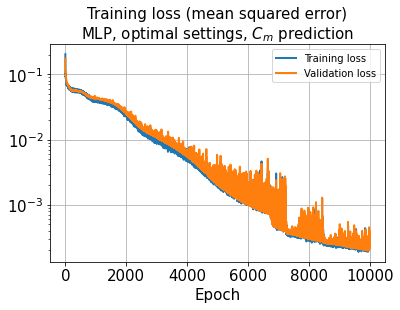

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

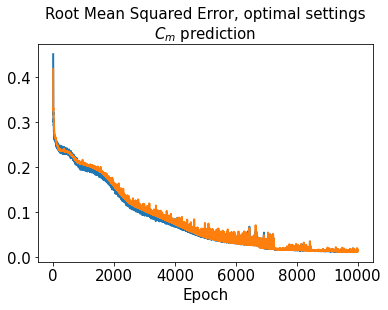

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

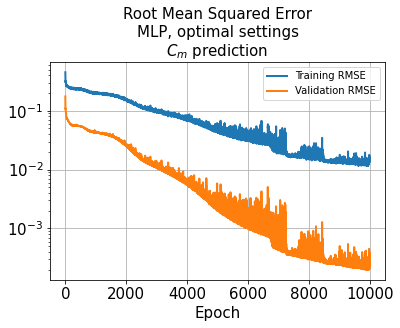

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 3ms/step - loss: 2.0356e-04 - rmse: 0.0121


In [37]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 3ms/step - loss: 2.0929e-04 - rmse: 0.0124


In [38]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 3ms/step - loss: 2.1921e-04 - rmse: 0.0128


In [39]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 2ms/step


In [40]:
decoded_train_

array([[0.17256218],
       [0.9613384 ],
       [0.26876378],
       ...,
       [0.21275344],
       [0.58594024],
       [0.75403446]], dtype=float32)

In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [46]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [47]:
model_directory = "D:\\TrainedModels\\20221226"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221226unsteadyValidation_MLP_Flap2_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [48]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [49]:
os.chdir(storage_dir)

In [50]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [51]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.03552273690594223
1.8326606275532498


In [52]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.034893104905822696
1.78635769825412


In [53]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.03941205678277914
1.9961480163985088


In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

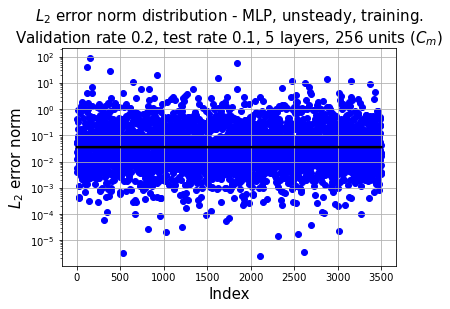

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

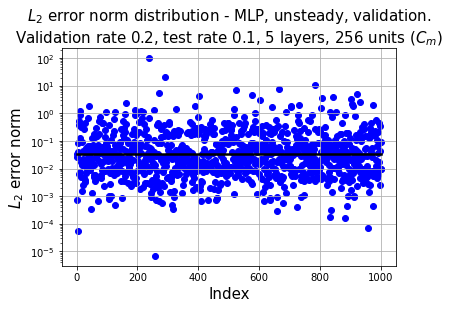

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

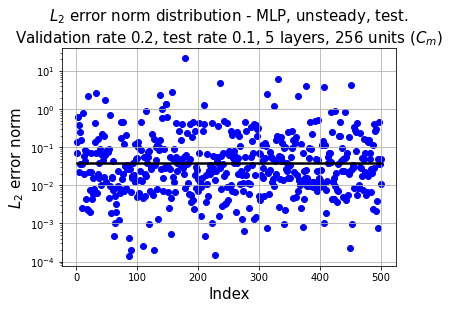

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

157/157 [==============================] - 0s 2ms/step


In [65]:
predicted.shape

(5000, 1)

In [67]:
t_train = x[index_train]+10
t_val = x[index_val]+10
t_test = x[index_test]+10

In [68]:
t_train

array([[10.   ],
       [10.001],
       [10.003],
       ...,
       [14.997],
       [14.998],
       [14.999]])

In [69]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [70]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [71]:
x

array([[0.000e+00],
       [1.000e-03],
       [2.000e-03],
       ...,
       [4.997e+00],
       [4.998e+00],
       [4.999e+00]])

In [72]:
x += 10

In [73]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x, denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0282


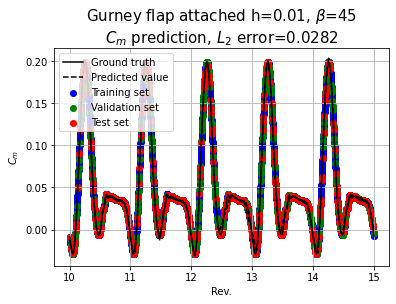

In [74]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(2, 3):
    # Index from each dataset
#     iTrain = []
#     iVal = []
#     iTest = []
    
#     # Index from input data (alpha, in this case)
#     t_train = []
#     t_val = []
#     t_test = []
    
    predictedValue = predicted#[t_len*i:t_len*(i+1),:]
    y_corres = y
    #[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
#     for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
#         iTrain.append(predicted[index])
#     for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
#         iVal.append(predicted[index])    
#     for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
#         iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)

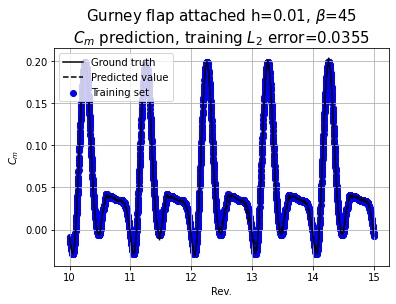

In [78]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[2]) + r'$\beta$=%d'%(beta[2])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_train)
title_Cm = title_n_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
# plt.scatter(tVal, iVal, color='g', label='Validation set')
# plt.scatter(tTest,iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

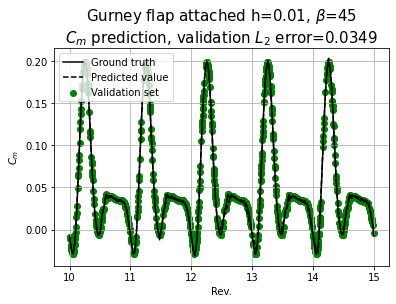

In [79]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[2]) + r'$\beta$=%d'%(beta[2])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_val)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

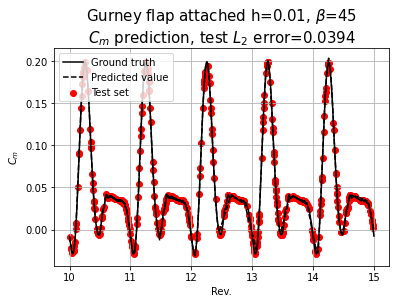

In [80]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[2]) + r'$\beta$=%d'%(beta[2])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_test)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()